In [1]:
# Dependencies
# General purpose
import copy 
import pickle
import warnings 

# Imputation and Data balancing 
from sklearn.impute import KNNImputer
from imblearn.over_sampling import ADASYN

# Statistical analysis
from scipy import stats

# Machine Learning development 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier

# In-house libraries
# Data preparation
from Framingham_utils import *
from Steno_utils import *

# EDA
from exploratory_data_analysis import * 

# Machine Learning development
from train_utils import *
from model_evaluation import *

# Performance profiling 
from profiling import *

# Directories, filenames, etc
from constants import * 

# Filter warnings 
warnings.filterwarnings("ignore")

# Path to store obtained reusults
STORE_PATH = r".\fram2steno_results"

# Save current working directory to come back later 
wd = os.getcwd()

In [2]:
# Data preparation 
fram_data, fram_X, fram_Y, fram_feat_names, fram_y_tag = prepare_Framingham(dataset_path = FRAM_PATH, filename = fram_filename)
steno_data, steno_X, steno_Y, steno_feat_names, steno_y_tag = prepare_Steno(dataset_path = STENO_PATH, filename1 = steno_filename1, filename2 = steno_filename2)

# Go back to previous directory 
os.chdir(wd)

# Data partition - Train (80%) + Validation (20%)
fram_X_train, fram_X_val, fram_y_train, fram_y_val, fram_train_data, fram_validation_data = train_test_split_and_concat(fram_X, fram_Y, test_size=0.2, random_state=4)
steno_X_train, steno_X_val, steno_y_train, steno_y_val, steno_train_data, steno_validation_data = train_test_split_and_concat(steno_X, steno_Y, test_size=0.2, random_state=4)

In [3]:
# Select the common features in Frammingham and Steno 
fram_2common_X_train = fram_X_train[['male','age','currentSmoker','prevalentStroke','sysBP']]
fram_2common_X_val = fram_X_val[['male','age','currentSmoker','prevalentStroke','sysBP']]

steno_2common_X_train = steno_X_train[['sex','age','smoking','prevcvd','sbp']]
steno_2common_X_val = steno_X_val[['sex','age','smoking','prevcvd','sbp']] 

In [4]:
# KNN-Imputation (training and validation set separately)
# Only for Framingham dataset
# Imputer declaration 
imputer = KNNImputer(missing_values = np.nan , n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean',
                      copy = 'false') 

# Imputation (training and validation separately)
fram_train_data = imputer.fit_transform(fram_train_data)
fram_validation_data = imputer.fit_transform(fram_validation_data) 

# Conversion from np.array to pd.DataFrame and convert from float to original datatype
fram_train_data, fram_X_train, fram_y_train = numerical_conversion_Framingham(fram_train_data, fram_feat_names, fram_y_tag)
fram_validation_data, fram_X_val, fram_y_val = numerical_conversion_Framingham(fram_validation_data, fram_feat_names, fram_y_tag)

In [5]:
# Balance dataset (only Frammingham)
# Balancing with ADASYN
fram_X_train, fram_y_train = ADASYN(sampling_strategy = 'minority',
                                                random_state = 5,
                                                n_neighbors = 5,
                                                n_jobs = None).fit_resample(fram_X_train, fram_y_train) 

# Add column Y to dataframe 
fram_X_train.reset_index(drop=True, inplace=True)
fram_y_train.reset_index(drop=True, inplace=True)
fram_train_data = pd.concat([fram_X_train, fram_y_train], axis = 1)

In [6]:
# Convert steno y from series to dataframe 
steno_y_train = pd.DataFrame(steno_y_train)
steno_y_train.columns = [steno_y_tag]

steno_y_val = pd.DataFrame(steno_y_val)
steno_y_val.columns = [steno_y_tag]

In [7]:
# Extract common features to train ML models with 2 data subsets with just the common features
fram_2common_X_train = fram_X_train[['male','age','currentSmoker','prevalentStroke','sysBP']]
fram_2common_X_val = fram_X_val[['male','age','currentSmoker','prevalentStroke','sysBP']]

steno_2common_X_train = steno_X_train[['sex','age','smoking','prevcvd','sbp']]
steno_2common_X_val = steno_X_val[['sex','age','smoking','prevcvd','sbp']] 

In [8]:
# To rename variables names and format to be the same, so the second dataset can be used to train the same model
fram_2common_X_train.rename(columns={'male':'sex', 'currentSmoker':'smoking','prevalentStroke':'prevcvd','sysBP':'sbp'}, inplace = True)
fram_2common_X_val.rename(columns={'male':'sex', 'currentSmoker':'smoking','prevalentStroke':'prevcvd','sysBP':'sbp'}, inplace = True)
# NOTE: sex = 1 is male, sex = 0 is female, so no transformation is needed

In [9]:
# Go to "EDA" directory, if not create one 
if not os.path.exists('EDA'):
    os.makedirs('EDA')

# Change directory to "EDA"
os.chdir('EDA')

In [10]:
# Go to "compared_distributions" directory, if not create one
if not os.path.exists('compared_distributions'):
    os.makedirs('compared_distributions')

# Change directory to "compared_distributions"
os.chdir('compared_distributions')

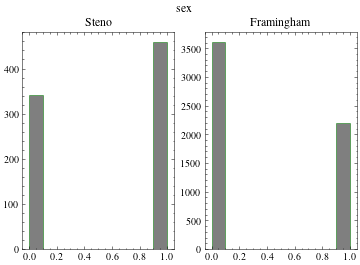

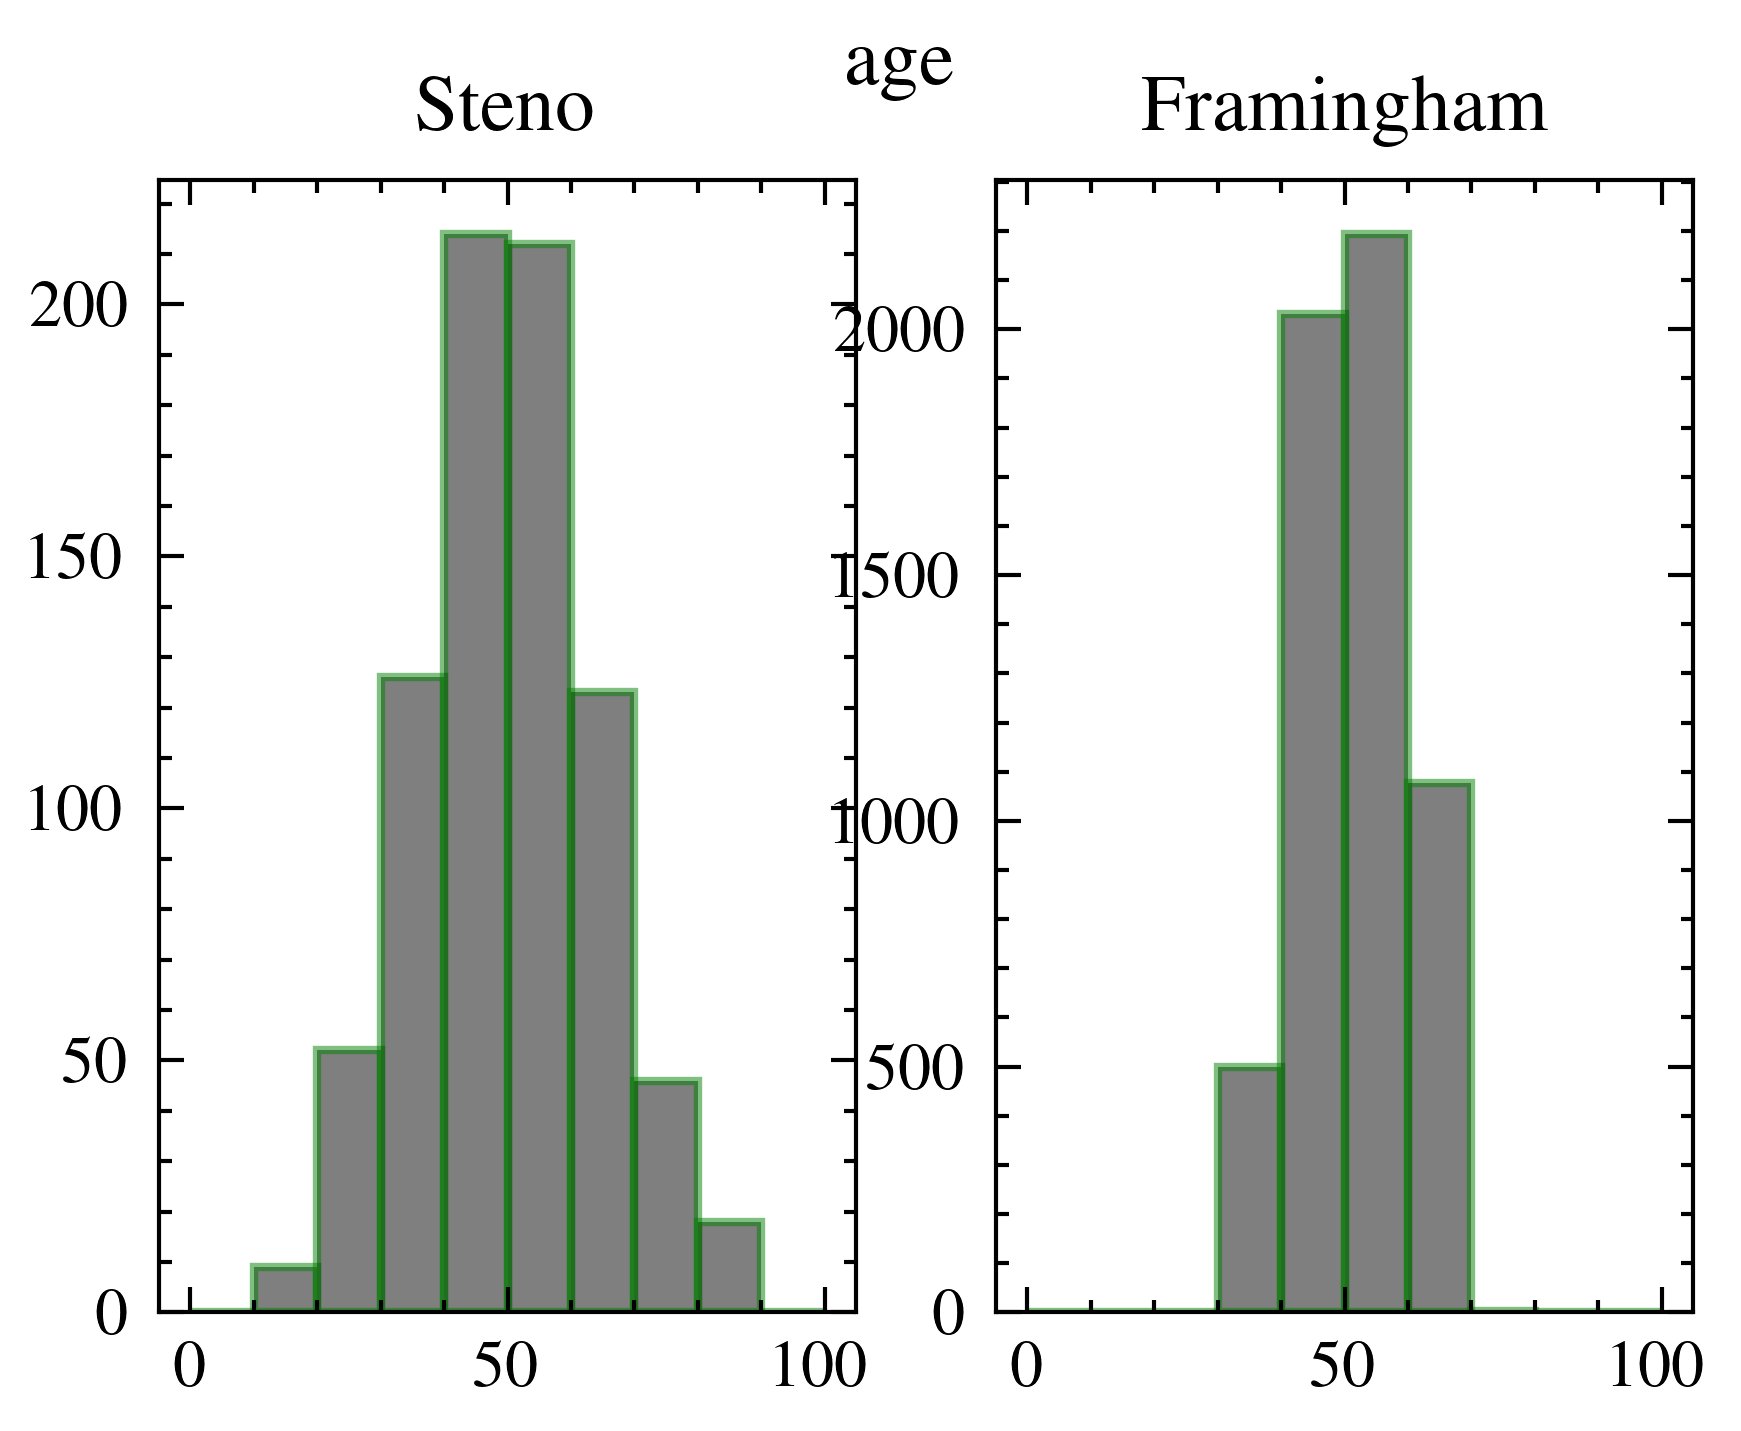

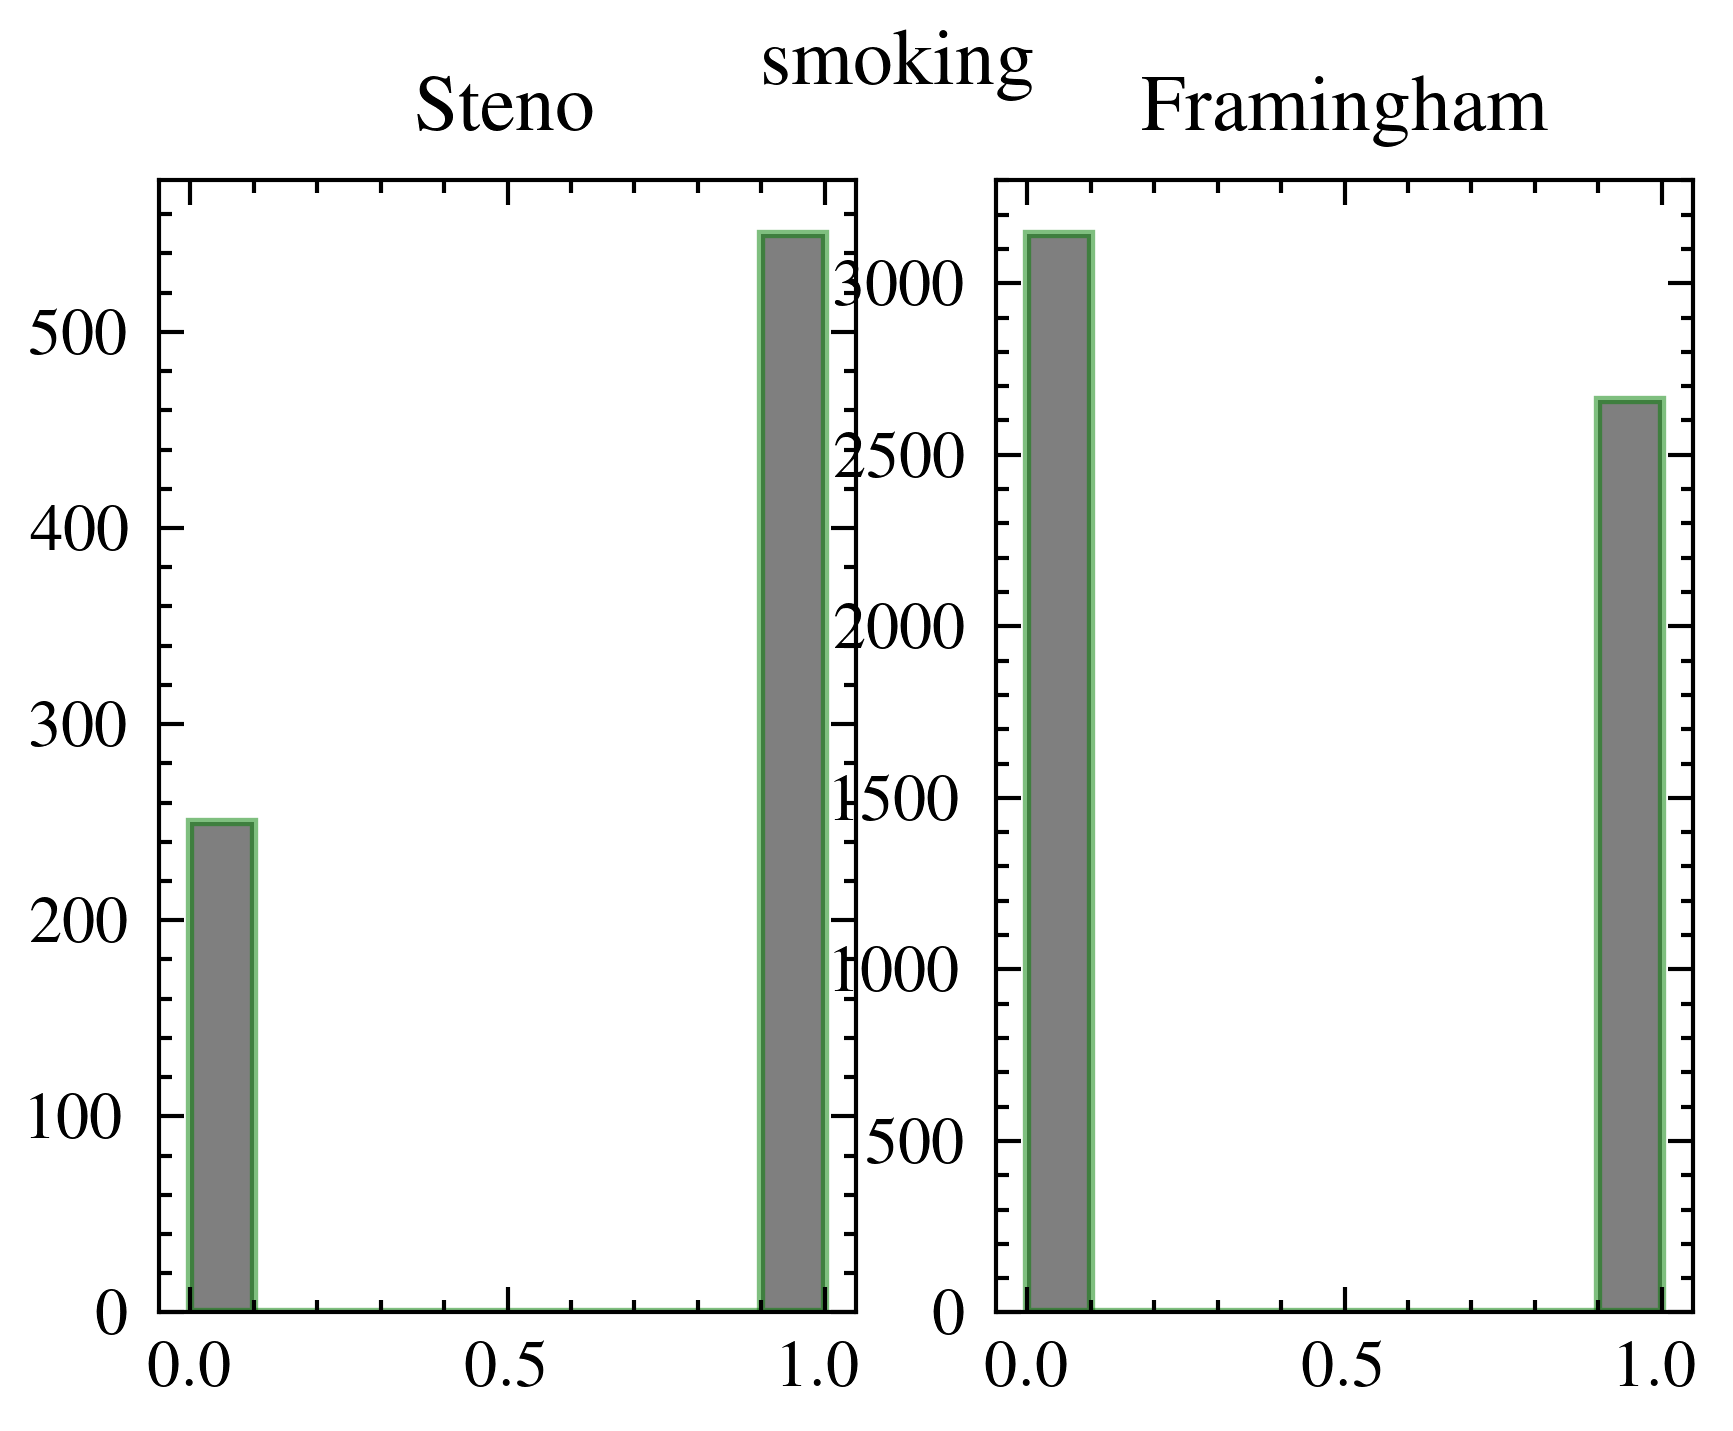

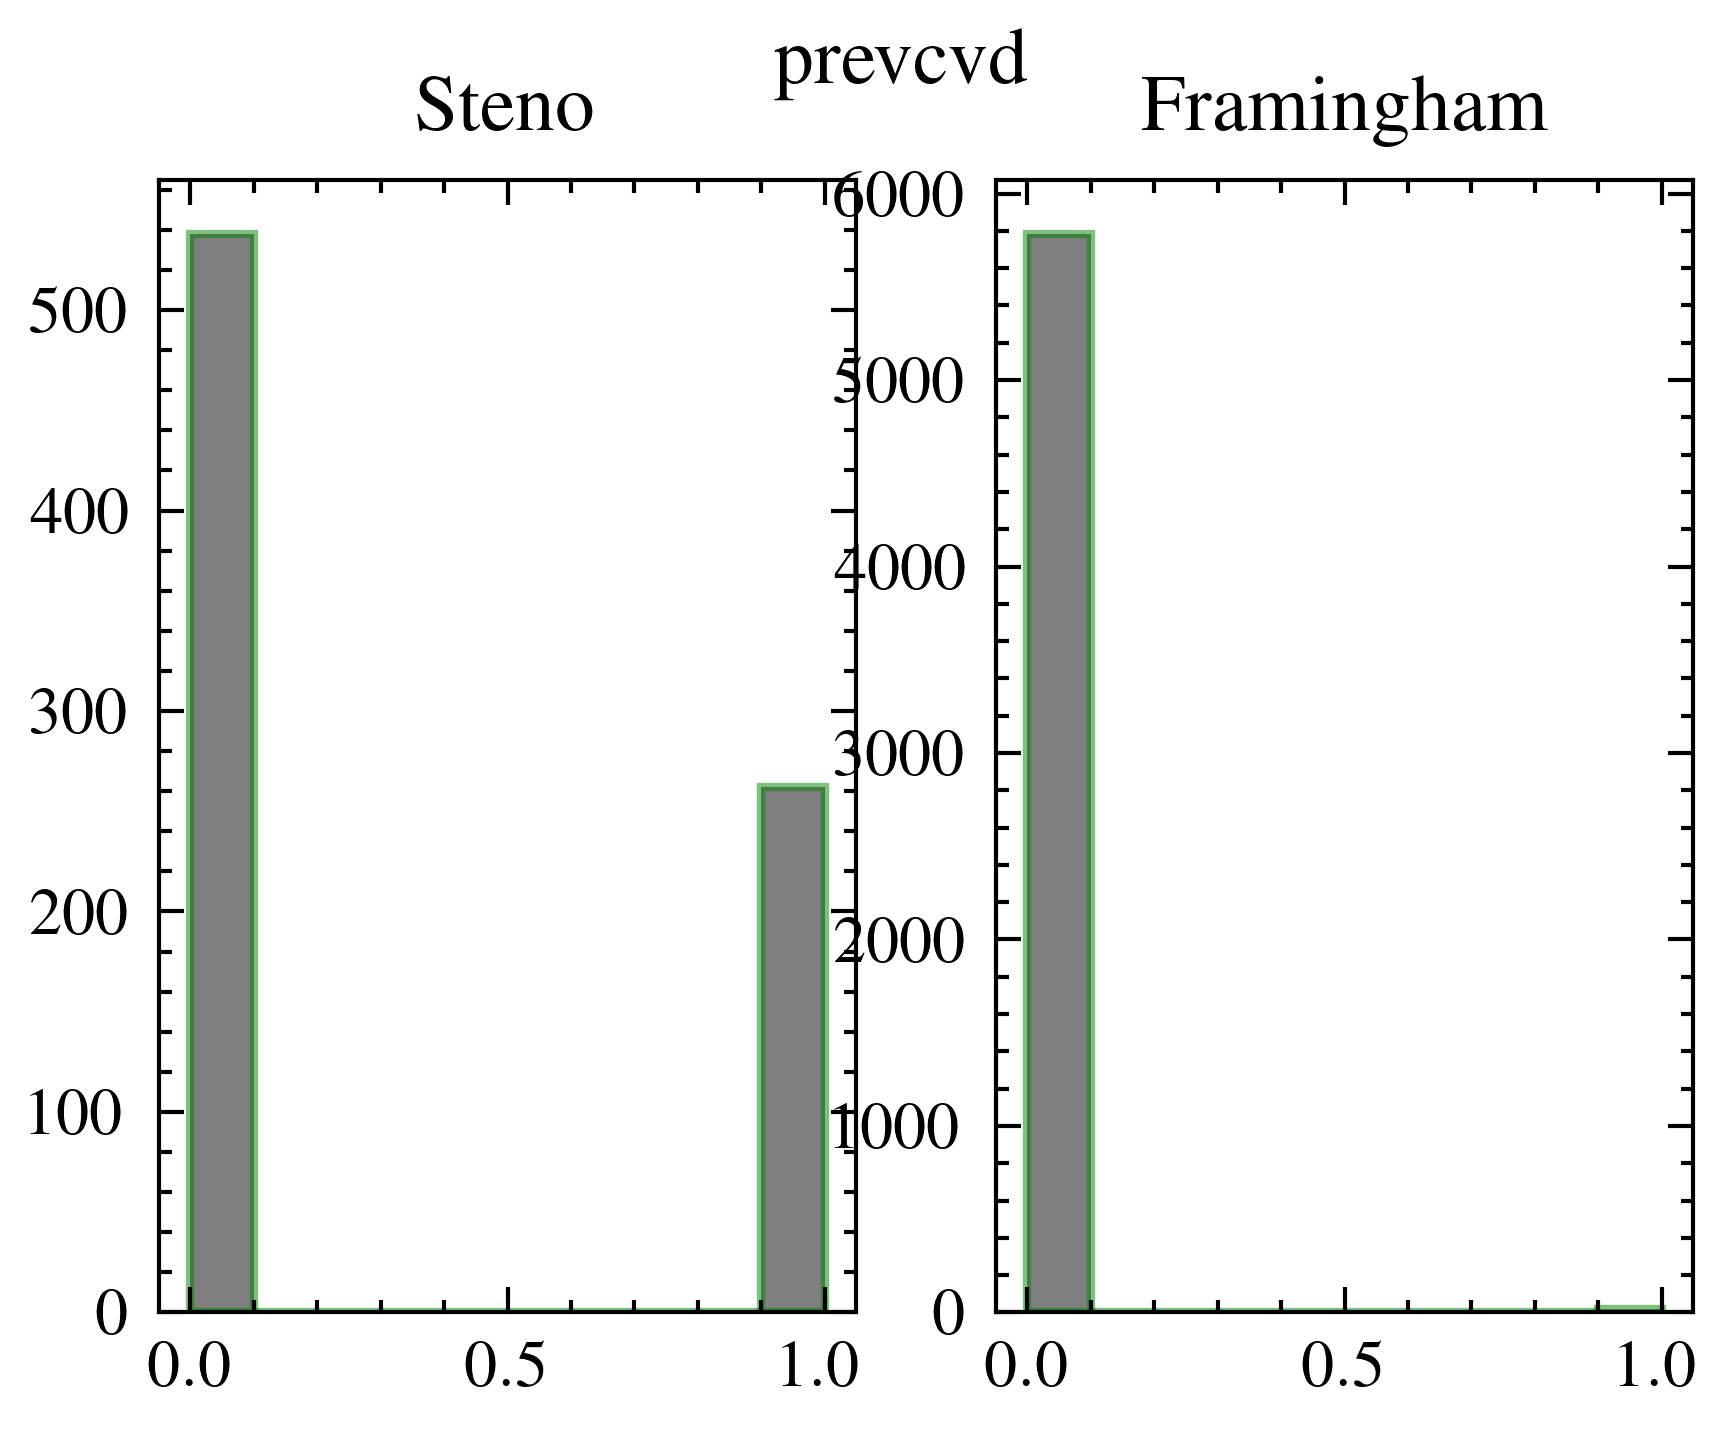

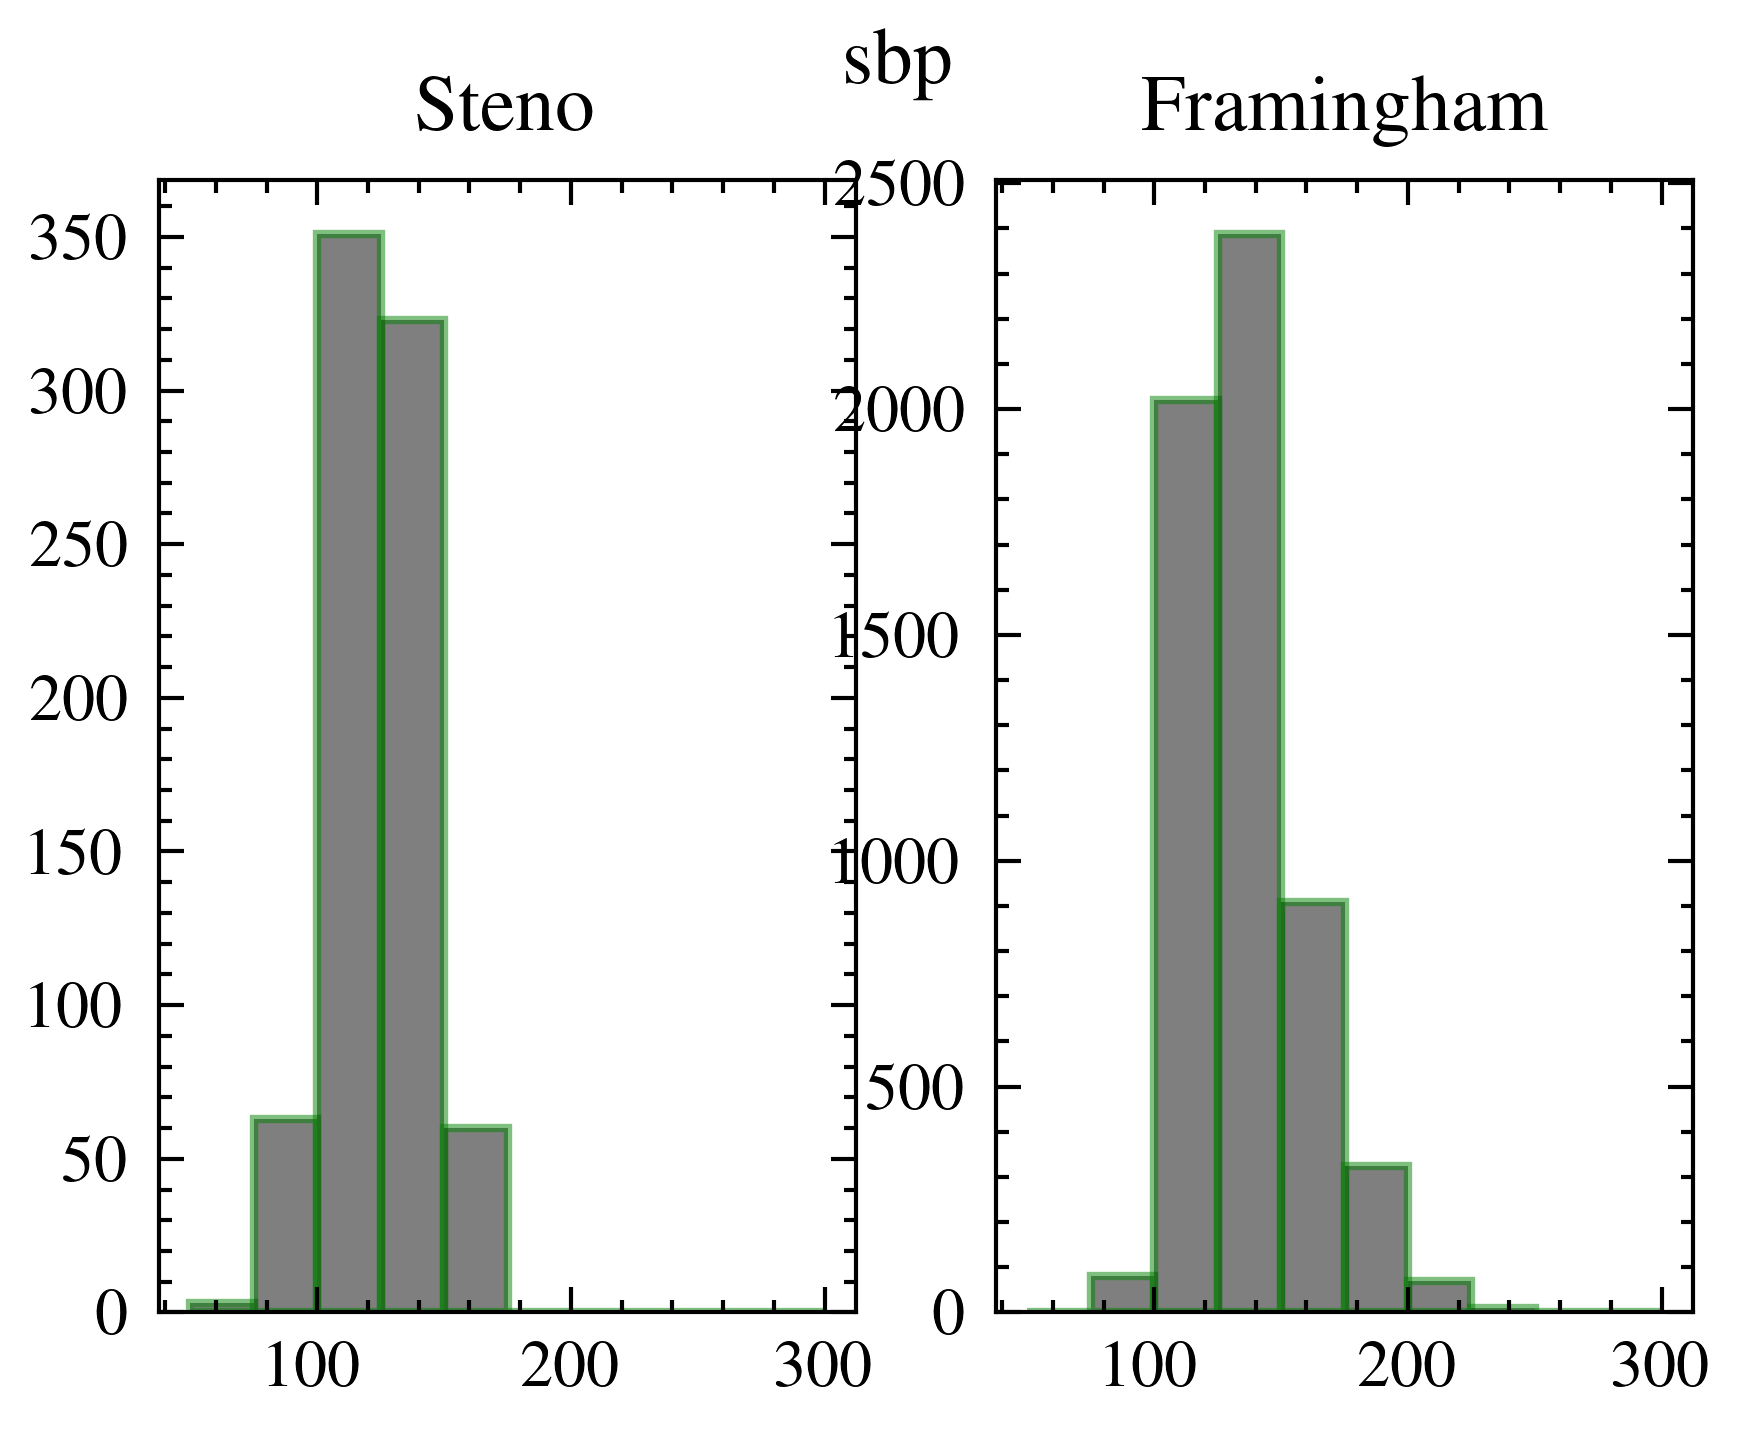

In [11]:
# Distribution comparison of Steno and Frammingham datasets in the common features 

# Dummy counter 
i = -1

# List of ranges to plot the histograms
ranges = [(0,1),(0,100),(0,1),(0,1),(50,300)]

for feat in steno_2common_X_train:
    
    i = i + 1

    # Set IEEE style
    plt.style.use(['science','ieee'])

    # Figure
    fig, ax = plt.subplots(nrows=1, ncols=2)
    
    # Set figure title
    fig.suptitle(feat)

    ax[0].hist(steno_2common_X_train[feat], range = ranges[i], alpha=0.5, ec='g', label="", fill=True)
    ax[0].set_title('Steno')
    ax[1].hist(fram_2common_X_train[feat], range = ranges[i],  alpha=0.5, ec='g', label="", fill=True)
    ax[1].set_title('Framingham')

    # Save figure with high resolution 
    fig.savefig(feat + '_compared.png', dpi=300, bbox_inches='tight')

In [12]:
# Perform test Shapiro-Wilk to check normality of the distributions
shapiro_test_fram_age = stats.shapiro(fram_2common_X_train['age'])
shapiro_test_fram_bp = stats.shapiro(fram_2common_X_train['sbp'])

# Print statistics and p-value
print('Shapiro-Wilk test for Frammingham age: ', shapiro_test_fram_age)
print('Shapiro-Wilk test for Frammingham blood pressure: ', shapiro_test_fram_bp)

shapiro_test_steno_age = stats.shapiro(steno_2common_X_train['age'])
shapiro_test_steno_bp = stats.shapiro(steno_2common_X_train['sbp'])

# Print statistics and p-value
print('Shapiro-Wilk test for Steno age: ', shapiro_test_steno_age)
print('Shapiro-Wilk test for Steno blood pressure: ', shapiro_test_steno_bp)

Shapiro-Wilk test for Frammingham age:  ShapiroResult(statistic=0.9763694405555725, pvalue=5.721451116073689e-30)
Shapiro-Wilk test for Frammingham blood pressure:  ShapiroResult(statistic=0.9438034892082214, pvalue=2.129973665773722e-42)
Shapiro-Wilk test for Steno age:  ShapiroResult(statistic=0.9974252581596375, pvalue=0.24467916786670685)
Shapiro-Wilk test for Steno blood pressure:  ShapiroResult(statistic=0.9982163310050964, pvalue=0.5829039216041565)


In [13]:
# Counts 0 and 1 in binary variables
print('Frammingham gender counts (%): ', fram_2common_X_train['sex'].value_counts()*100/len(fram_2common_X_train))
print('Frammingham smoker counts (%): ', fram_2common_X_train['smoking'].value_counts()*100/len(fram_2common_X_train))
print('Frammingham prevalentStroke counts (%): ', fram_2common_X_train['prevcvd'].value_counts()*100/len(fram_2common_X_train))


print('Steno gender counts (%): ', steno_2common_X_train['sex'].value_counts()*100/len(steno_2common_X_train))
print('Steno smoker counts (%): ', steno_2common_X_train['smoking'].value_counts()*100/len(steno_2common_X_train))
print('Steno prevalentStroke counts (%): ', steno_2common_X_train['prevcvd'].value_counts()*100/len(steno_2common_X_train))

Frammingham gender counts (%):  0    62.226435
1    37.773565
Name: sex, dtype: float64
Frammingham smoker counts (%):  0    54.178873
1    45.821127
Name: smoking, dtype: float64
Frammingham prevalentStroke counts (%):  0    99.672583
1     0.327417
Name: prevcvd, dtype: float64
Steno gender counts (%):  1    57.375
0    42.625
Name: sex, dtype: float64
Steno smoker counts (%):  1    68.75
0    31.25
Name: smoking, dtype: float64
Steno prevalentStroke counts (%):  0    67.25
1    32.75
Name: prevcvd, dtype: float64


In [14]:
os.chdir('..')

In [15]:
datasets = ('Frammingham 5 commons', 'Steno 5 commons')
classifiers = {'SVM' : {}, 'MLP' : {}}
regressors = {'SVM' : {}, 'MLP': {}}
class_metrics = {'f1' : np.zeros(1), 'roc' : np.zeros(1), 'auc' : np.zeros(1), 'prob':  np.zeros(1)}
reg_metrics = {'mae' : np.zeros(1), 'mse' : np.zeros(1), 'R1' : np.zeros(1)}

# Generate dict to store results 
metrics_dict =  get_eval_dictionaries(datasets, classifiers, regressors, class_metrics, reg_metrics)

In [16]:
# Declare common numerical features to leave binary variables as they are 
common_numerical_features = ['age', 'sbp']

# Cross standardization (i.e., Steno dataset will be normalized according to Framingam's mean and std)
steno_2common_train_data, steno_2common_X_train, steno_2common_y_train = cross_standardization(fram_2common_X_train, steno_2common_X_train, steno_y_train, common_numerical_features)

# Validation 
steno_2common_validation_data, steno_2common_X_val, steno_2common_y_val = cross_standardization(fram_2common_X_train, steno_2common_X_val, steno_y_val, common_numerical_features)
fram_2common_validation_data, fram_2common_X_val, fram_2common_y_val = cross_standardization(fram_2common_X_train, fram_2common_X_val, fram_y_val, common_numerical_features)

# The reference is standardized the last, to properly standardize the rest 
fram_2common_train_data, fram_2common_X_train, fram_2common_y_train = standardization(fram_2common_X_train, fram_y_train, common_numerical_features)

In [17]:
# Go to "overlapped_distributions" directory, if not create one
if not os.path.exists('overlapped_distributions'):
    os.makedirs('overlapped_distributions')

# Change directory to "compared_distributions"
os.chdir('overlapped_distributions')

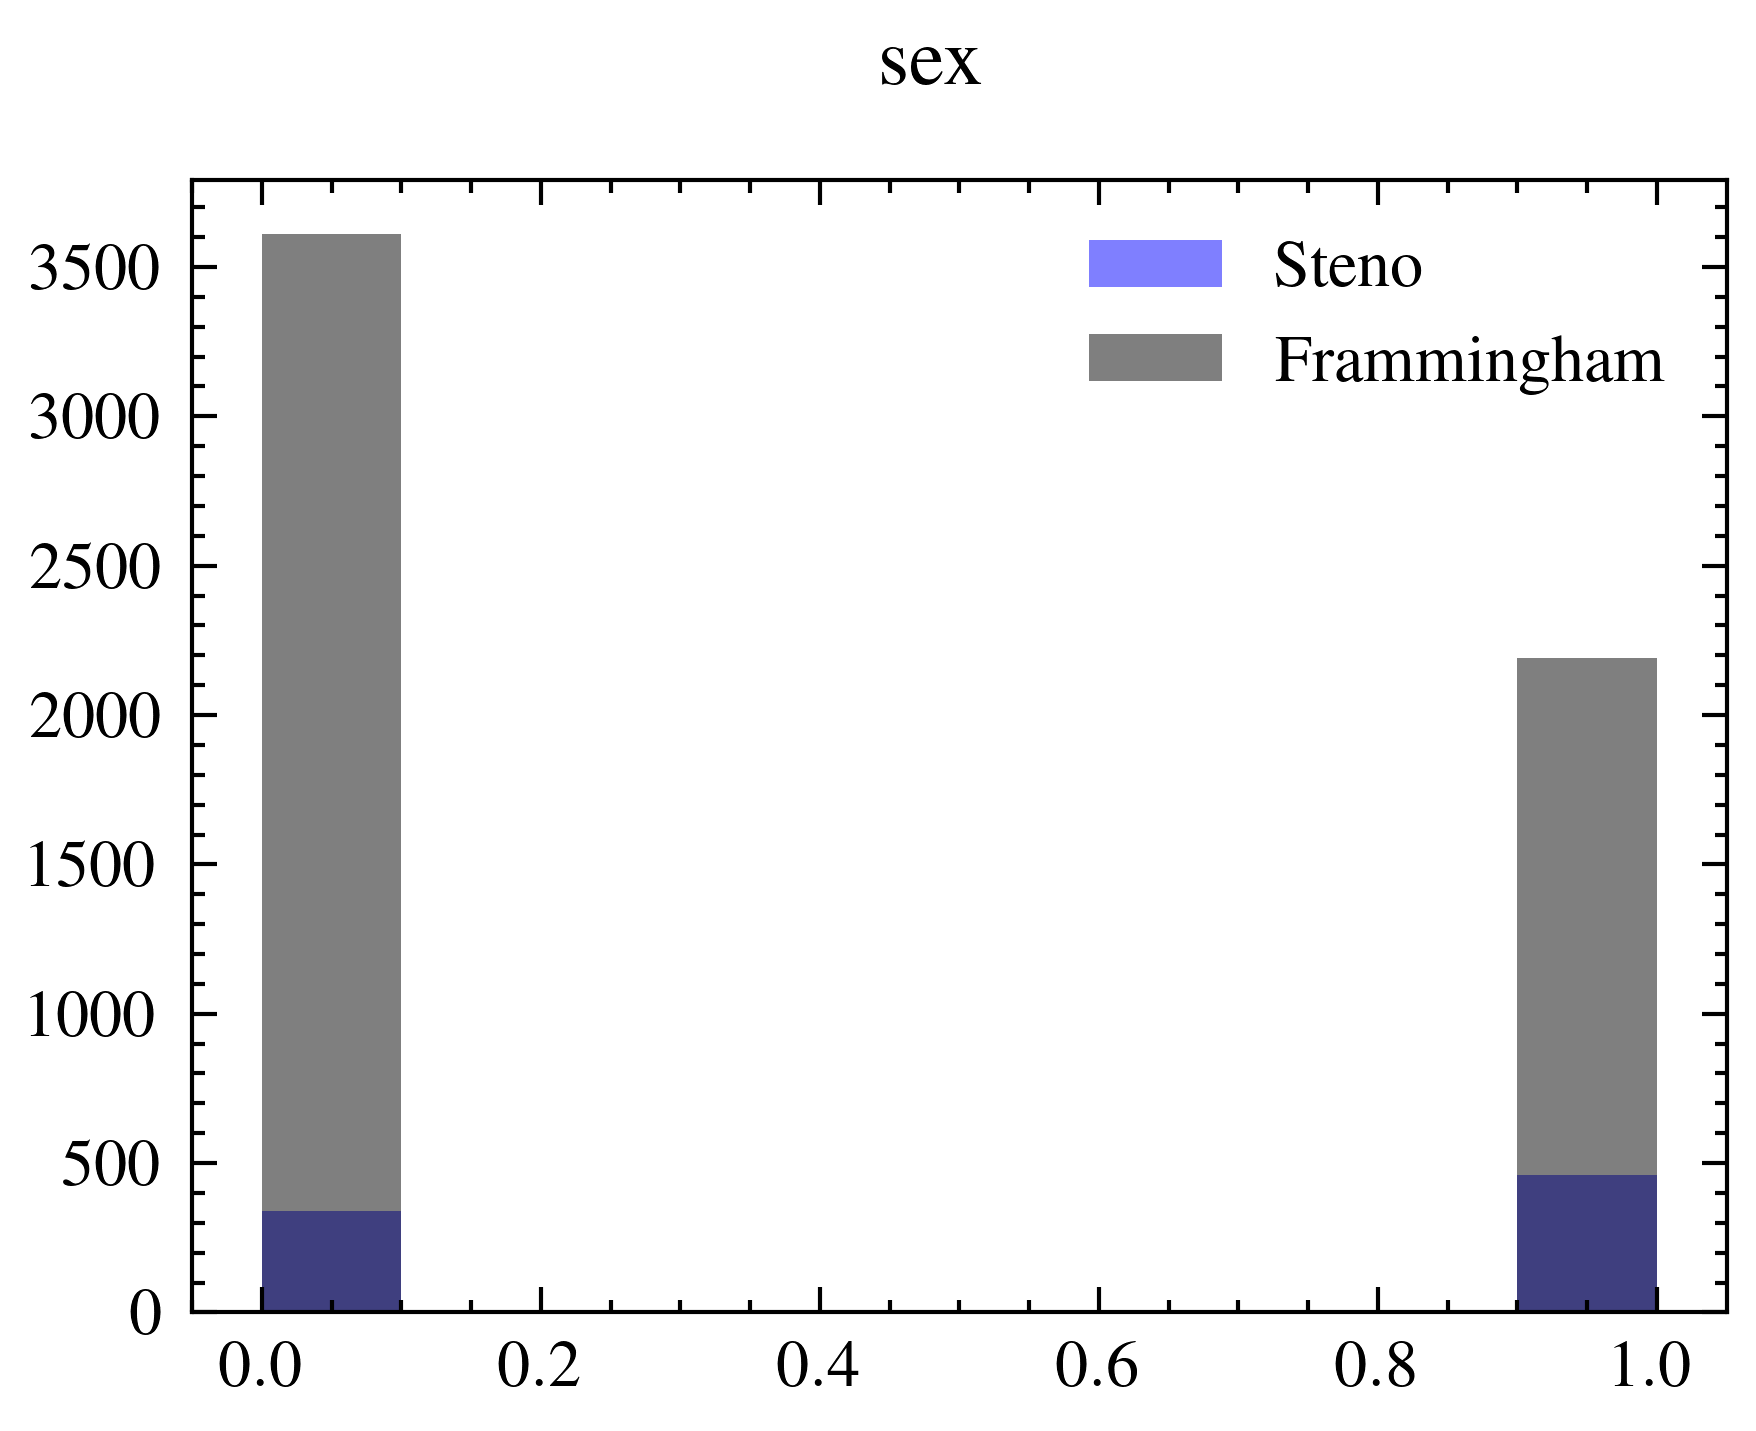

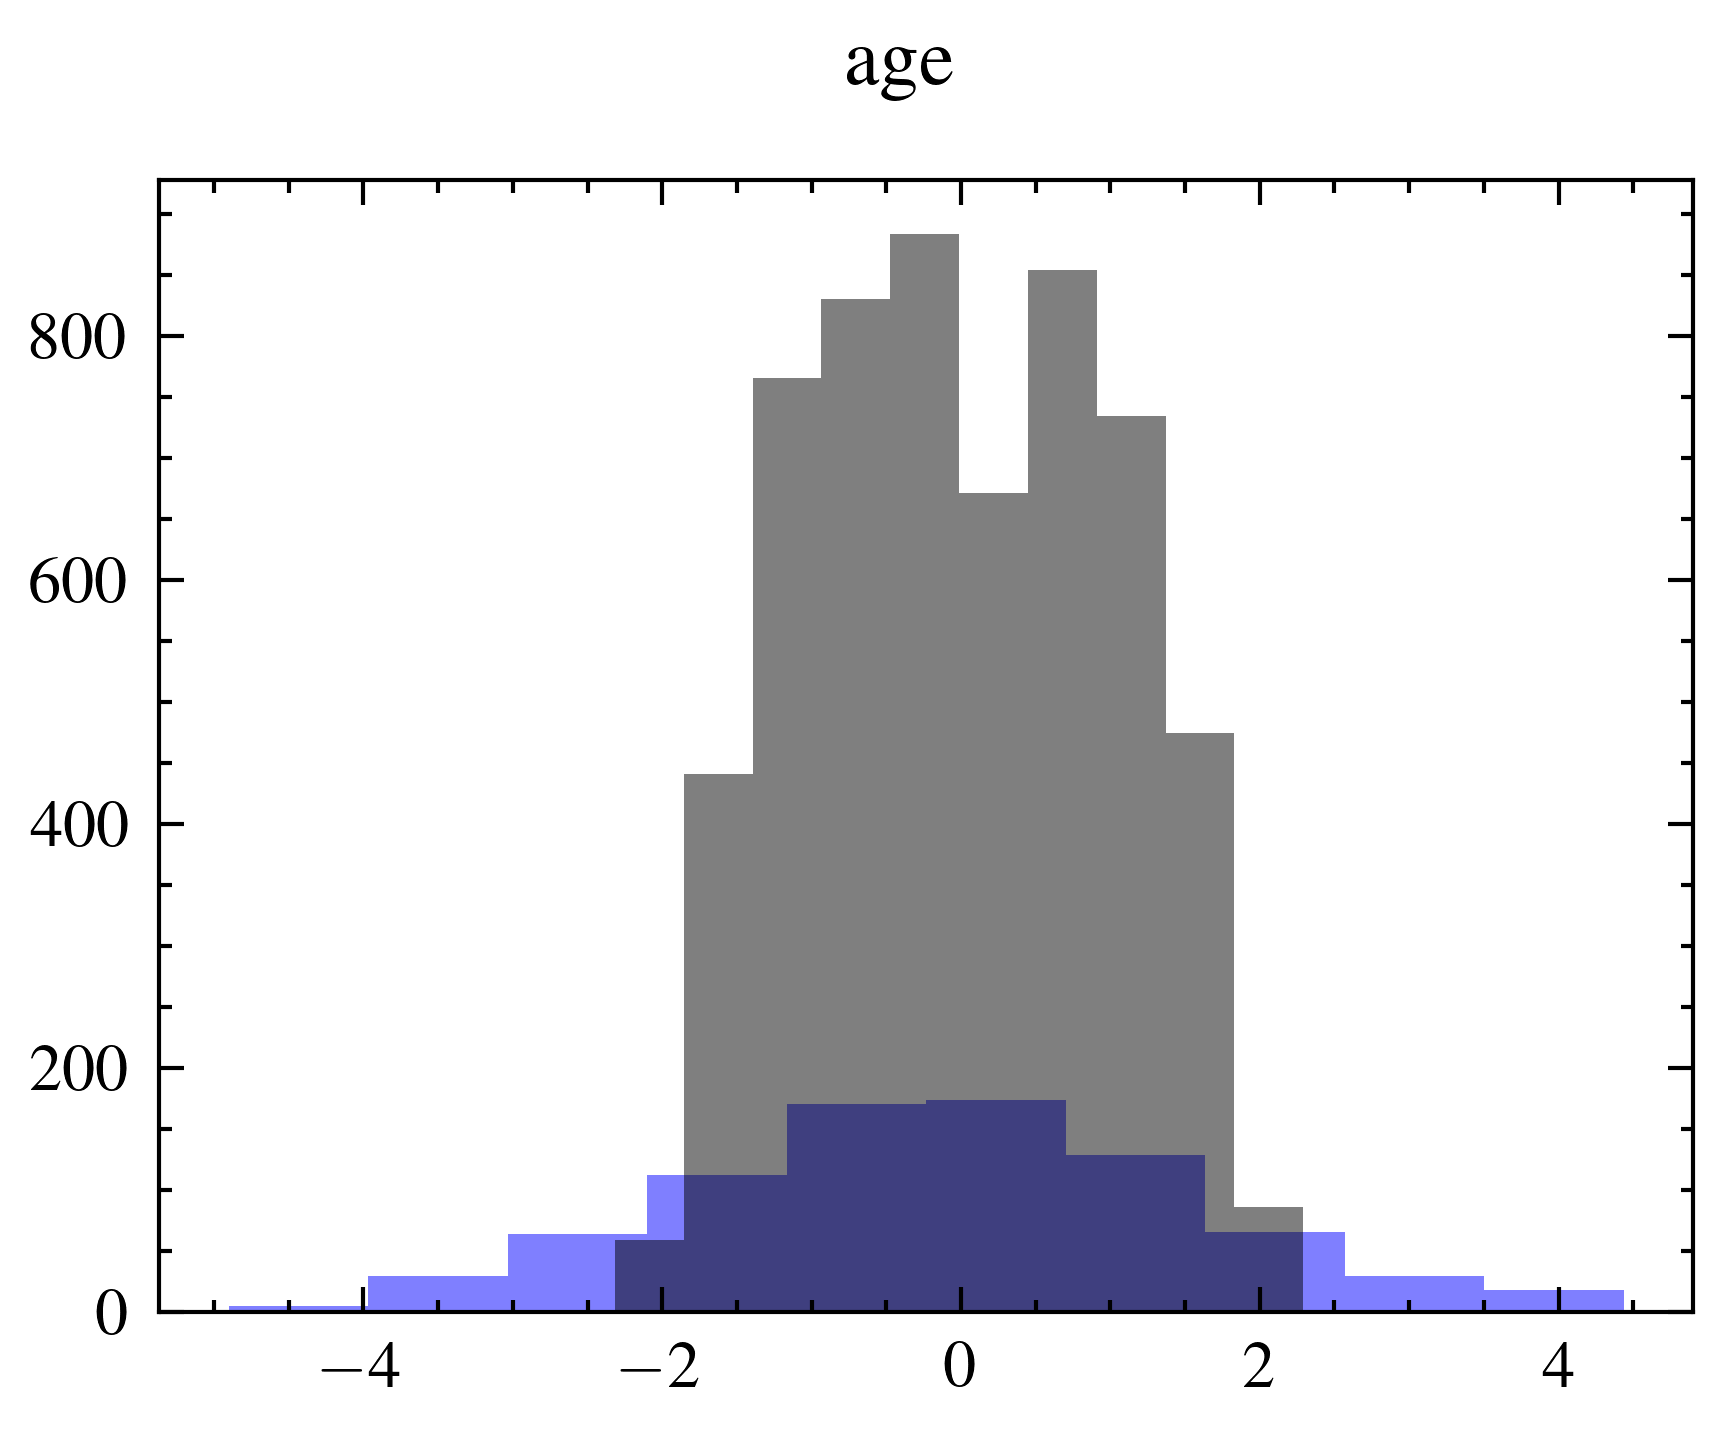

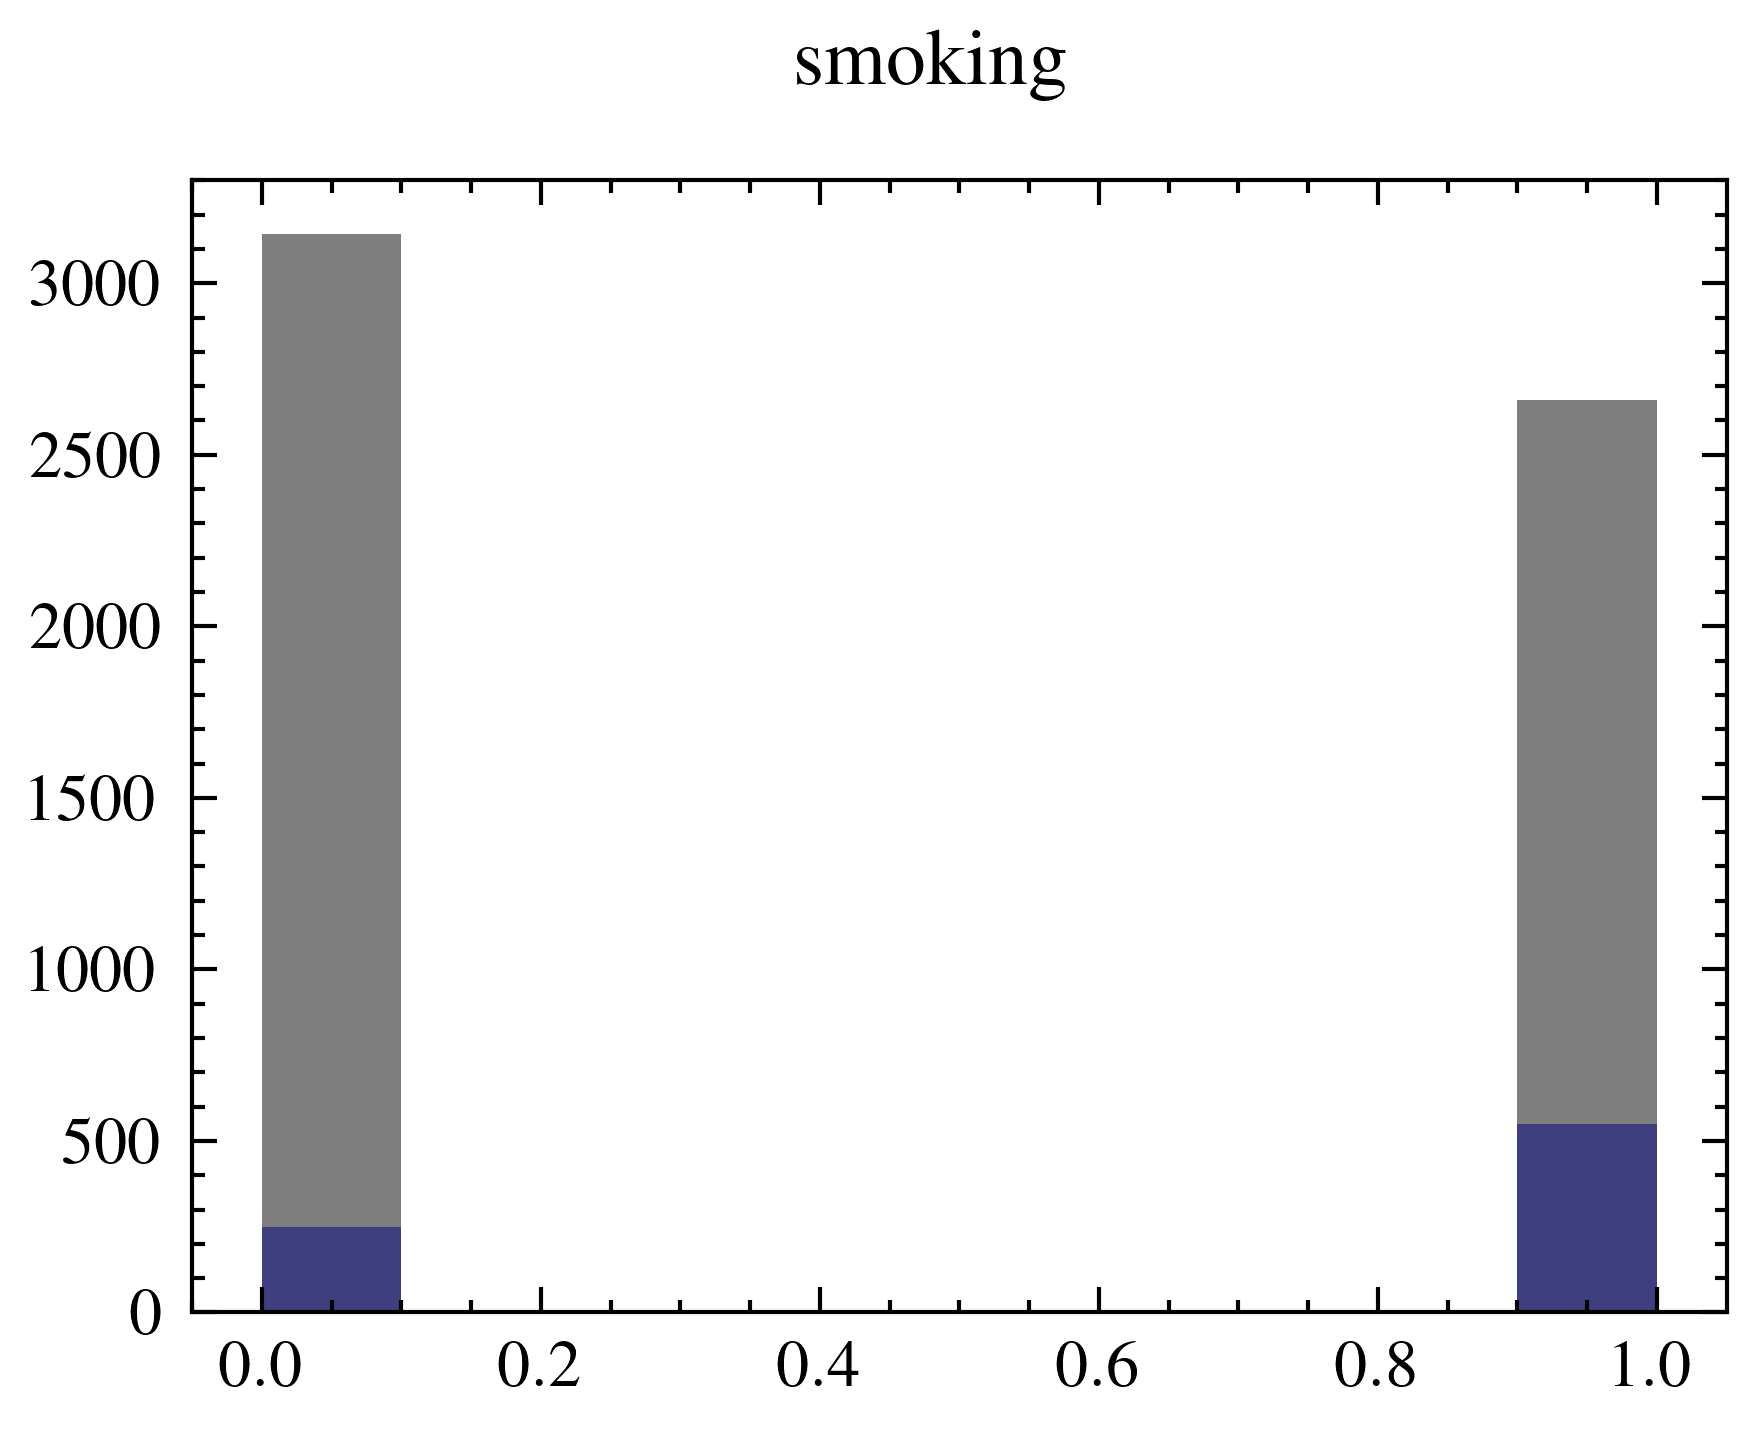

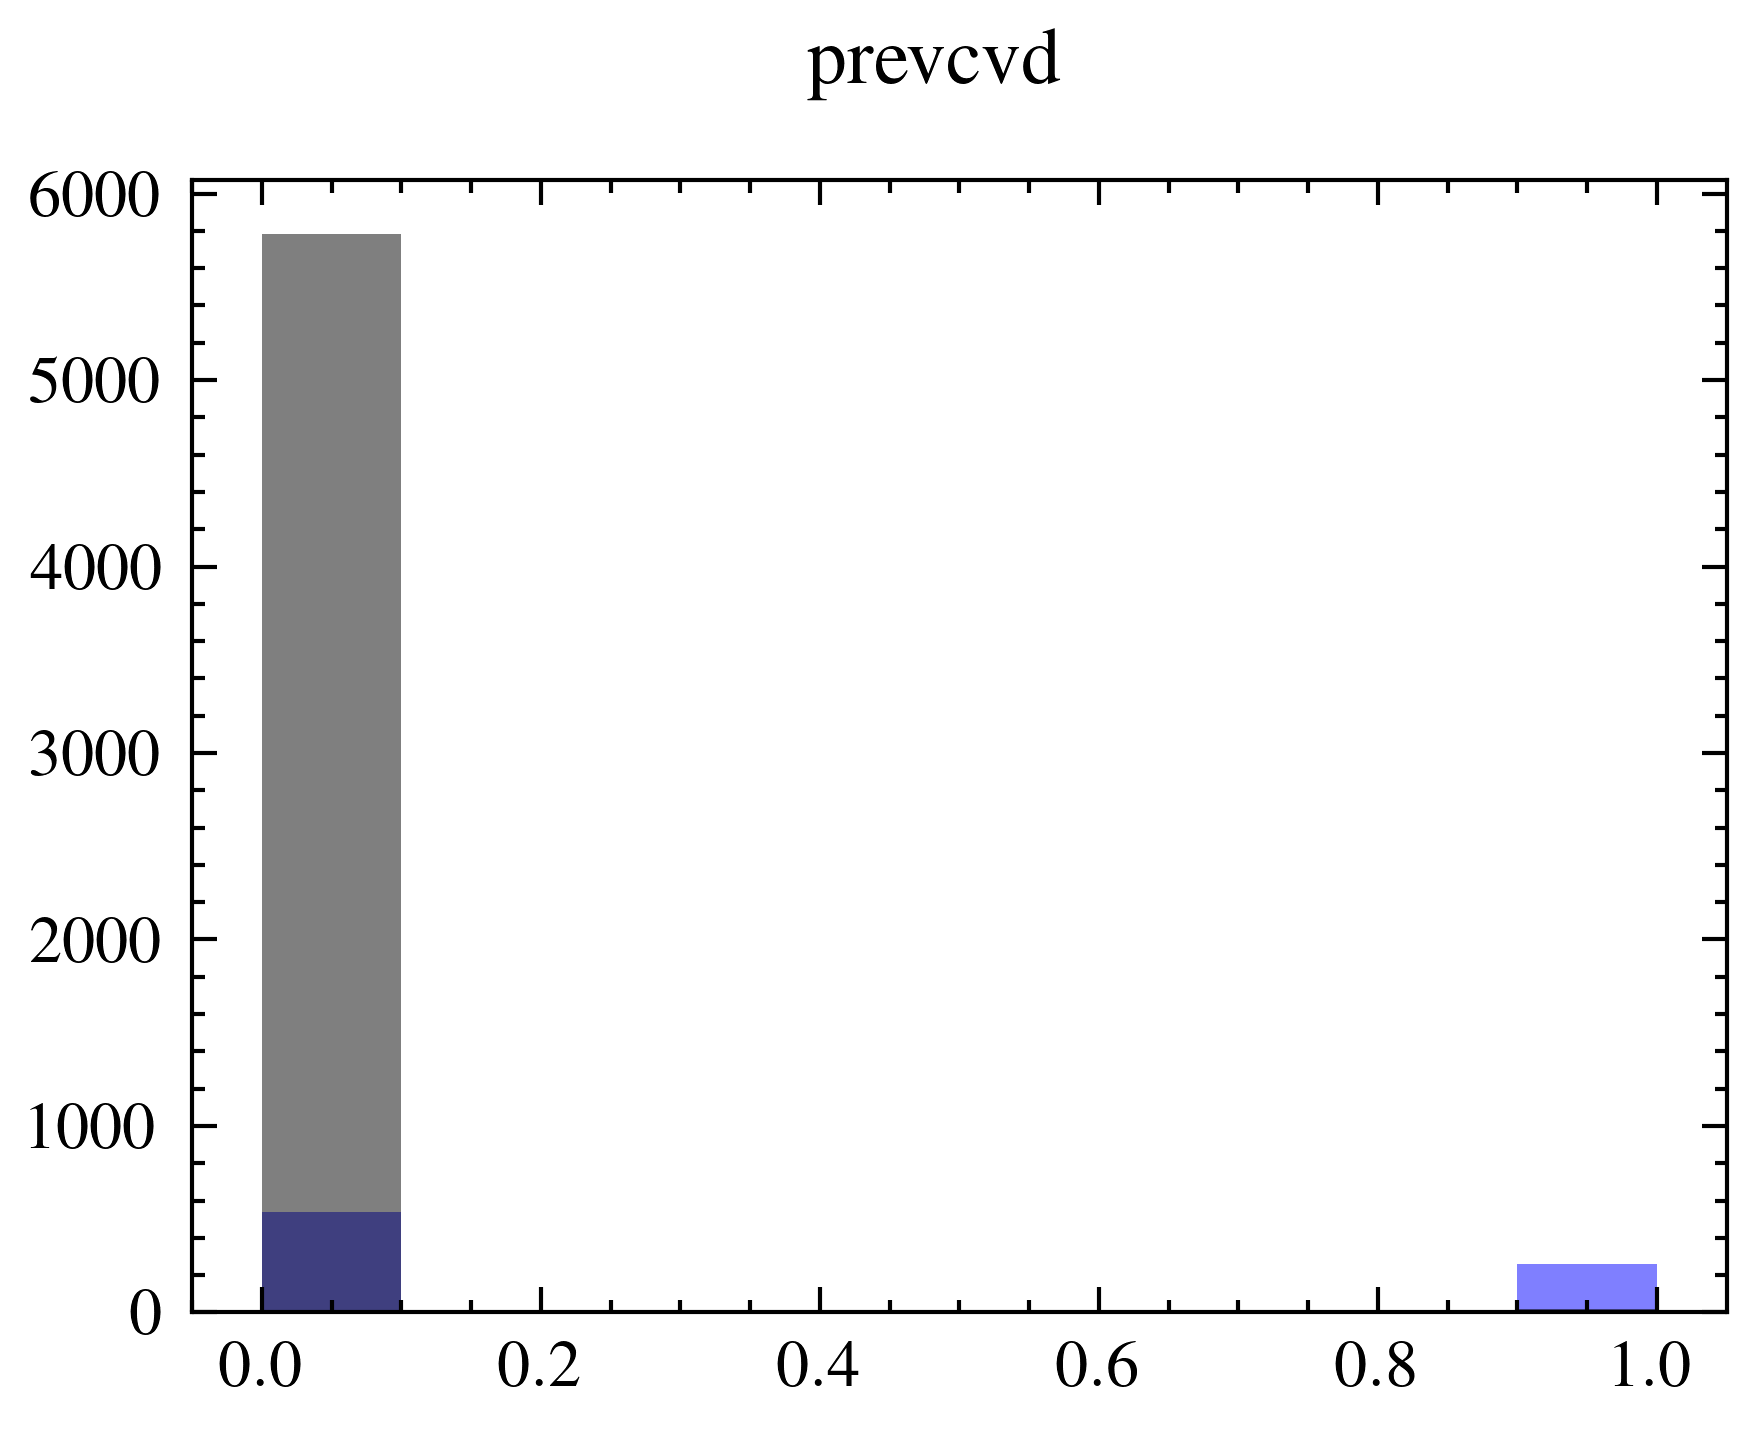

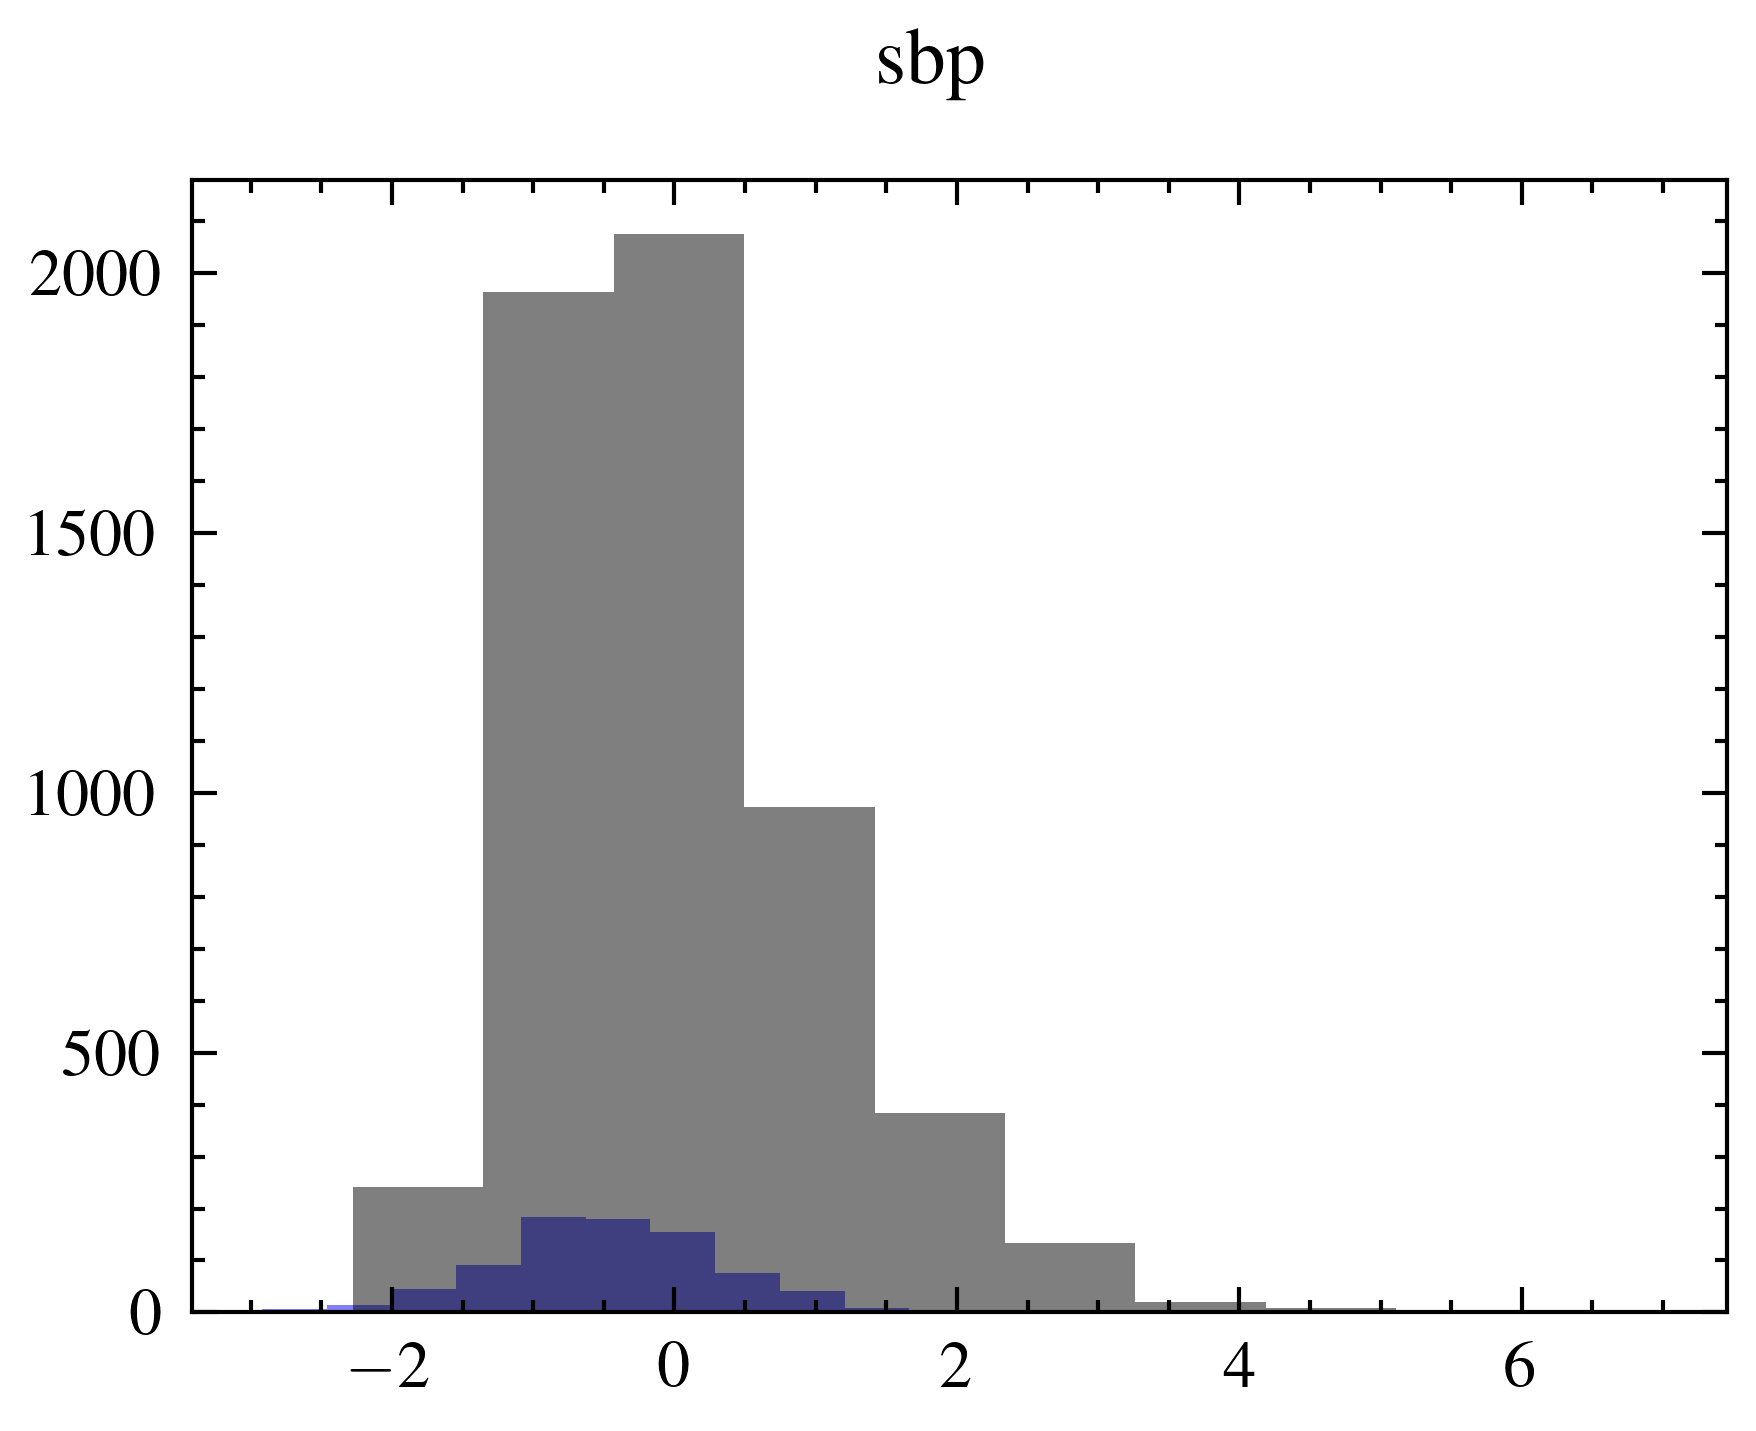

In [18]:
# Distribution comparison of Steno and Frammingham training datasets in the common features after standardization based on Framingham database
for feat in steno_2common_X_train:
    
    # Figure
    fig, ax = plt.subplots(nrows=1, ncols=1)

    # Set IEEE style
    plt.style.use(['science','ieee'])
    
    # Set figure title
    fig.suptitle(feat)

    ax.hist(steno_2common_X_train[feat], alpha=0.5, color = 'b', label="", fill=True)
    #ax[0].set_title('Steno')
    ax.hist(fram_2common_X_train[feat],  alpha=0.5, color = 'k', label="", fill=True)
    #ax[1].set_title('Framingham')

    # Set the legend only in the first figure
    if feat == 'sex':
        ax.legend(["Steno", "Frammingham"],loc='upper right')
    
    # Save figure with high resolution 
    fig.savefig(feat + '_train_norm_overlapped.png', dpi=300, bbox_inches='tight')


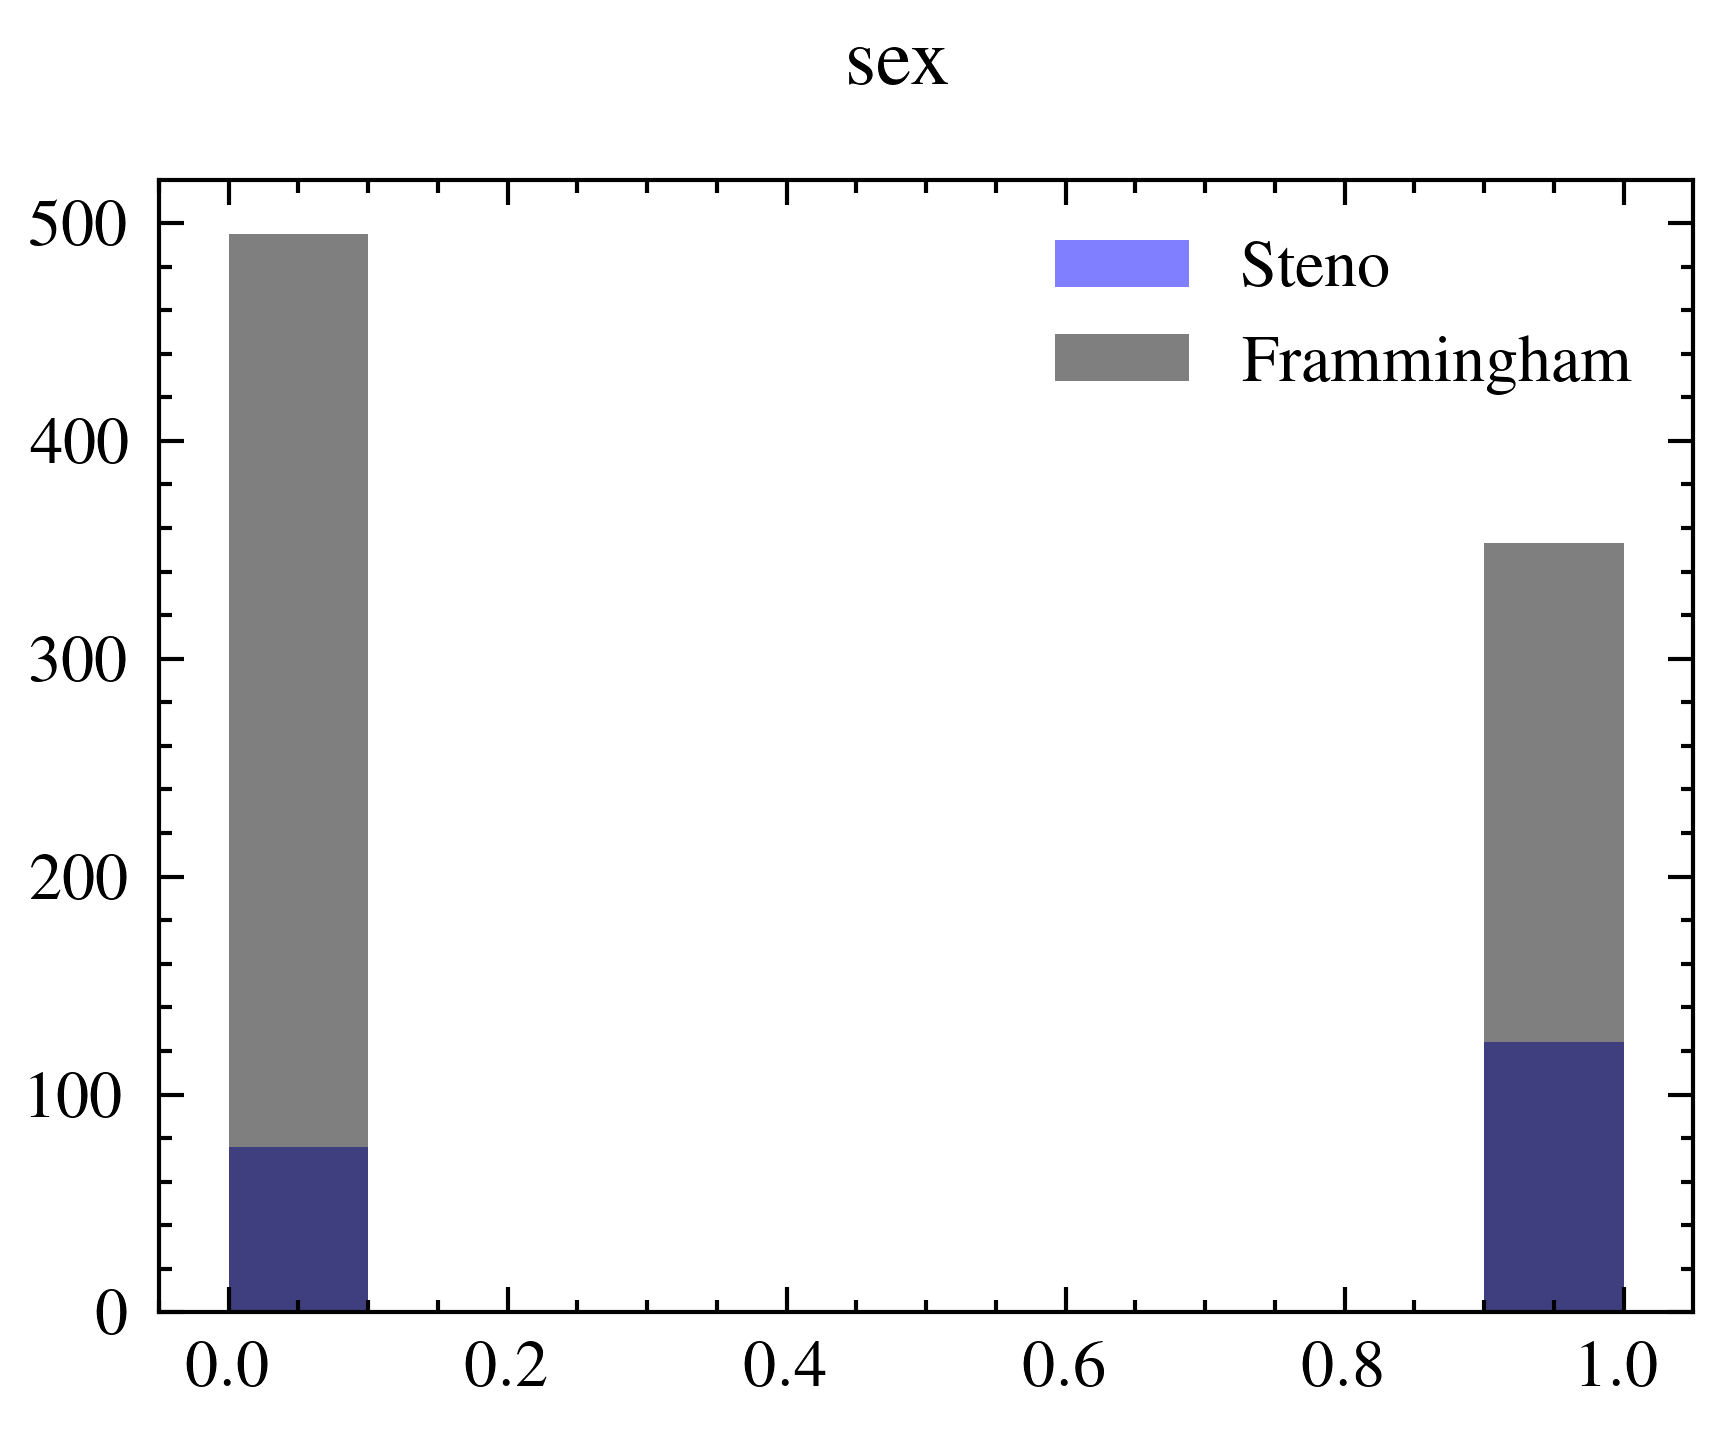

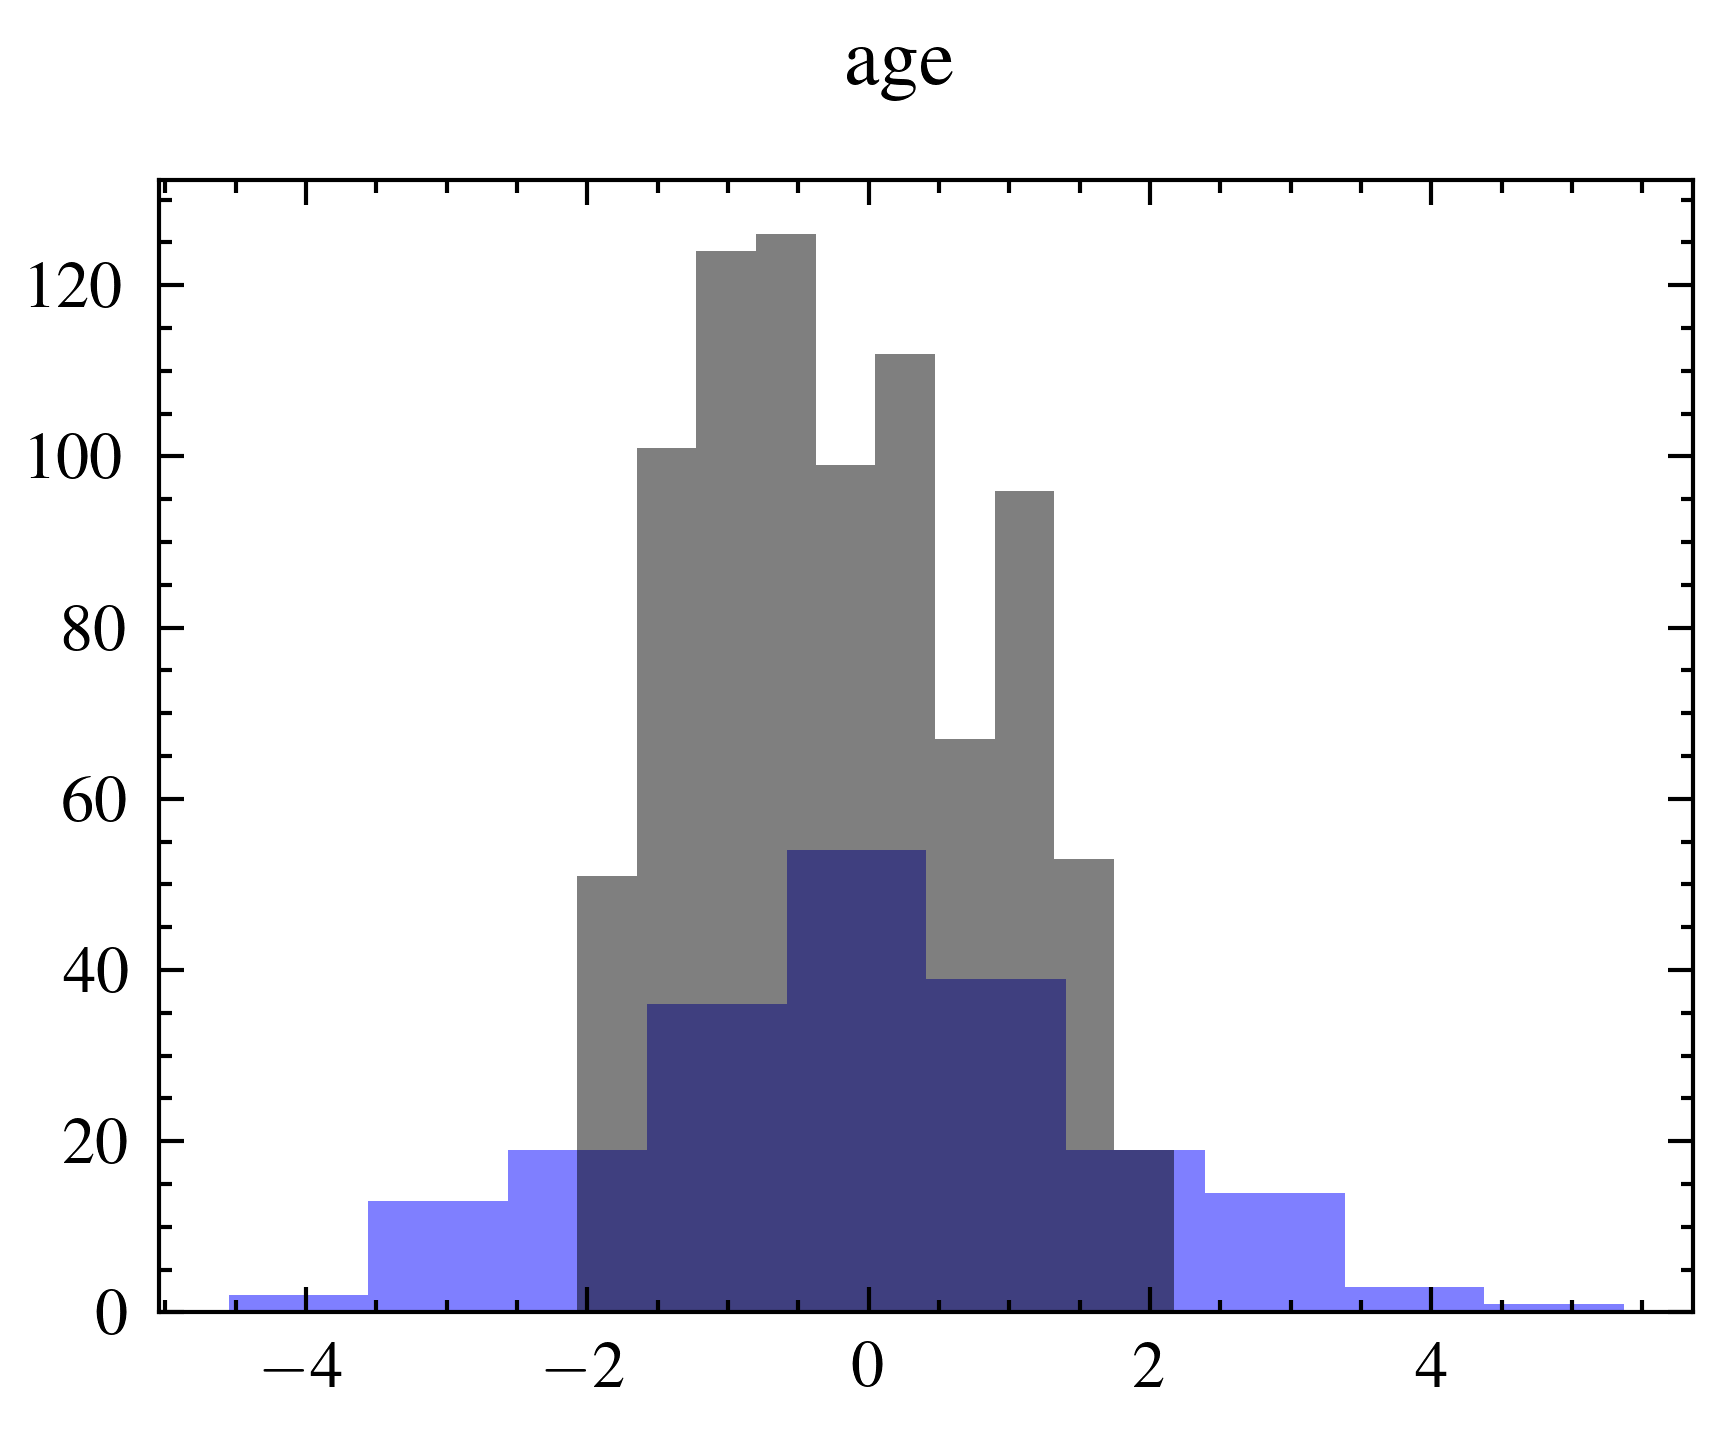

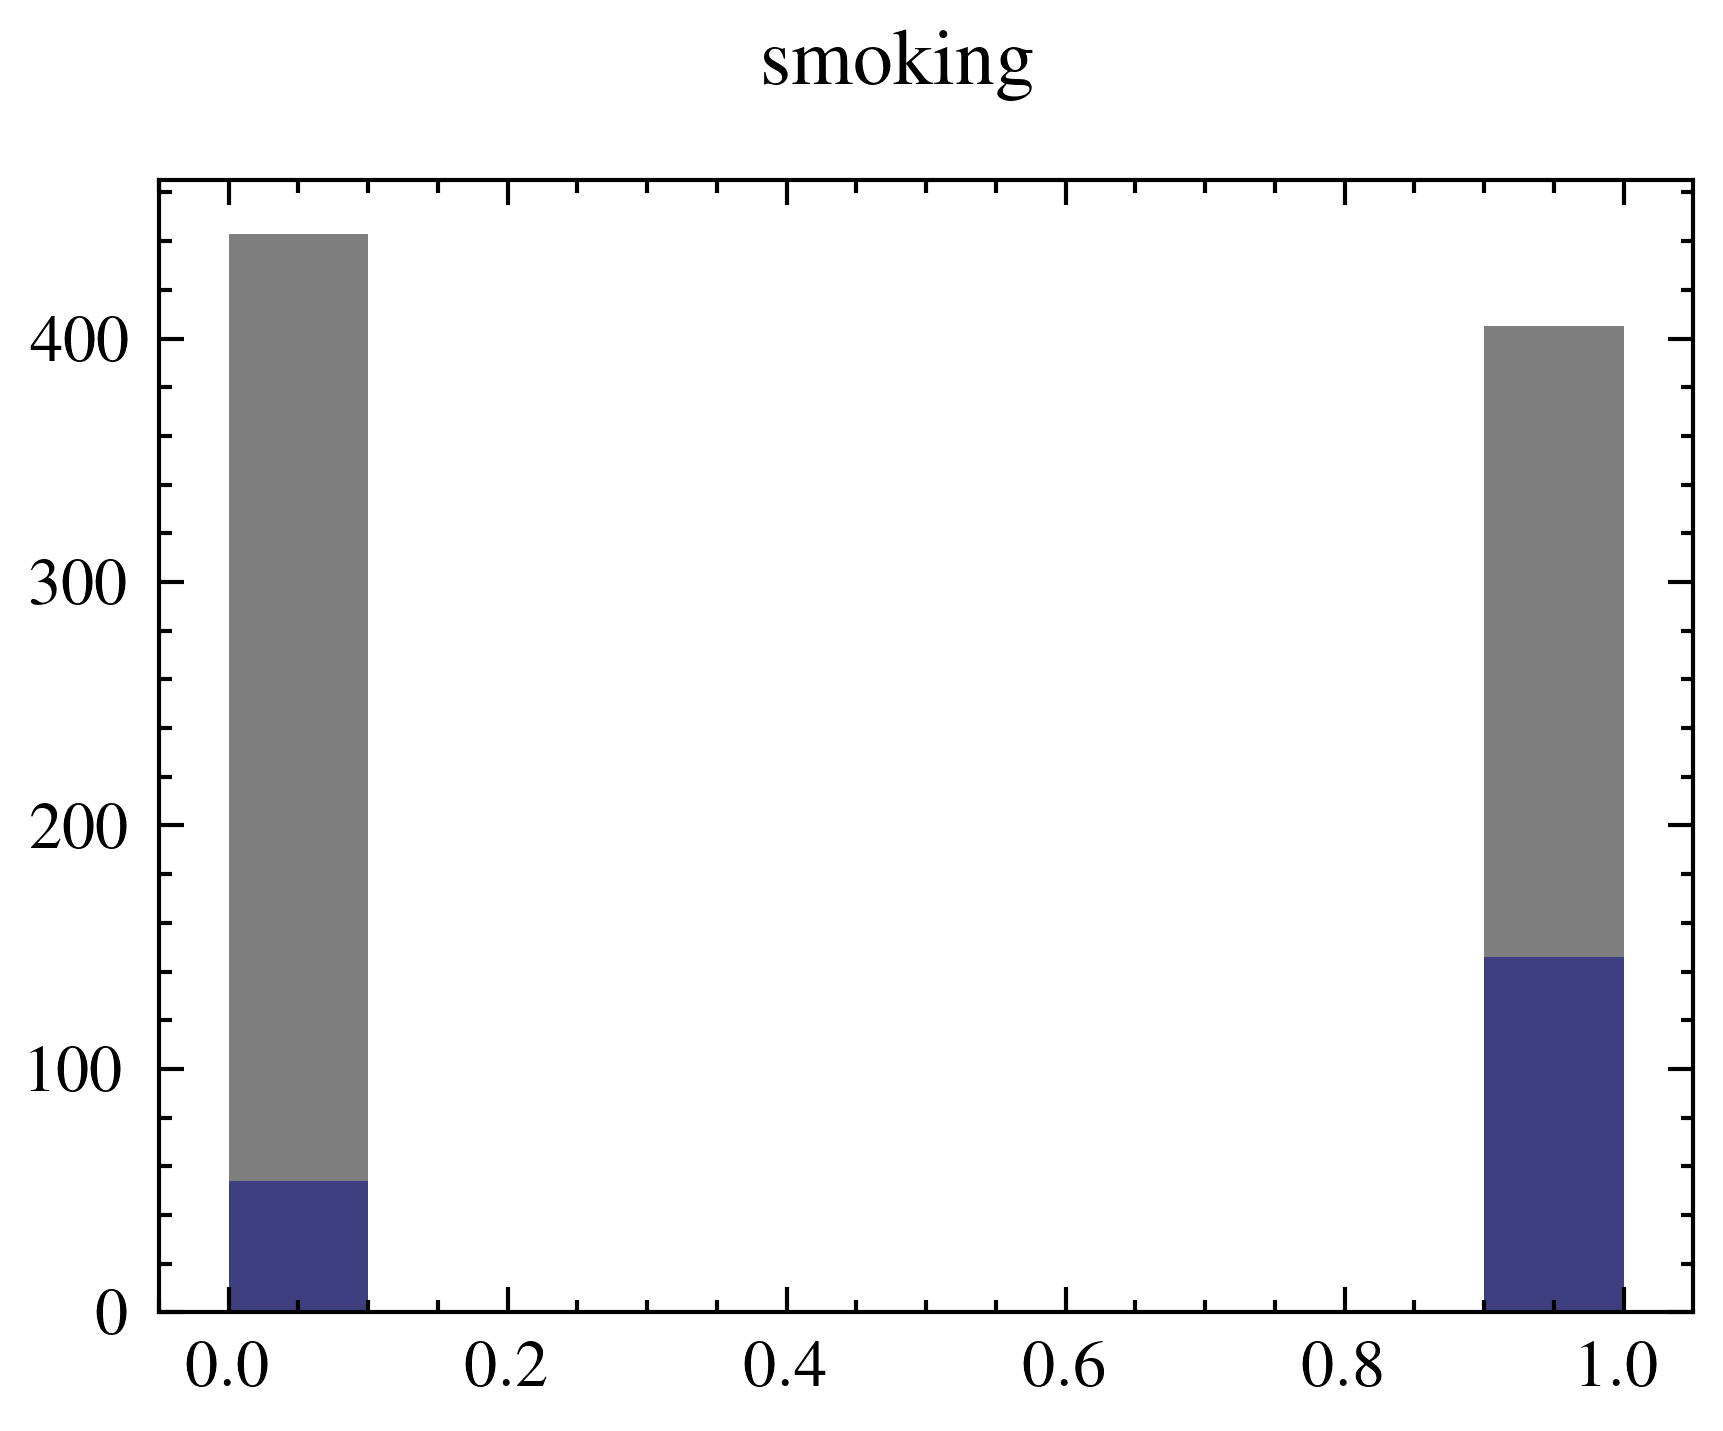

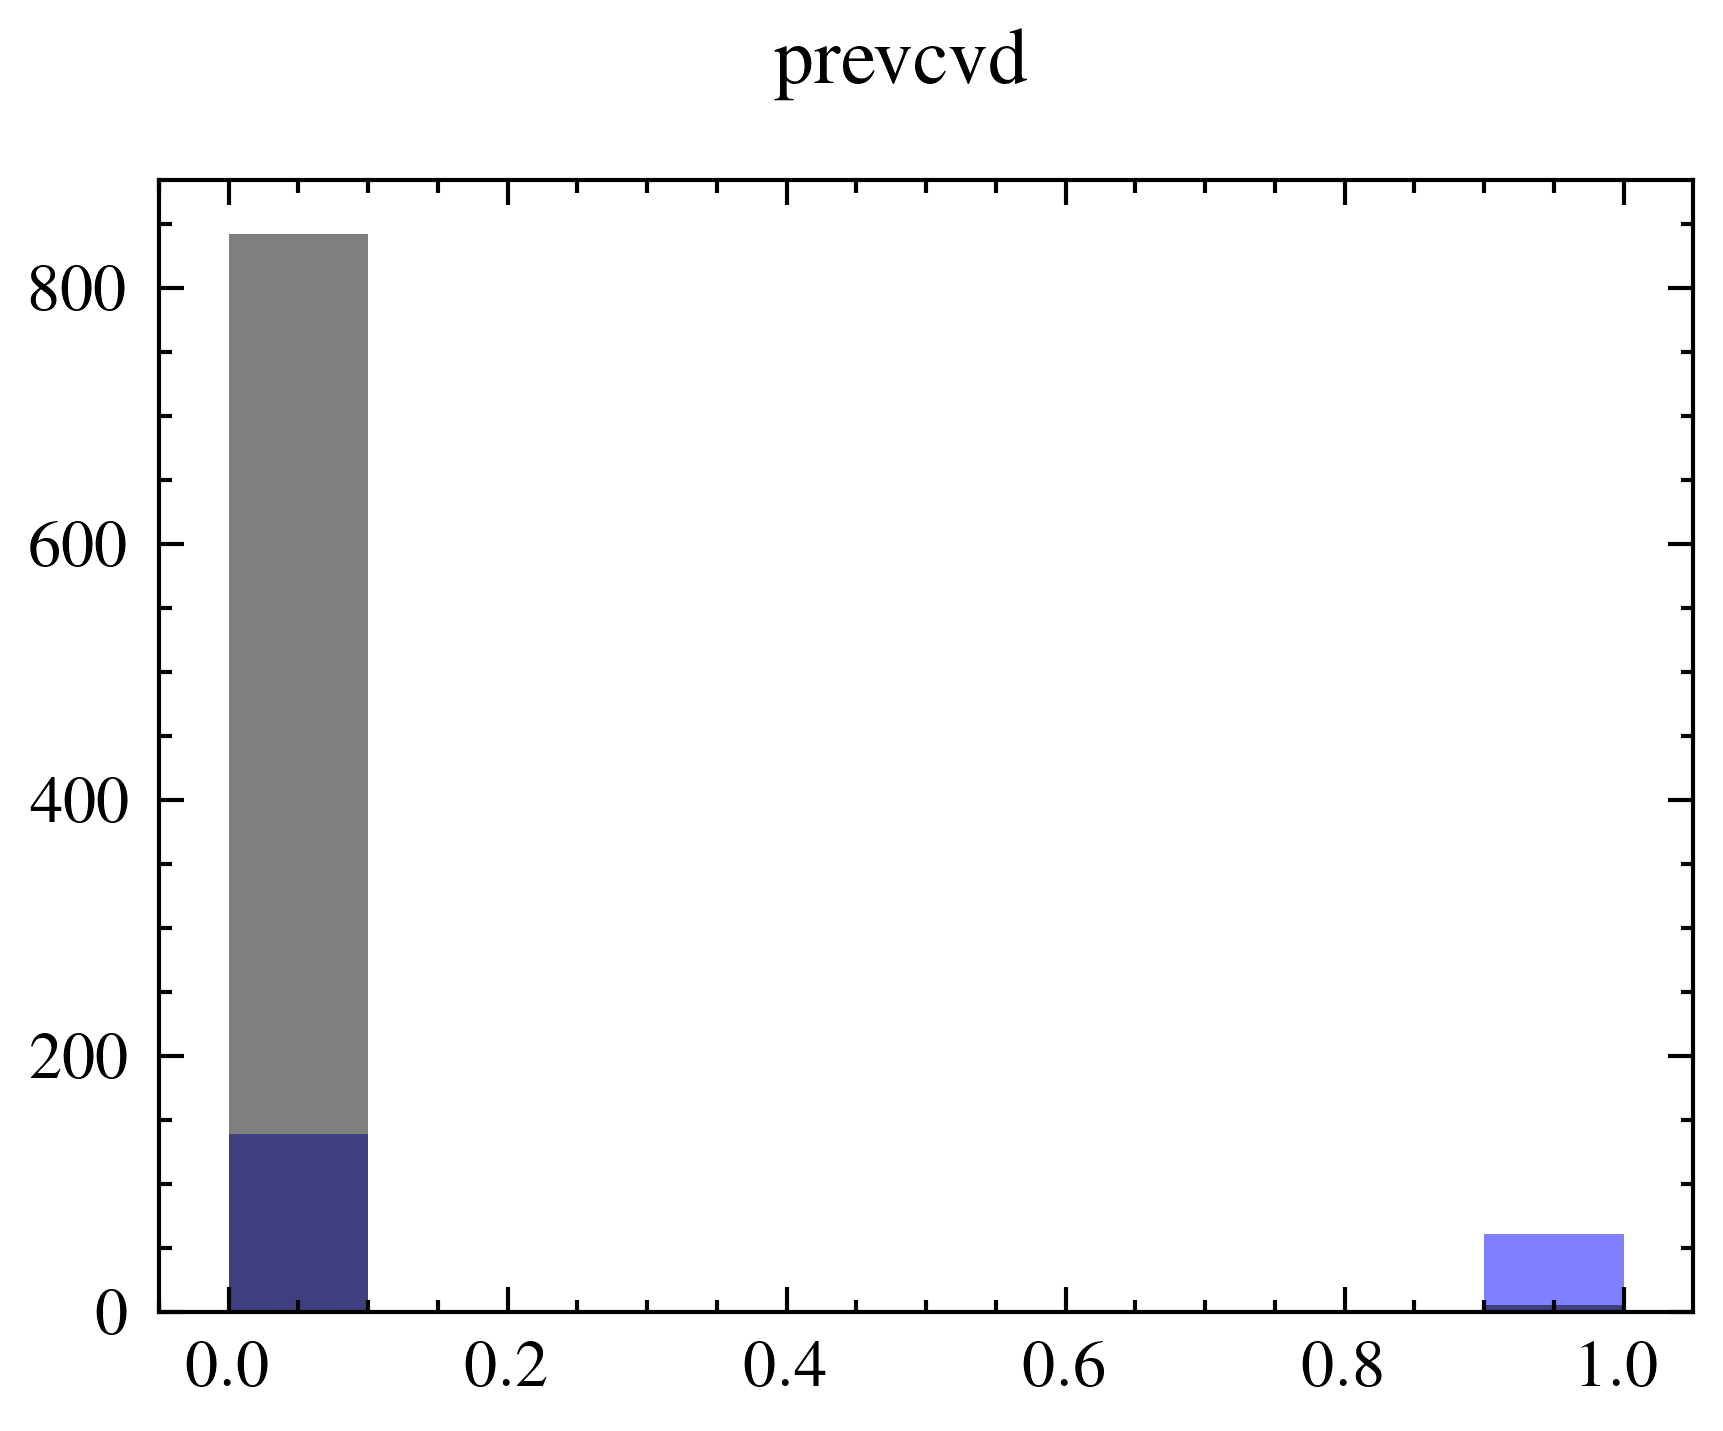

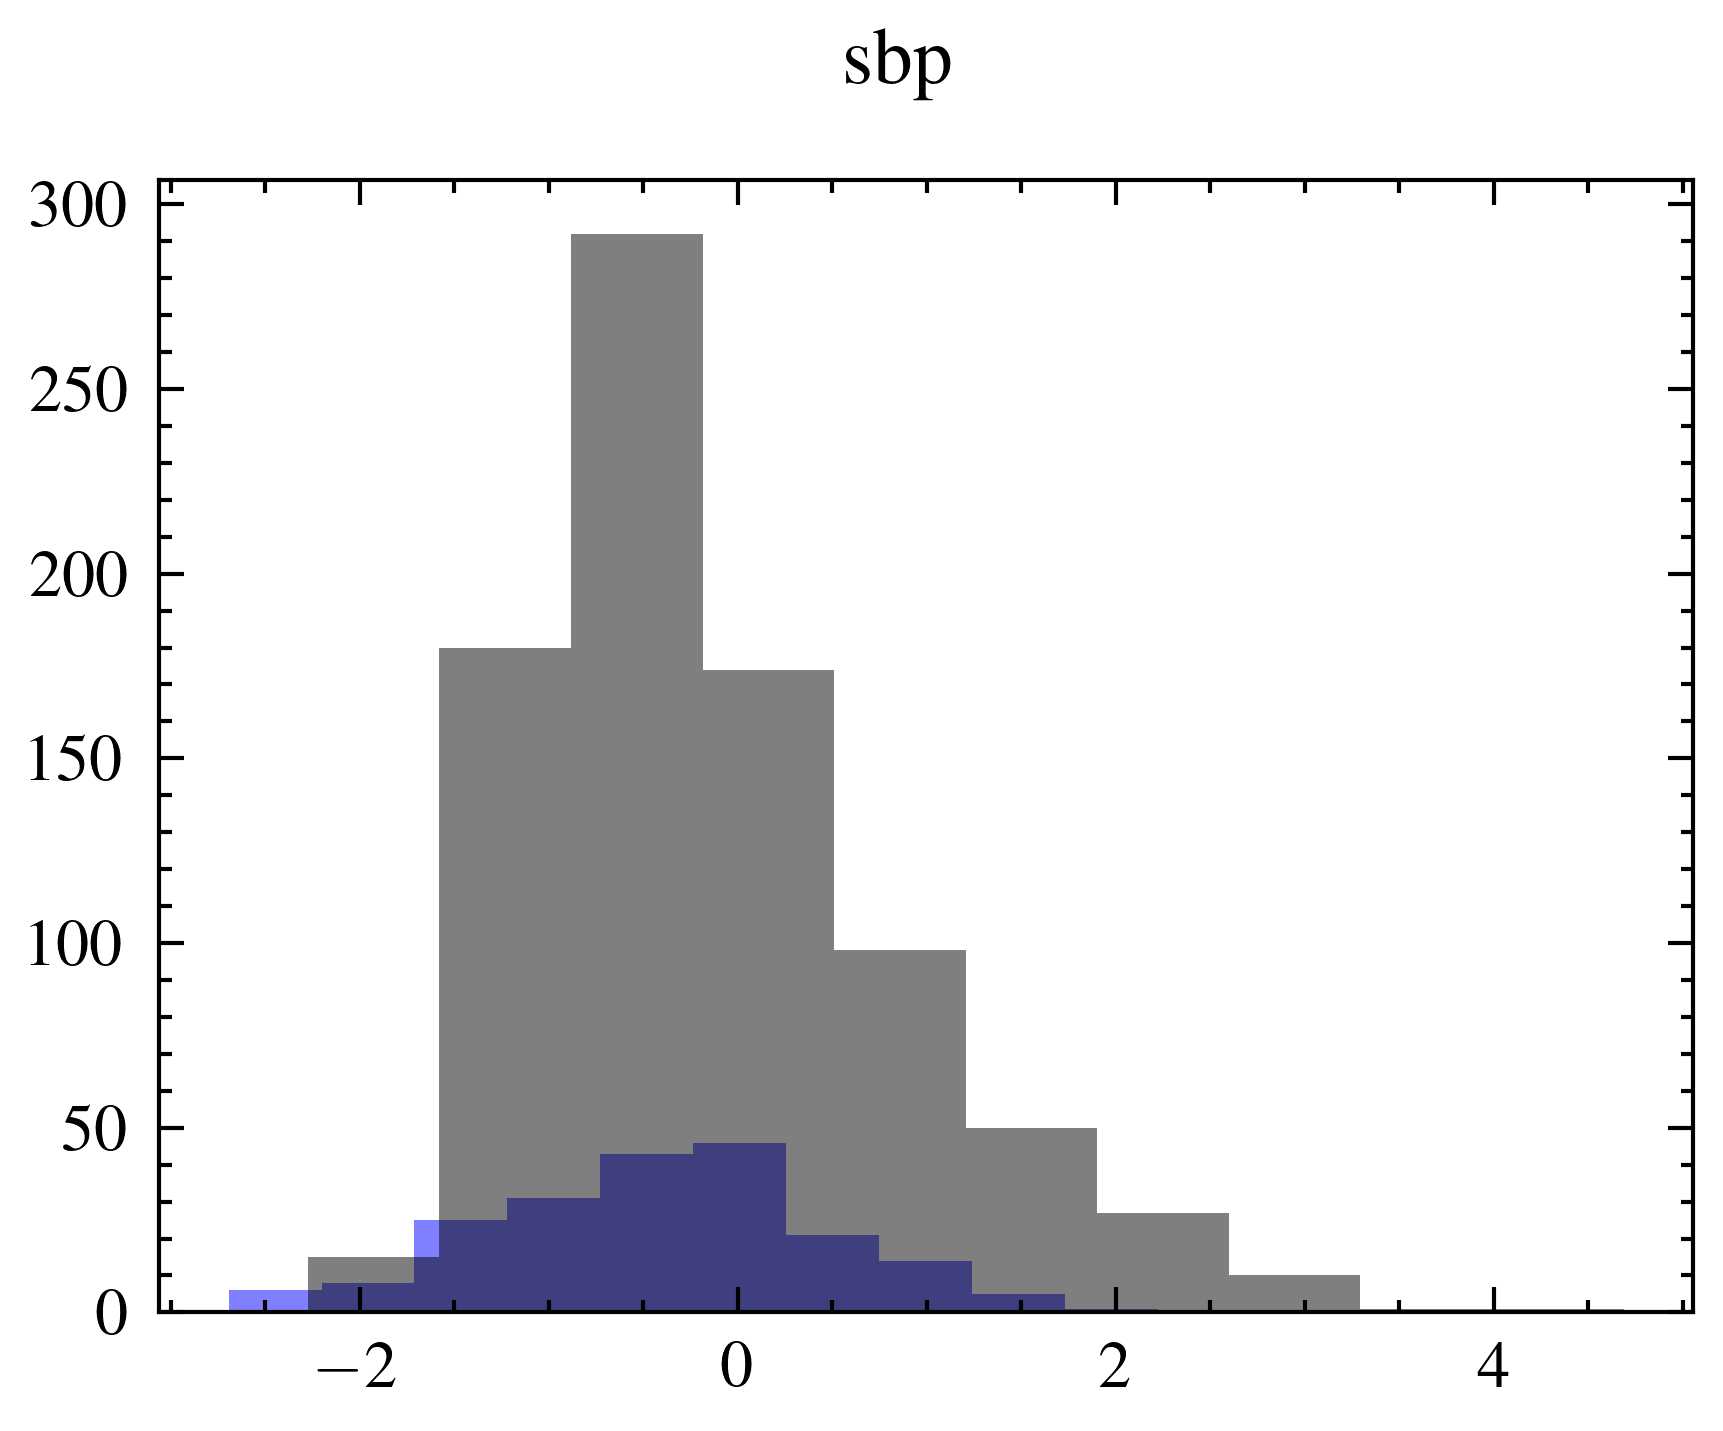

In [19]:
# Distribution comparison of Steno and Frammingham validation datasets in the common features after standardization based on Framingham database
for feat in steno_2common_X_val:
    
    # Figure
    fig, ax = plt.subplots(nrows=1, ncols=1)

    # Set IEEE style
    plt.style.use(['science','ieee'])

    # Set figure title
    fig.suptitle(feat)

    ax.hist(steno_2common_X_val[feat], alpha=0.5, color = 'b', label="", fill=True)
    #ax[0].set_title('Steno')
    ax.hist(fram_2common_X_val[feat],  alpha=0.5, color = 'k', label="", fill=True)
    #ax[1].set_title('Framingham')

    # Set the legend only in the first figure
    if feat == 'sex':
        ax.legend(["Steno", "Frammingham"],loc='upper right')
    
    # Save figure with high resolution 
    fig.savefig(feat + '_val_norm_overlapped.png', dpi=300, bbox_inches='tight')

In [20]:
os.chdir('..')
os.chdir('..')

In [21]:
# Add columns to Steno target variable to perform the classification experiment.

# It is 1 if cvd_risk_10y >= 0.2 and 0 otherwise (according to already established criteria https://steno.shinyapps.io/T1RiskEngine/)
steno_threshold_binary  = 0.2 

# Training set 
# Creation of dummy deep copies, otherwise both columns of dataframe are modified 
a = copy.deepcopy(steno_y_train)
b = copy.deepcopy(steno_y_train)

# Binary classification: add the classification value and assign correspondant value
steno_y_train.insert(1, "Class_label_binary", a, allow_duplicates=False)
steno_y_train.loc[steno_y_train.cvd_risk_10y >= steno_threshold_binary, "Class_label_binary"] = 1
steno_y_train.loc[steno_y_train.cvd_risk_10y < steno_threshold_binary, "Class_label_binary"] = 0

# Validation set 
# Creation of dummy deep copies, otherwise both columns of dataframe are modified 
a = copy.deepcopy(steno_y_val)
b = copy.deepcopy(steno_y_val)

# Binary classification: add the classification value and assign correspondant value
steno_y_val.insert(1, "Class_label_binary", a, allow_duplicates=False)
steno_y_val.loc[steno_y_val.cvd_risk_10y >= steno_threshold_binary, "Class_label_binary"] = 1
steno_y_val.loc[steno_y_val.cvd_risk_10y < steno_threshold_binary, "Class_label_binary"] = 0

In [22]:
#Train 
print("Binary classification - Steno Number of '1' after the conversion setting the threshold to %f: %i\t " % (steno_threshold_binary, steno_y_train.Class_label_binary.value_counts()[1]))
print("Binary classification - Steno Number of '0' after the conversion setting the threshold to %f: %i\t " % (steno_threshold_binary, steno_y_train.Class_label_binary.value_counts()[0]))

print("Binary classification - Steno Number of '1' after the conversion setting the threshold to %f: %i\t" % (steno_threshold_binary, steno_y_val.Class_label_binary.value_counts()[1])) 
print("Binary classification - Steno Number of '0' after the conversion setting the threshold to %f: %i\t" % (steno_threshold_binary, steno_y_val.Class_label_binary.value_counts()[0]))

Binary classification - Steno Number of '1' after the conversion setting the threshold to 0.200000: 264	 
Binary classification - Steno Number of '0' after the conversion setting the threshold to 0.200000: 536	 
Binary classification - Steno Number of '1' after the conversion setting the threshold to 0.200000: 71	
Binary classification - Steno Number of '0' after the conversion setting the threshold to 0.200000: 129	


In [23]:
# Creates and/or goes to the path to store the results 
if not os.path.exists(STORE_PATH):
    os.mkdir(STORE_PATH)
os.chdir(STORE_PATH)

In [24]:
# Classification models 
# SVM 
svm_base = SGDClassifier(loss='hinge', penalty = 'l2', alpha = 0.01, learning_rate = 'constant', eta0 = 1, warm_start = False, random_state = 12345)

# MLP 
perceptron_base = SGDClassifier(loss='perceptron', random_state = 12345, warm_start = False, early_stopping=False, # Early Stopping set to false to partial_fit
            learning_rate = 'constant', eta0 = 0.01, max_iter = 100, shuffle=False)

# Hyperparameters 
svm_params = {
            'alpha': [0.00001, 0.0001, 0.5, 1],
            "learning_rate" : ['constant', 'adaptive'],
            "eta0" : [0.0001, 0.001, 0.01, 0.1, 1.0],
              }


perc_params = {"tol" : [1e-4, 1e-3, 1e-2, 1e-1],
            "learning_rate" : ['constant', 'adaptive'],
             "eta0" : [0.0001, 0.001, 0.01, 0.1, 1.0],
             "power_t" : [0.5, 0.75, 0.9, 0.95, 0.99]
            }


In [25]:
# First Training phase: find the optimal hyperparameters for this models trained with Framingham datasets
SVM_model_steno, SVM_train_results_steno, SVM_cv_results_steno, SVM_best_params  = train_classifier(svm_base, svm_params, "SVM", "Steno Classification (5 common)", fram_2common_X_train.to_numpy(), np.ravel(fram_y_train['TenYearCHD']), cv = 10, scoring = 'roc_auc')
perc_model_steno, perc_train_results_steno, perc_cv_results_steno, perc_best_params  = train_classifier(perceptron_base, perc_params, "Perceptron", "Steno Classification (5 common)", fram_2common_X_train.to_numpy(), np.ravel(fram_y_train['TenYearCHD']), cv = 10, scoring = 'roc_auc')

SVM :  Steno Classification (5 common)  ->  roc_auc on training set is 0.6835687670140299 ( 0.10364808028989601 )
Perceptron :  Steno Classification (5 common)  ->  roc_auc on training set is 0.5896591885209809 ( 0.1128648920334115 )


In [26]:
# Models with the best parameters to be trained with both datasets 
svm_prev = SGDClassifier(loss='hinge', penalty = 'l2' , warm_start = False, random_state = 12345, **SVM_best_params) # Early Stopping set to false to partial_fit
perceptron_prev = SGDClassifier(loss='perceptron', random_state = 12345, warm_start = False, early_stopping=False, 
            max_iter = 100, **perc_best_params)


In [27]:
# Parameters are not stored properly. This is done manually (after the execution of the previous cell)
svm_prev = SGDClassifier(loss='hinge', penalty = 'l2' , warm_start = False, random_state = 12345,
                        alpha= 0.5,
                        eta0= 0.001,
                        learning_rate= 'constant') # Early Stopping set to false to partial_fit
perceptron_prev = SGDClassifier(loss='perceptron', random_state = 12345, warm_start = False, early_stopping=False, max_iter = 100,
                        eta0 = 1.0,
                        learning_rate =  'constant',
                        power_t =  0.5,
                        tol =  0.01)


In [28]:
# Partial fit just iterate once through the training set, so 10 times with Cross Validation are performed
# Frammingham iterations 
fram_iterations = 10

# Framingham repetitions
fram_repetitions = 1

# Declare a StratifiedKFold object with 10 folds
skf = StratifiedKFold(n_splits = fram_iterations, shuffle = True, random_state = 12345)

# For simplicity of code
X = fram_2common_X_train.to_numpy()
y = np.ravel(fram_y_train['TenYearCHD'])

# Current model 
curr_perc_model = perceptron_prev
curr_svm_model = svm_prev

# Empty list to store the results of the 10 iterations
fram_perc_train_results = []
fram_svm_train_results = []

i = 0

for train_index, test_index in skf.split(X, y):
    
    i = i + 1

    # Print number of iteration out of total 
    print("Iteration %i of %i..." % (i, fram_iterations*fram_repetitions))

    # Extract the training and test set for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model for this fold
    perc_pretrained = curr_perc_model.partial_fit(X_train, y_train, classes=np.unique(steno_y_train['Class_label_binary']))
    svm_pretrained = curr_svm_model.partial_fit(X_train, y_train, classes=np.unique(steno_y_train['Class_label_binary']))

    # Predict the test set
    y_perc_pred = perc_pretrained.predict(X_test)
    y_svm_pred = svm_pretrained.predict(X_test)

    # Test the model for this fold 
    perc_auc = roc_auc_score(y_test, y_perc_pred)
    svm_auc = roc_auc_score(y_test, y_svm_pred)

    # Append the results to the list
    fram_perc_train_results.append(y_perc_pred)
    fram_svm_train_results.append(y_svm_pred)
    
    # Update current model 
    curr_perc_model = perc_pretrained

Iteration 1 of 10...
Iteration 2 of 10...
Iteration 3 of 10...
Iteration 4 of 10...
Iteration 5 of 10...
Iteration 6 of 10...
Iteration 7 of 10...
Iteration 8 of 10...
Iteration 9 of 10...
Iteration 10 of 10...


SVM - Steno Only 5 common -> ACC: 0.805000 || AUC: 0.905121 || F1-score: 0.745098 || Recall: 0.802817 || Precision: 0.695122
SVM - Frammingham Only 5 common -> ACC: 0.633255 || AUC: 0.676046 || F1-score: 0.339703 || Recall: 0.610687 || Precision: 0.235294
Perceptron before Incr. training - Steno Only 5 common -> ACC: 0.800000 || AUC: 0.888962 || F1-score: 0.733333 || Recall: 0.774648 || Precision: 0.696203
Perceptron before Incr. training - Frammingham Only 5 common -> ACC: 0.580189 || AUC: 0.593674 || F1-score: 0.270492 || Recall: 0.503817 || Precision: 0.184874


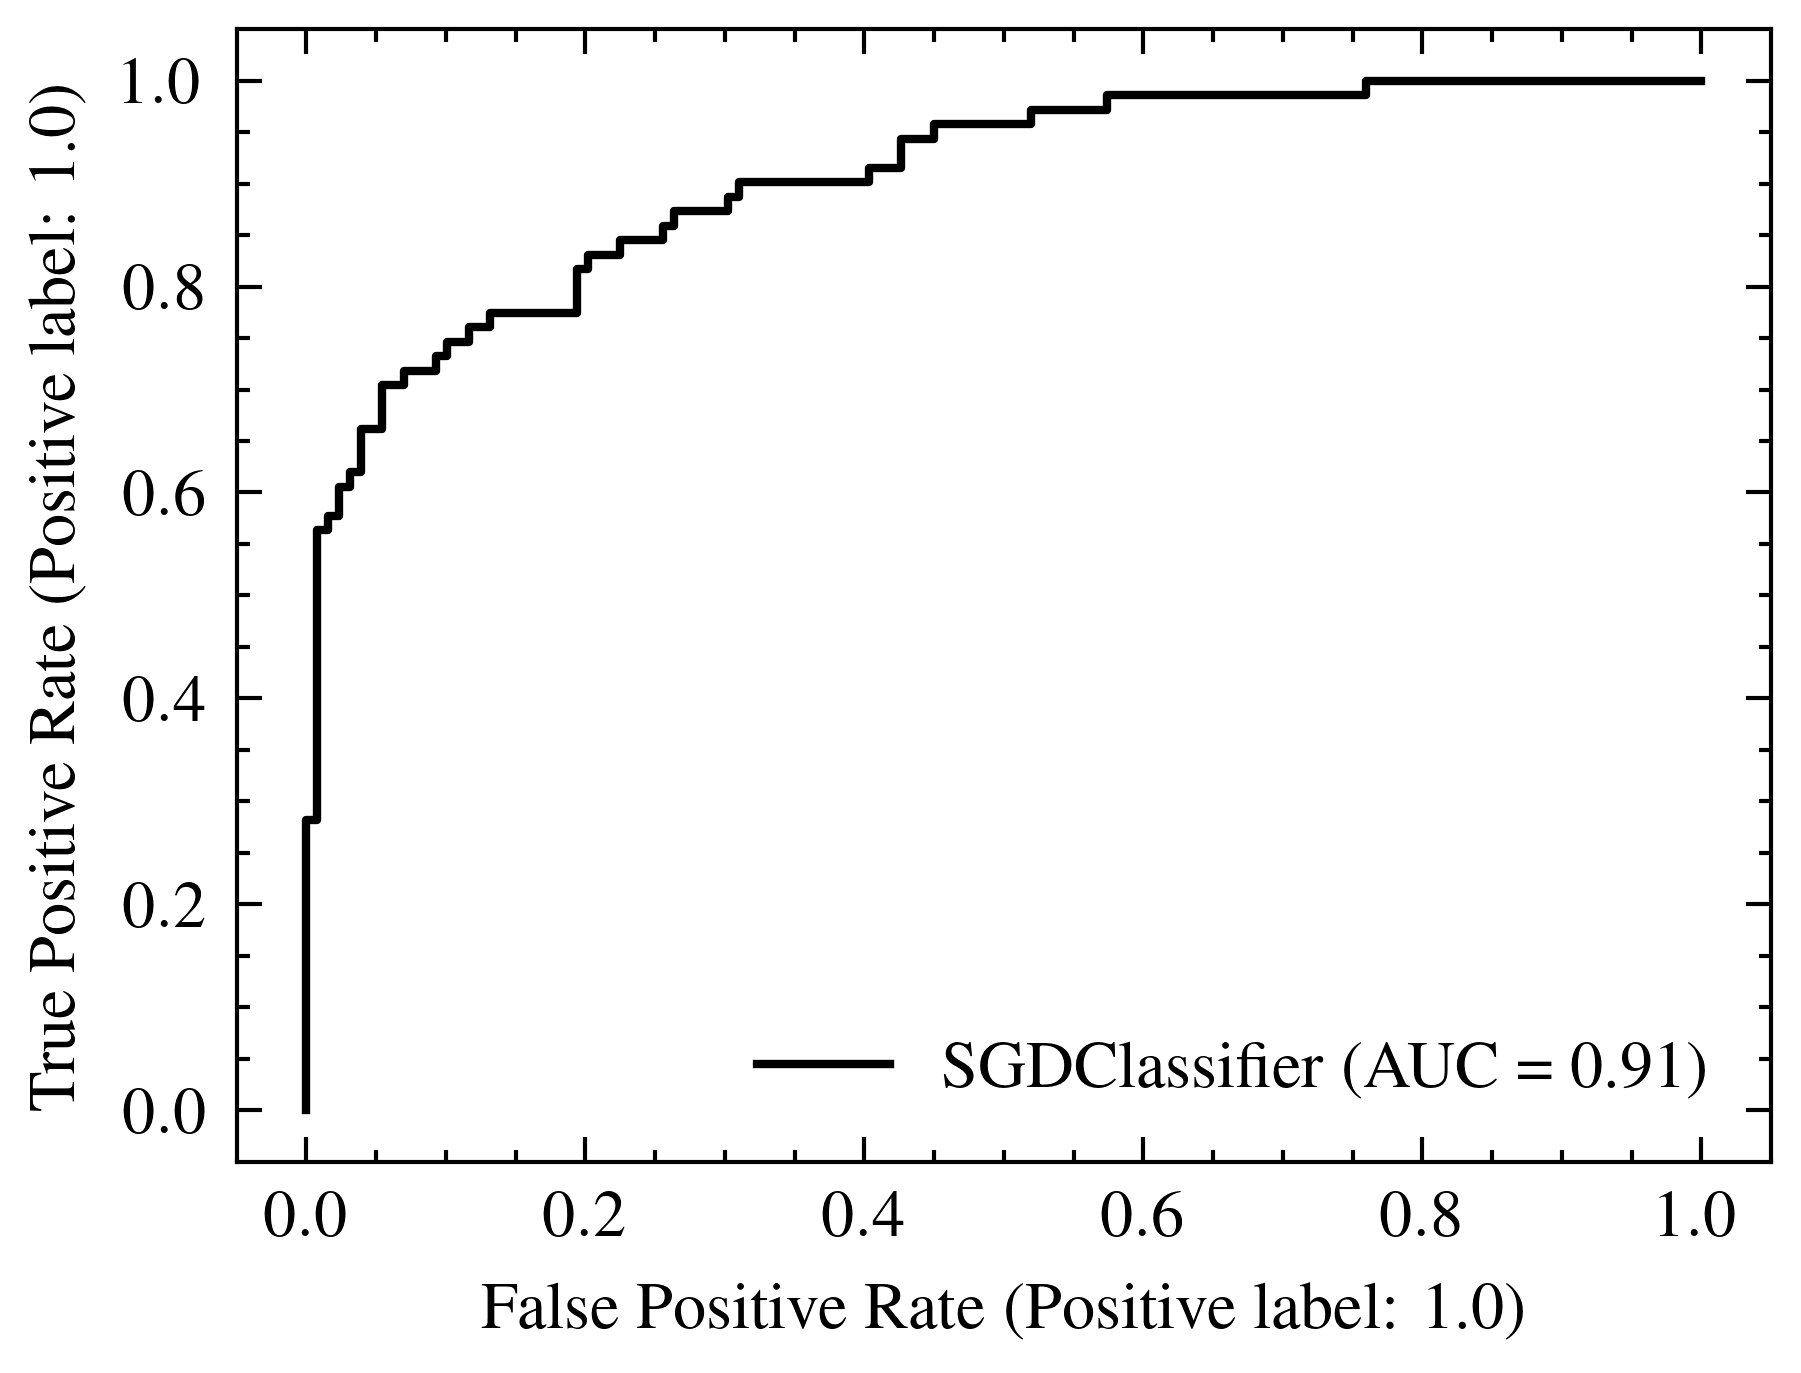

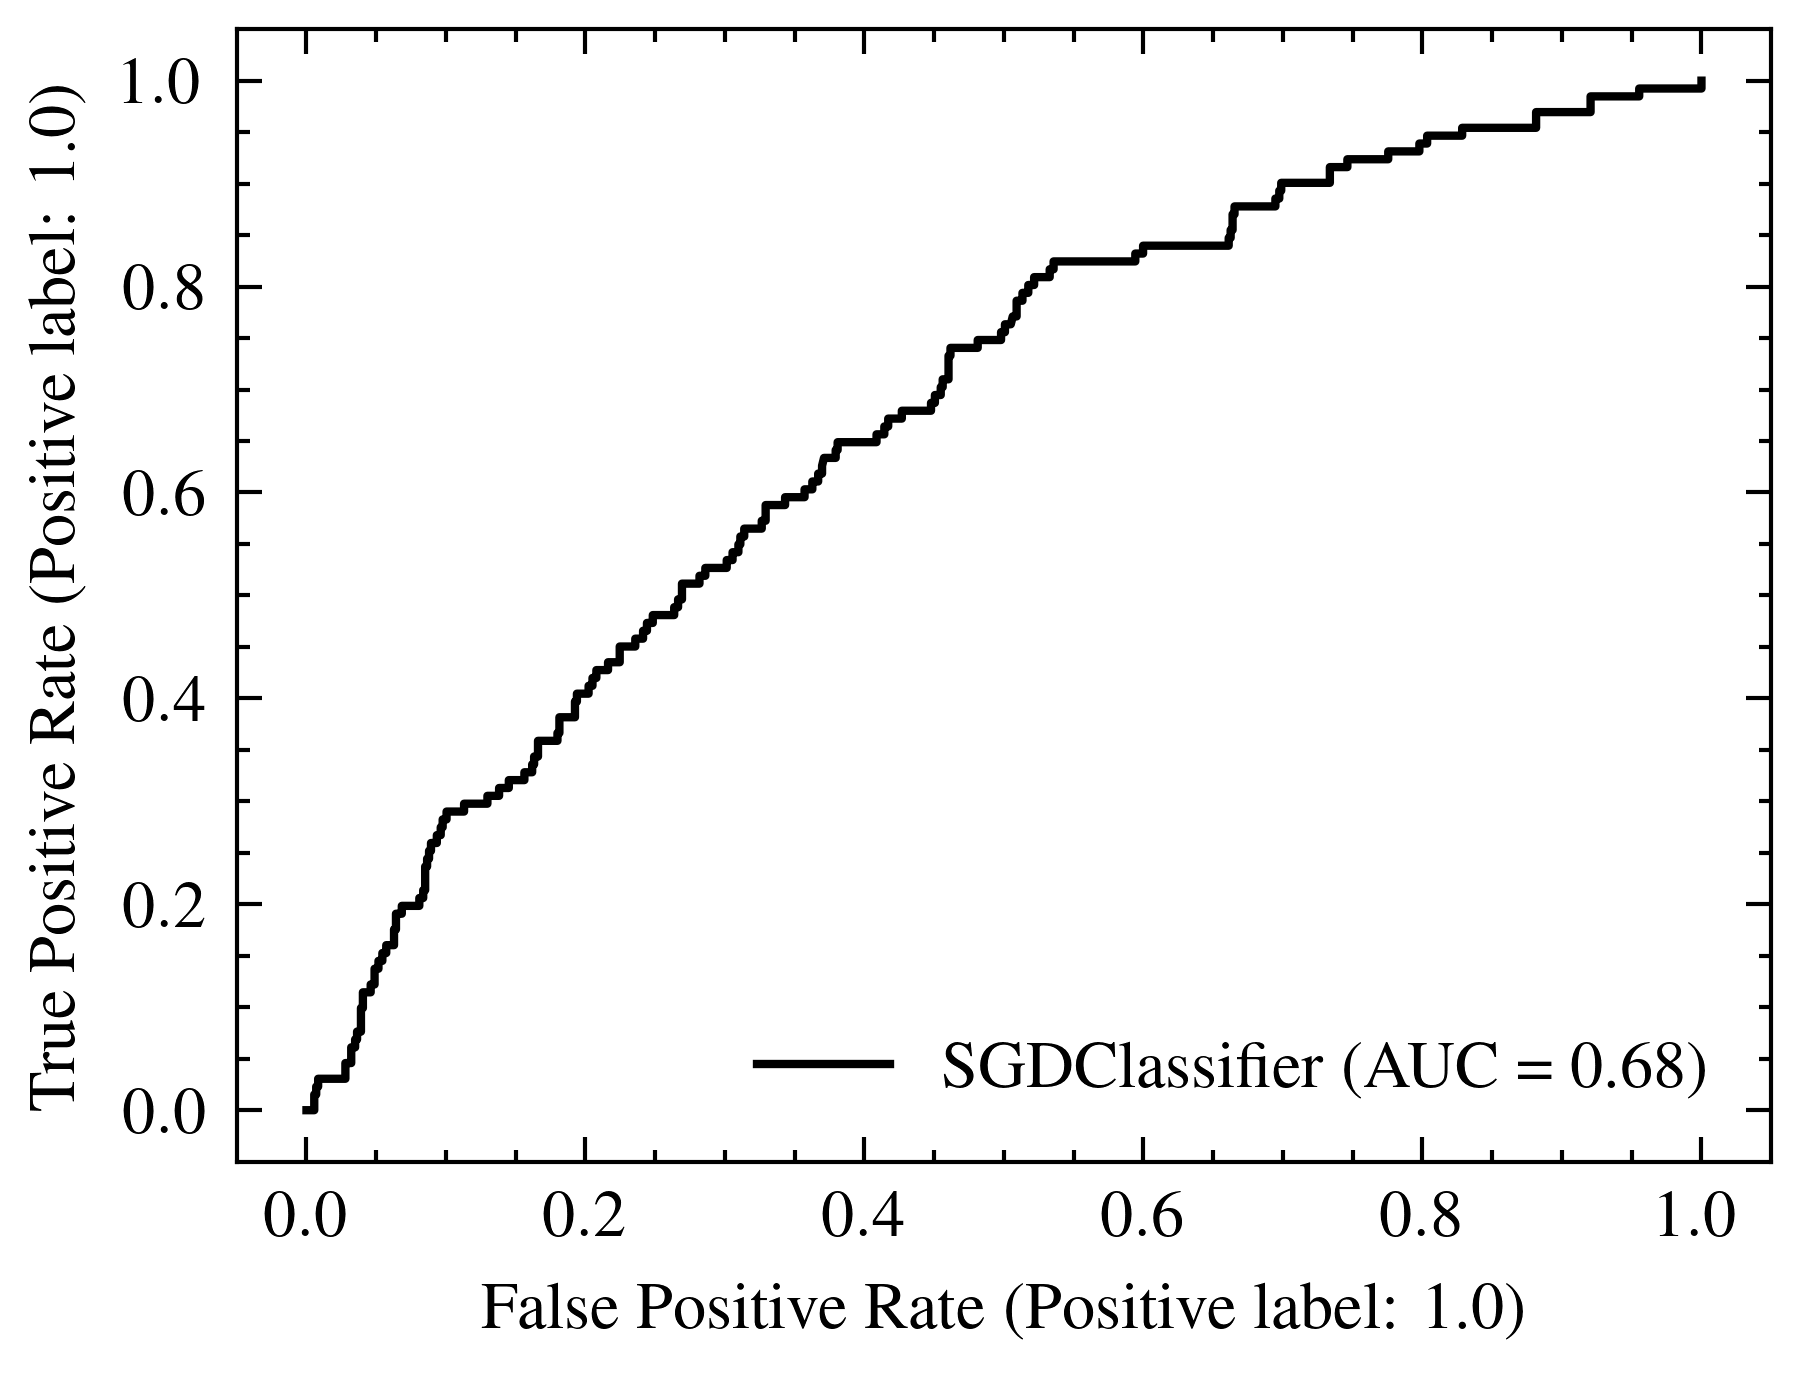

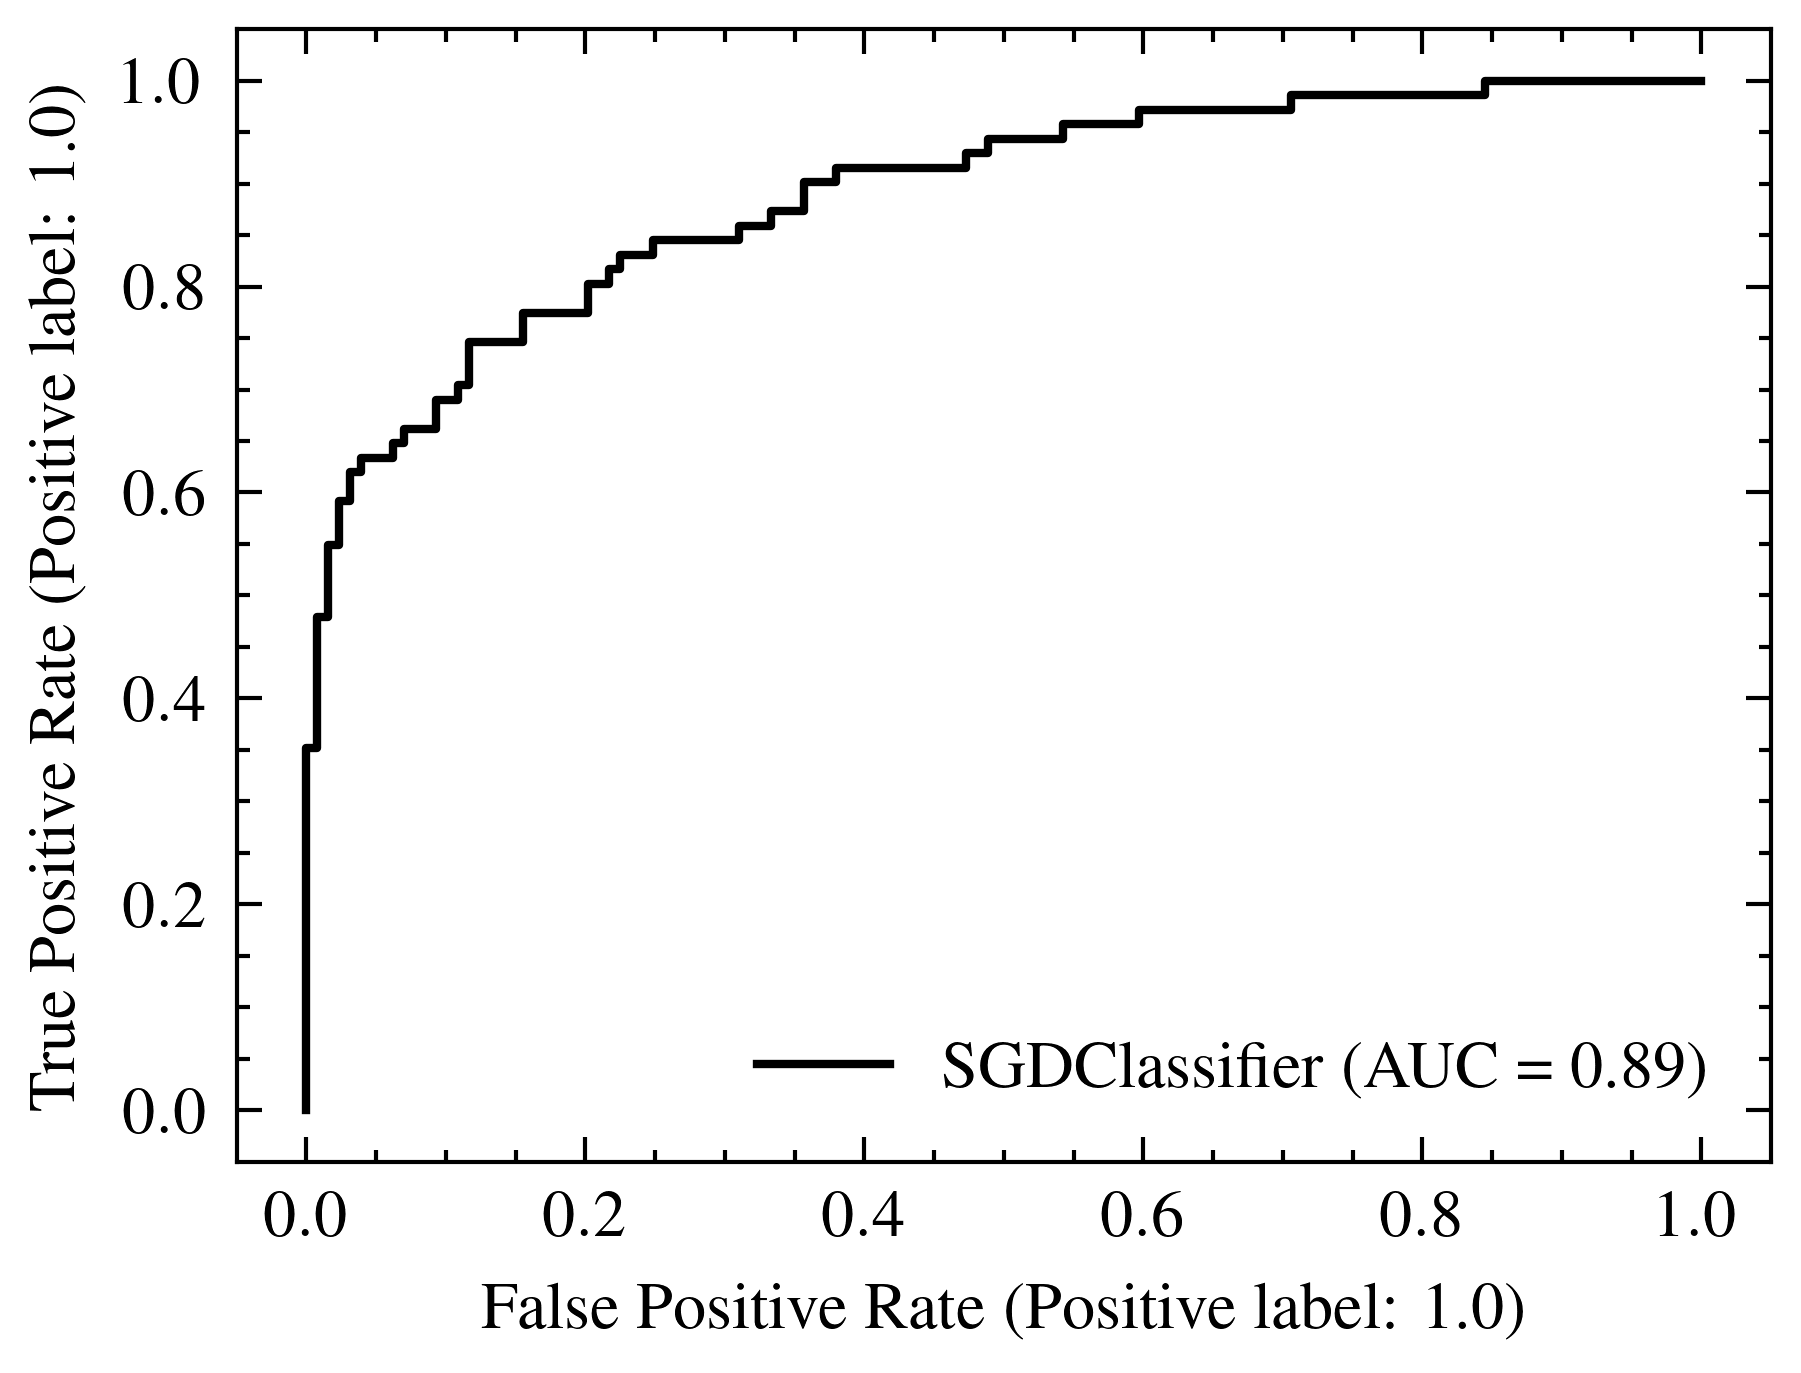

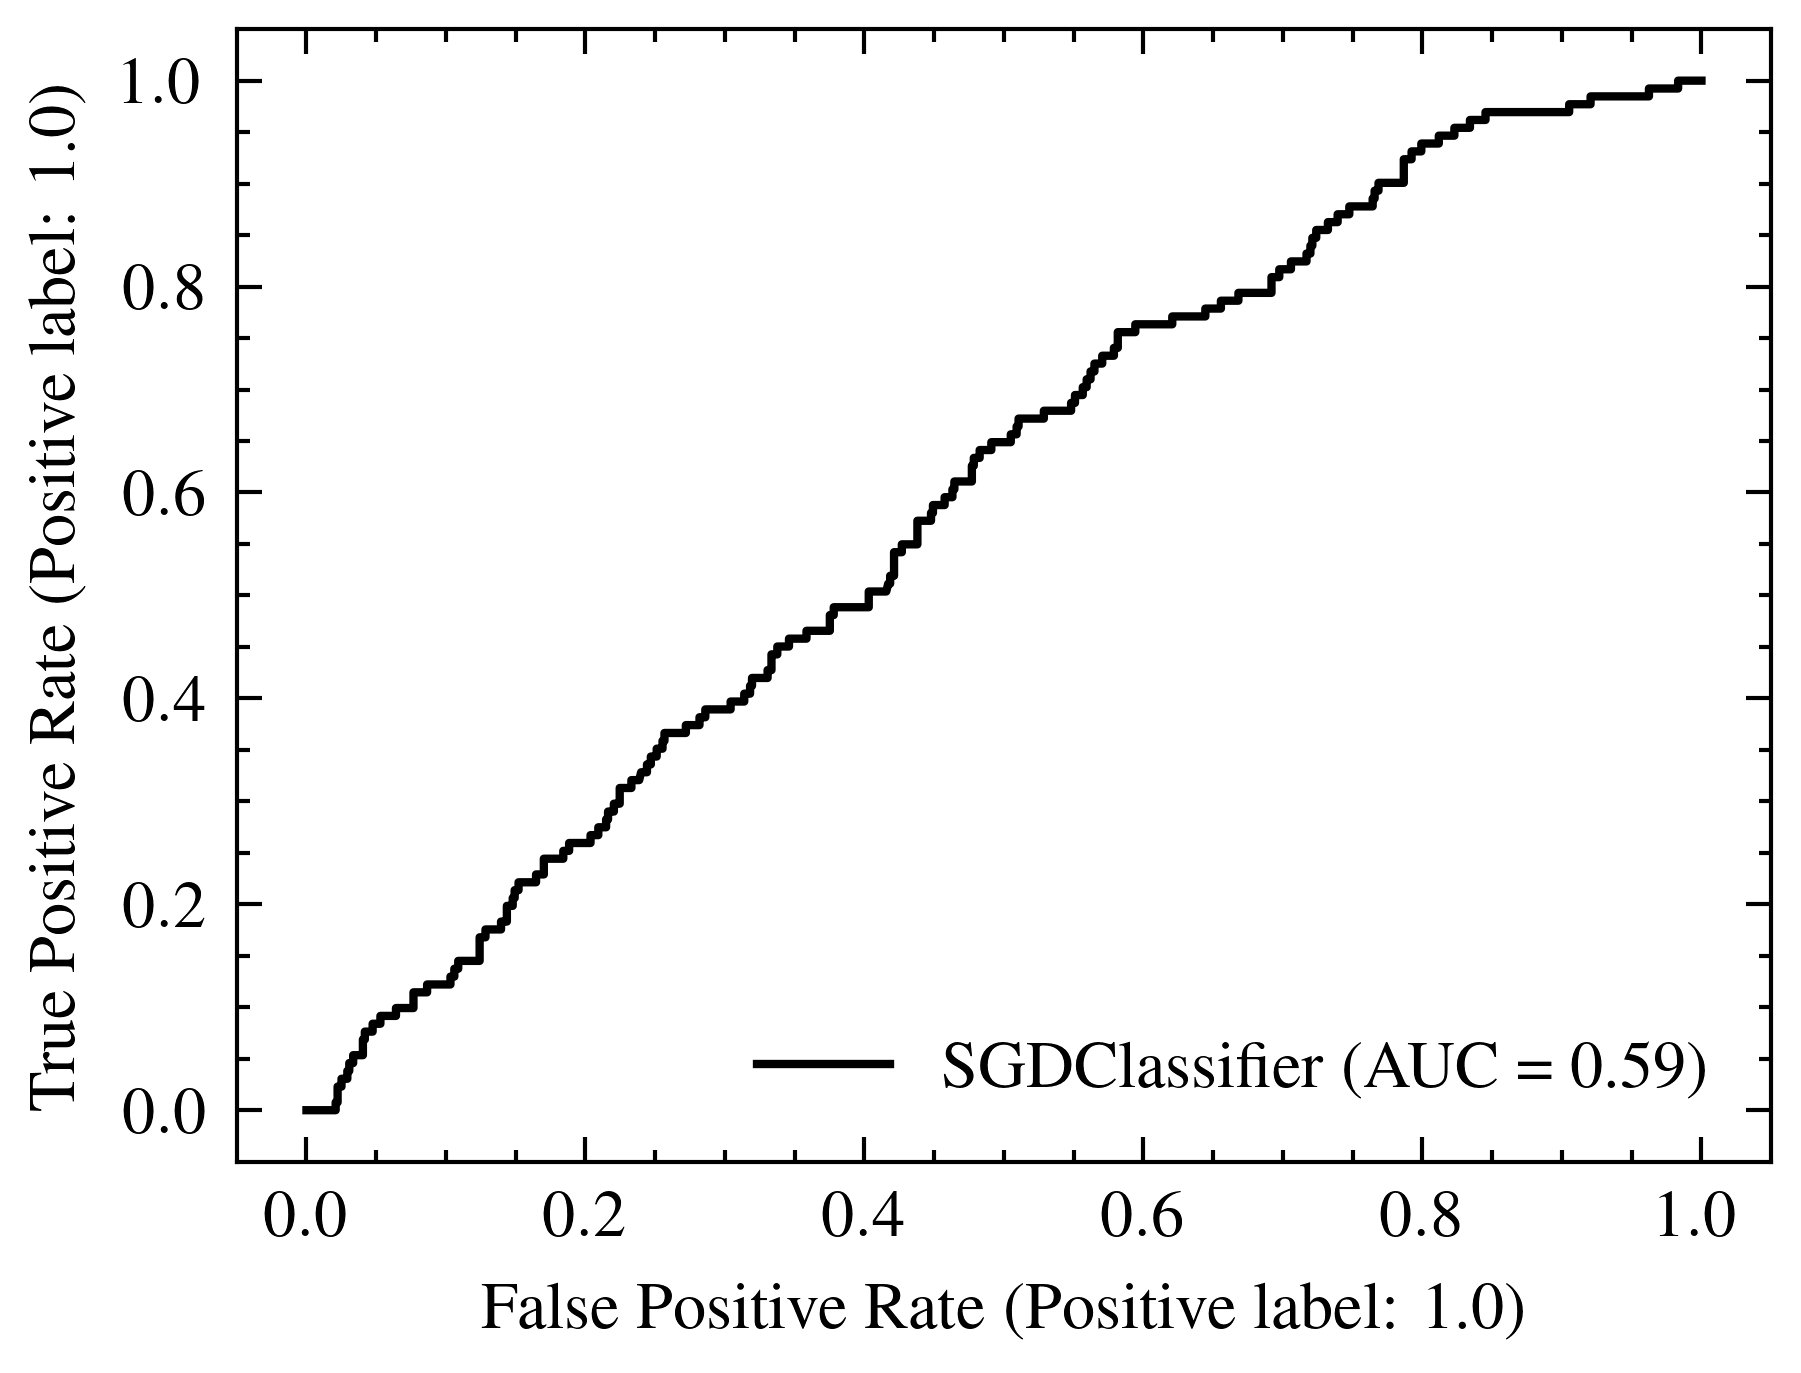

In [29]:
# Model validation before incremental training (SVM)
steno_acc_SVM_prev, steno_auc_SVM_prev, f1_steno_SVM_prev, recall_steno_SVM_prev, prec_steno_SVM_prev= perc_clas_eval(svm_pretrained, steno_2common_X_val.to_numpy(), steno_y_val['Class_label_binary'])
print("SVM - Steno Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (steno_acc_SVM_prev, steno_auc_SVM_prev, f1_steno_SVM_prev, recall_steno_SVM_prev, prec_steno_SVM_prev))
fram_acc_SVM_prev, fram_auc_SVM_prev, f1_fram_SVM_prev, recall_fram_SVM_prev, prec_fram_SVM_prev = perc_clas_eval(svm_pretrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'])
print("SVM - Frammingham Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (fram_acc_SVM_prev, fram_auc_SVM_prev, f1_fram_SVM_prev, recall_fram_SVM_prev, prec_fram_SVM_prev))

# Save results in an Excel file 
results = pd.DataFrame({'ACC': [steno_acc_SVM_prev, fram_acc_SVM_prev], 'AUC': [steno_auc_SVM_prev, fram_auc_SVM_prev], 'F1-score': [f1_steno_SVM_prev, f1_fram_SVM_prev], 'Recall': [recall_steno_SVM_prev, recall_fram_SVM_prev], 'Precision': [prec_steno_SVM_prev, prec_fram_SVM_prev]}, index = ['Steno Only 5 common', 'Frammingham Only 5 common'])
results.to_excel("SVM_pre-training_Steno_and_Frammingham_5_common.xlsx")

# Model validation before incremental training (Perceptron)
steno_acc_perc_prev, steno_auc_perc_prev, f1_steno_perc_prev, recall_steno_perc_prev, prec_steno_perc_prev = perc_clas_eval(perc_pretrained, steno_2common_X_val.to_numpy(), steno_y_val['Class_label_binary'])
print("Perceptron before Incr. training - Steno Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (steno_acc_perc_prev, steno_auc_perc_prev, f1_steno_perc_prev,  recall_steno_perc_prev, prec_steno_perc_prev))
fram_acc_perc_prev, fram_auc_perc_prev, f1_fram_perc_prev, recall_fram_perc_prev, prec_fram_perc_prev = perc_clas_eval(perc_pretrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'])
print("Perceptron before Incr. training - Frammingham Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (fram_acc_perc_prev, fram_auc_perc_prev, f1_fram_perc_prev, recall_fram_perc_prev, prec_fram_perc_prev))

# Save results in an Excel file
results = pd.DataFrame({'ACC': [steno_acc_perc_prev, fram_acc_perc_prev], 'AUC': [steno_auc_perc_prev, fram_auc_perc_prev], 'F1-score': [f1_steno_perc_prev, f1_fram_perc_prev], 'Recall': [recall_steno_perc_prev, recall_fram_perc_prev], 'Precision': [prec_steno_perc_prev, prec_fram_perc_prev]}, index = ['Steno Only 5 common', 'Frammingham Only 5 common'])
results.to_excel("Perceptron_pre-training_Steno_and_Frammingham_5_common.xlsx")

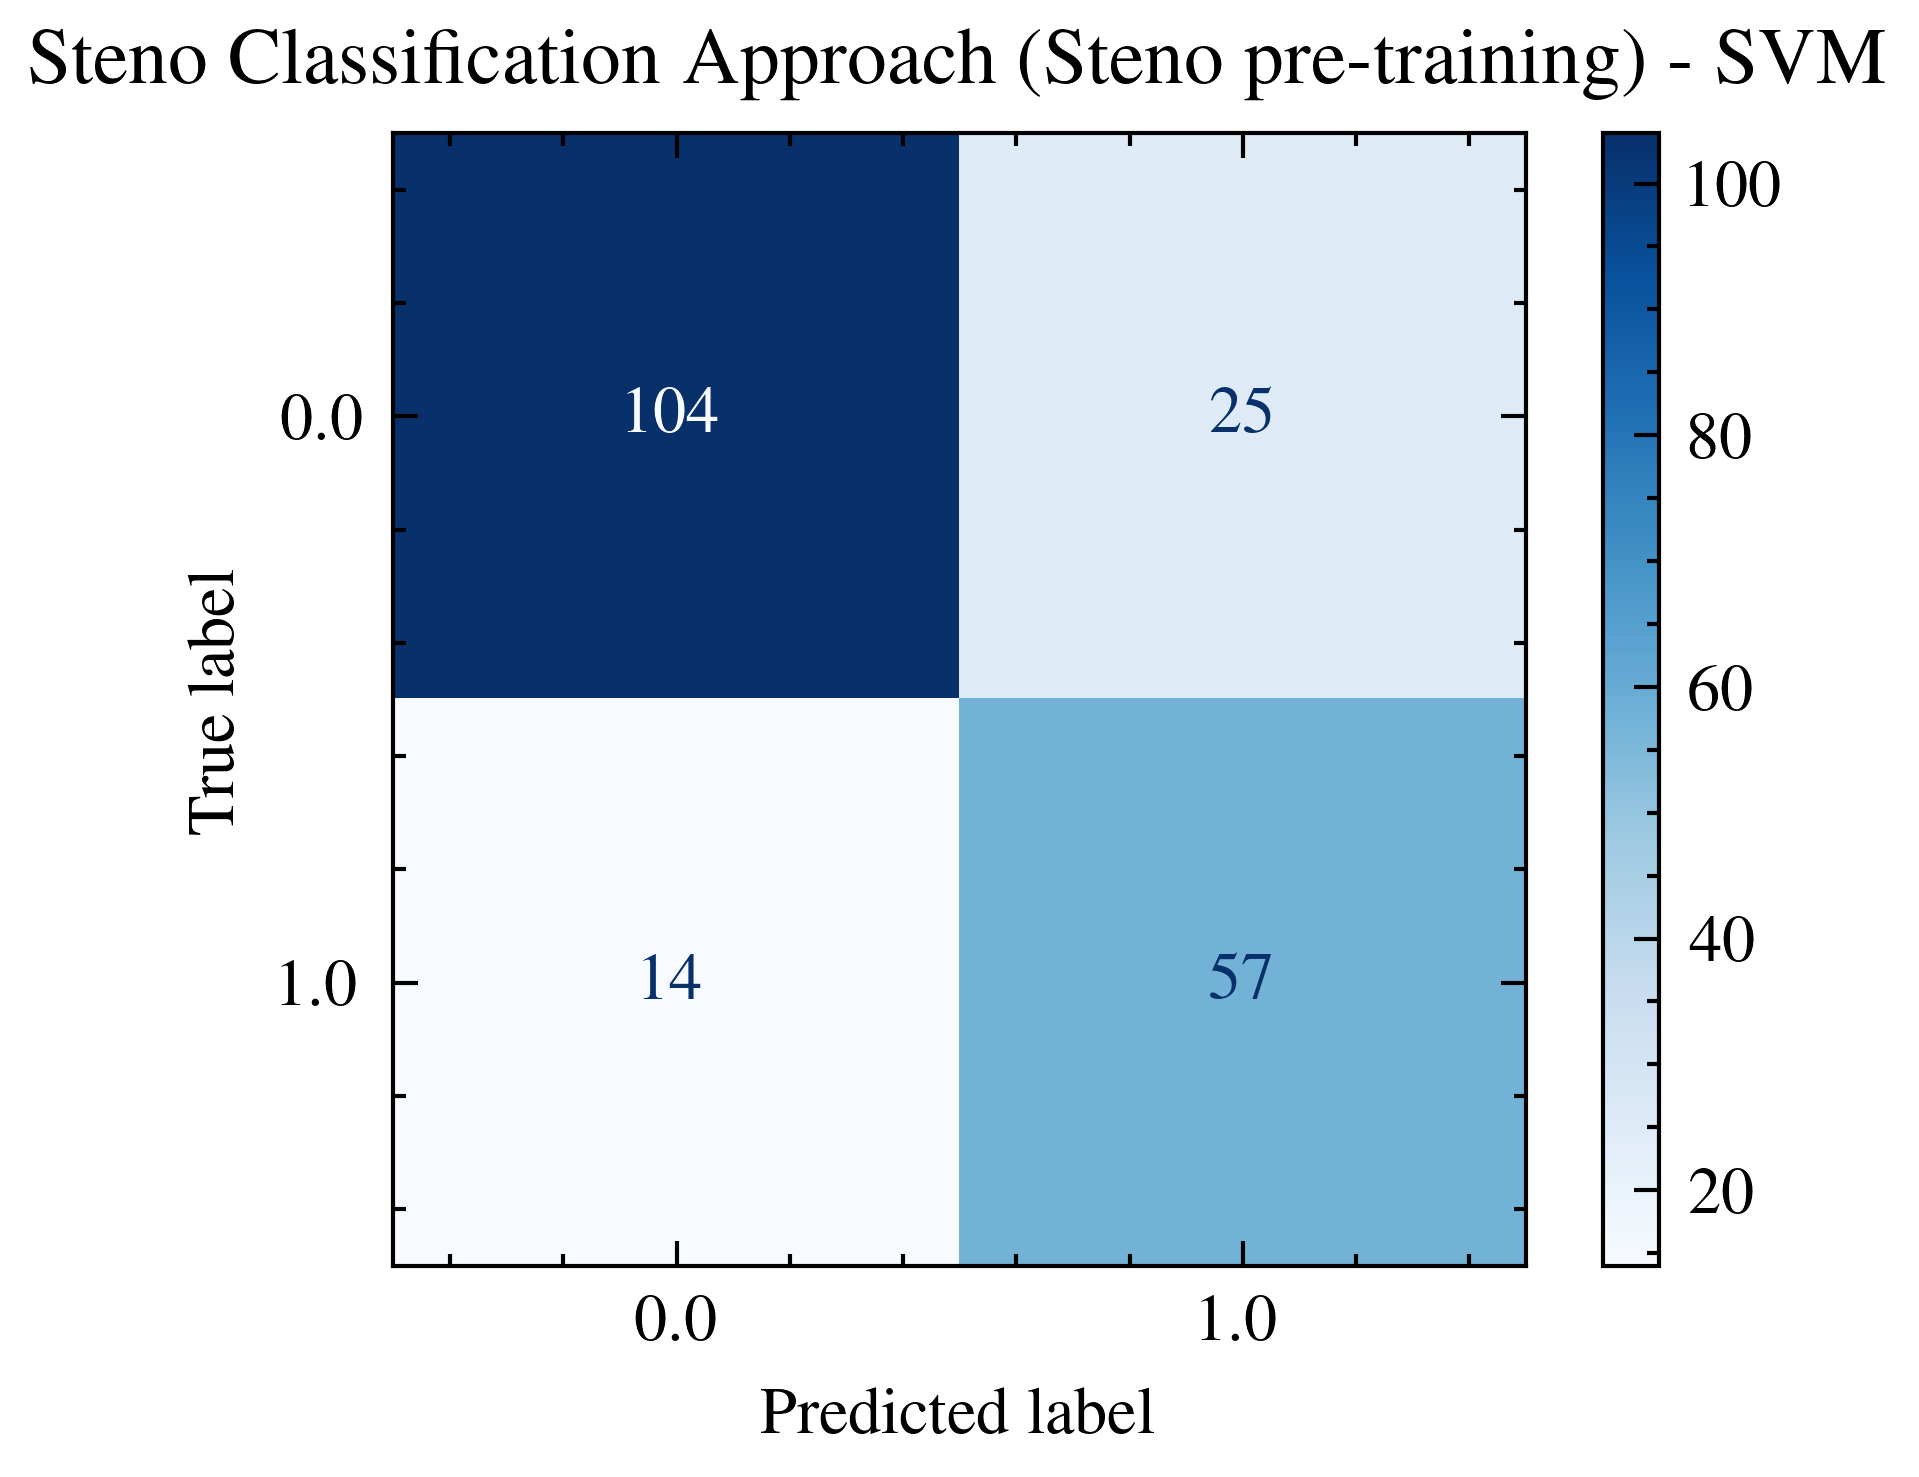

<Figure size 1980x1500 with 0 Axes>

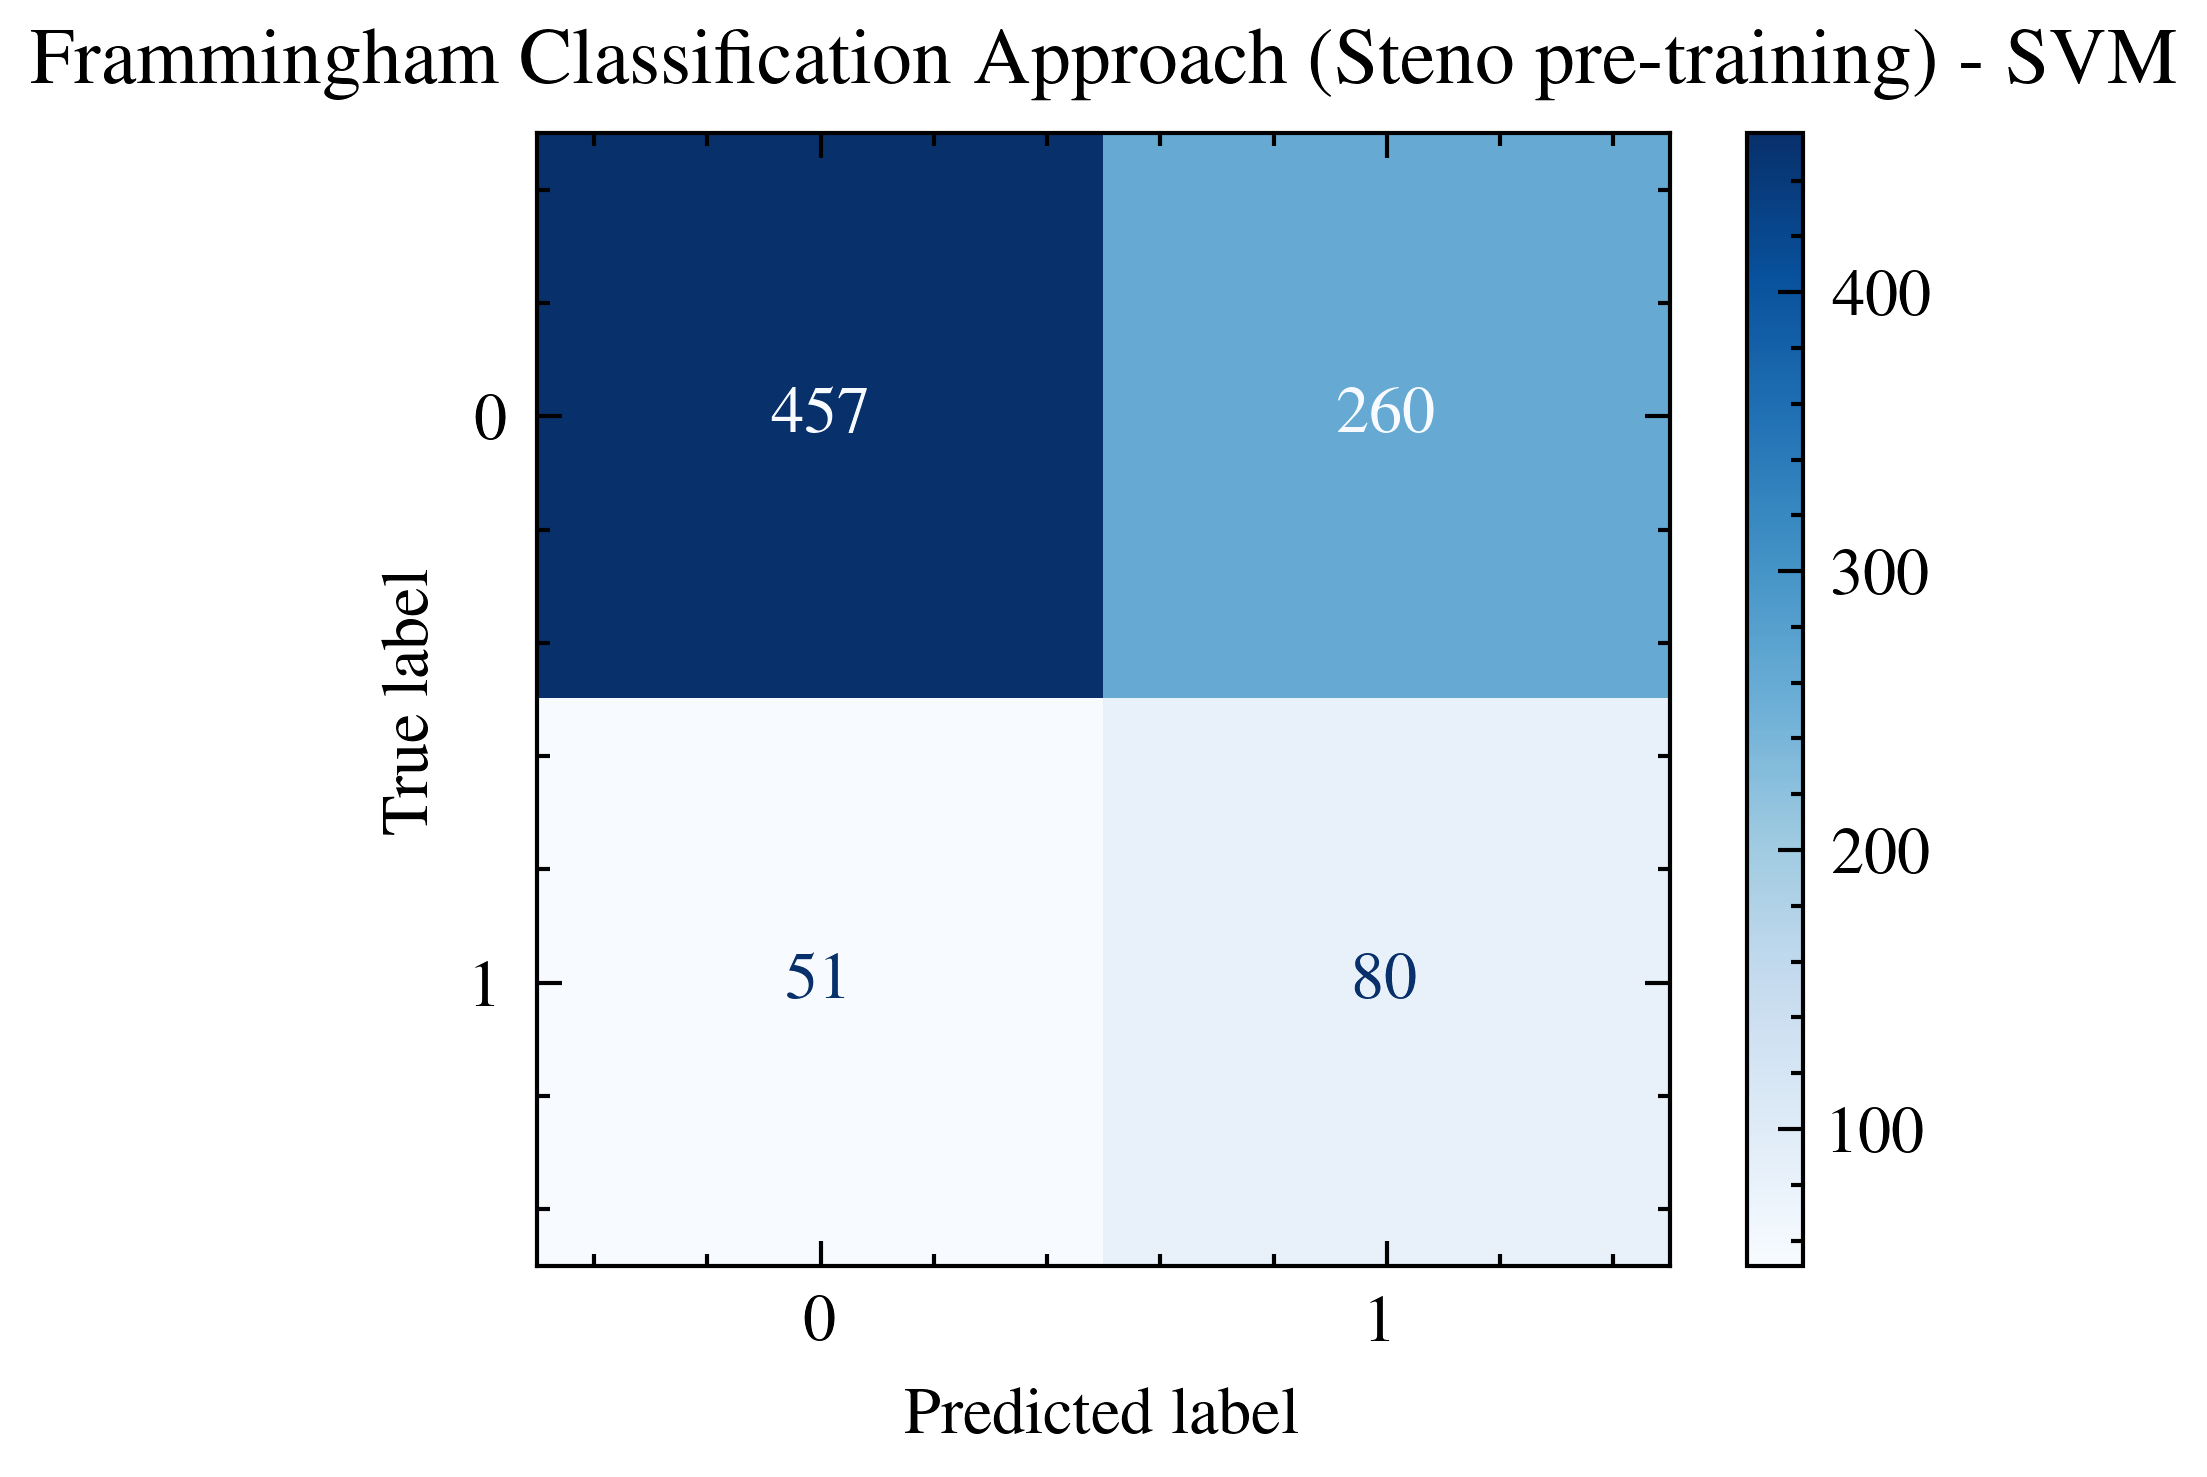

<Figure size 1980x1500 with 0 Axes>

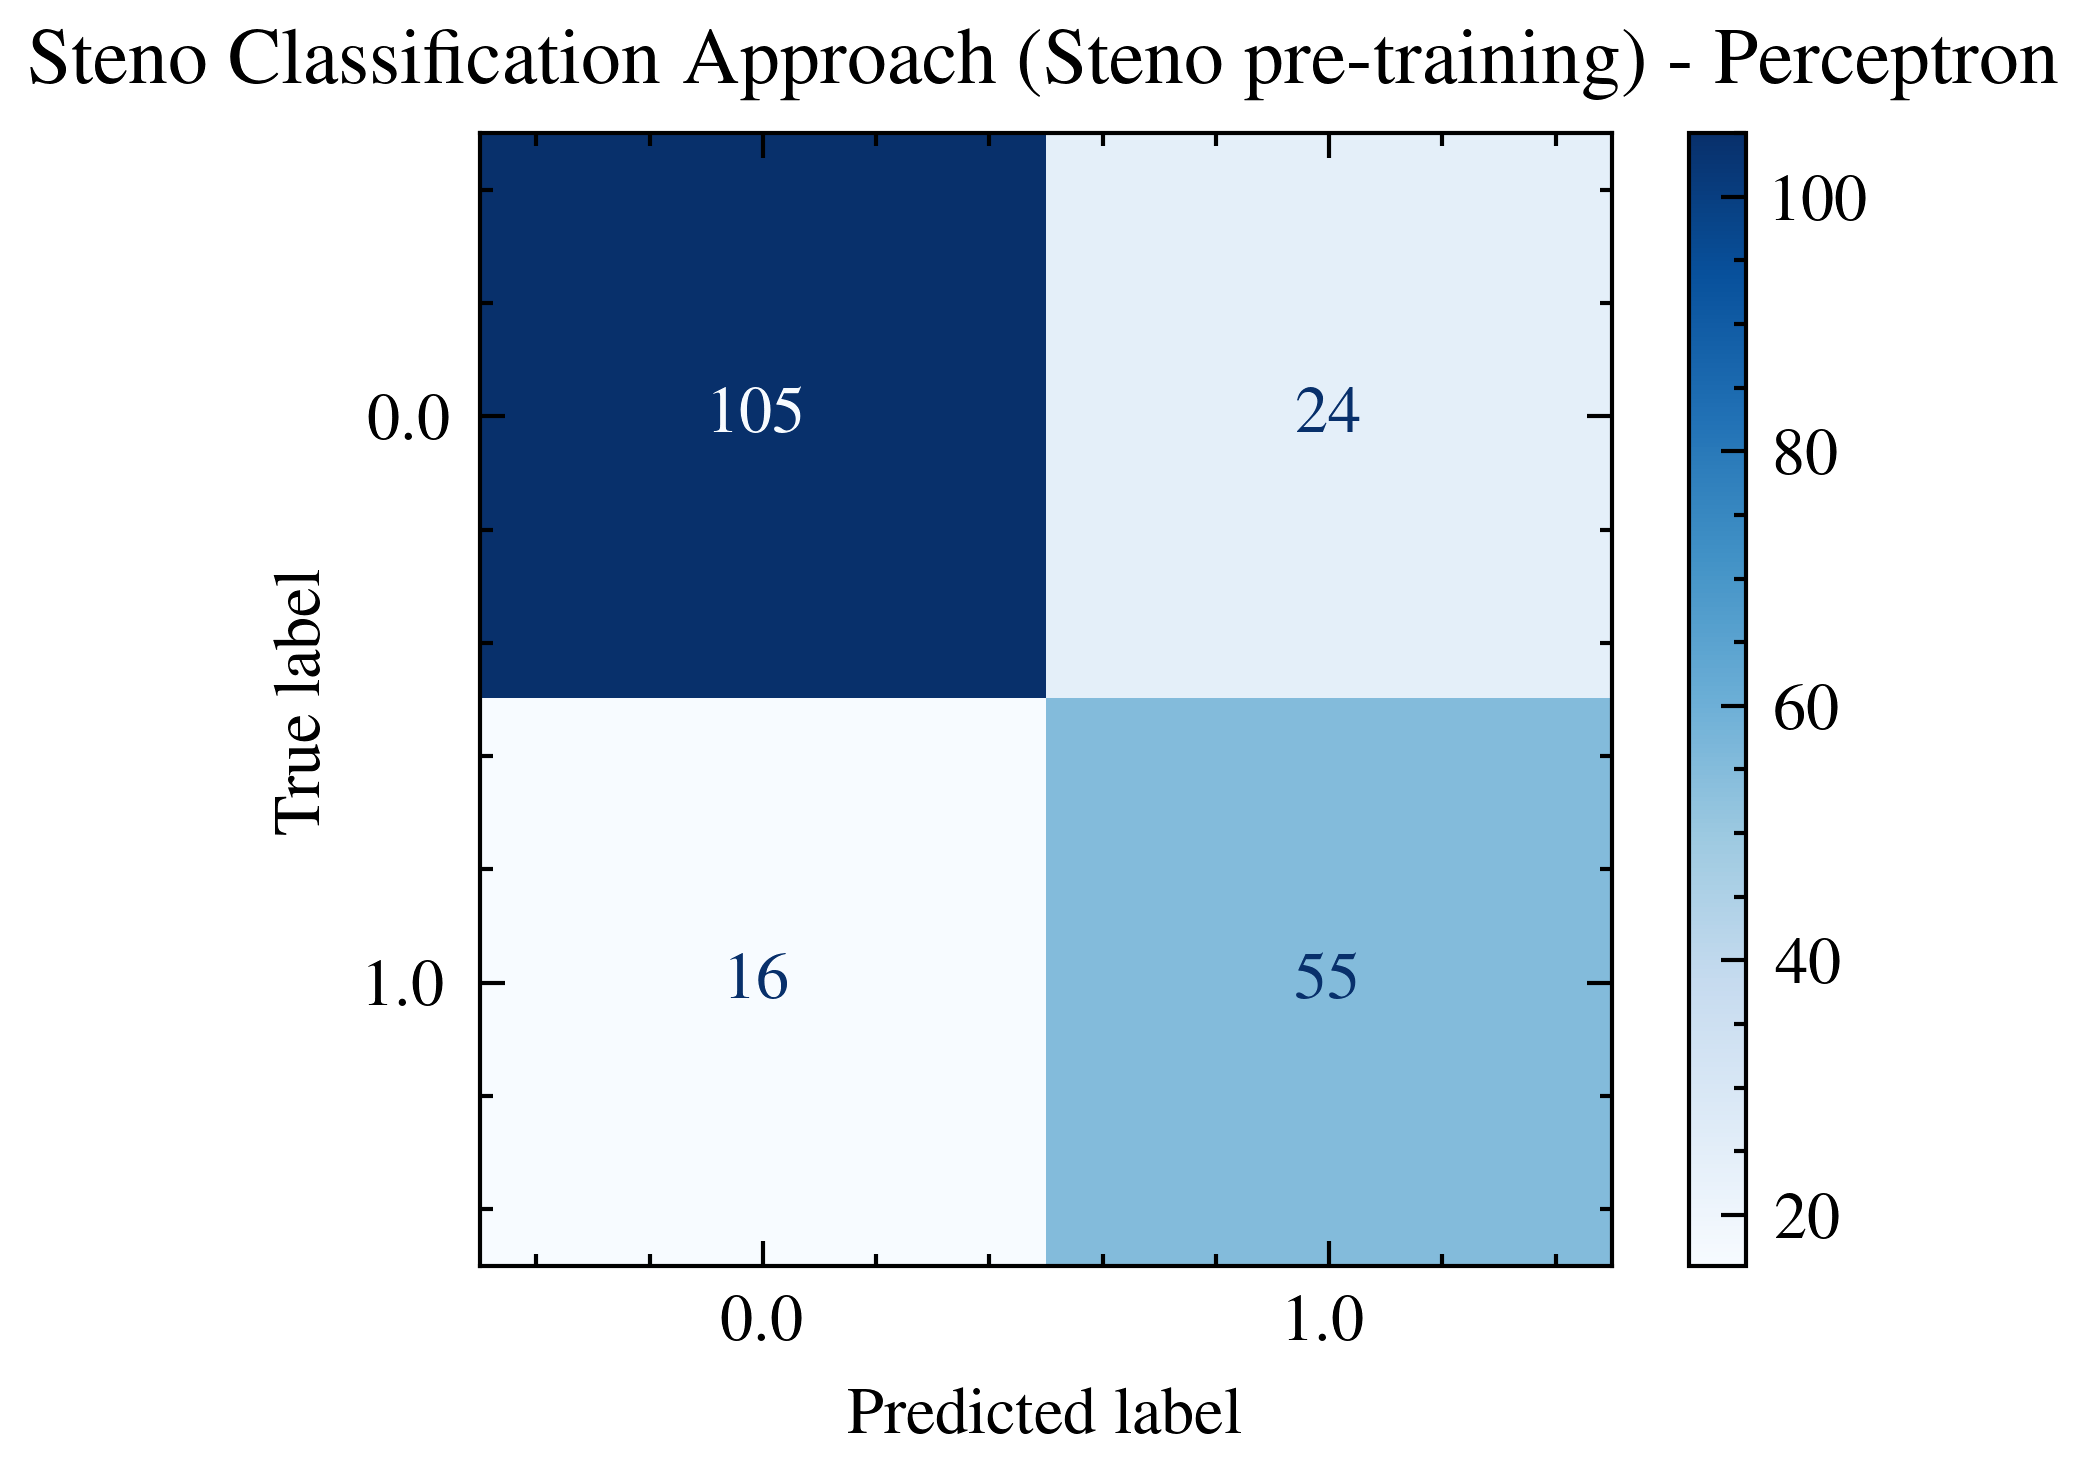

<Figure size 1980x1500 with 0 Axes>

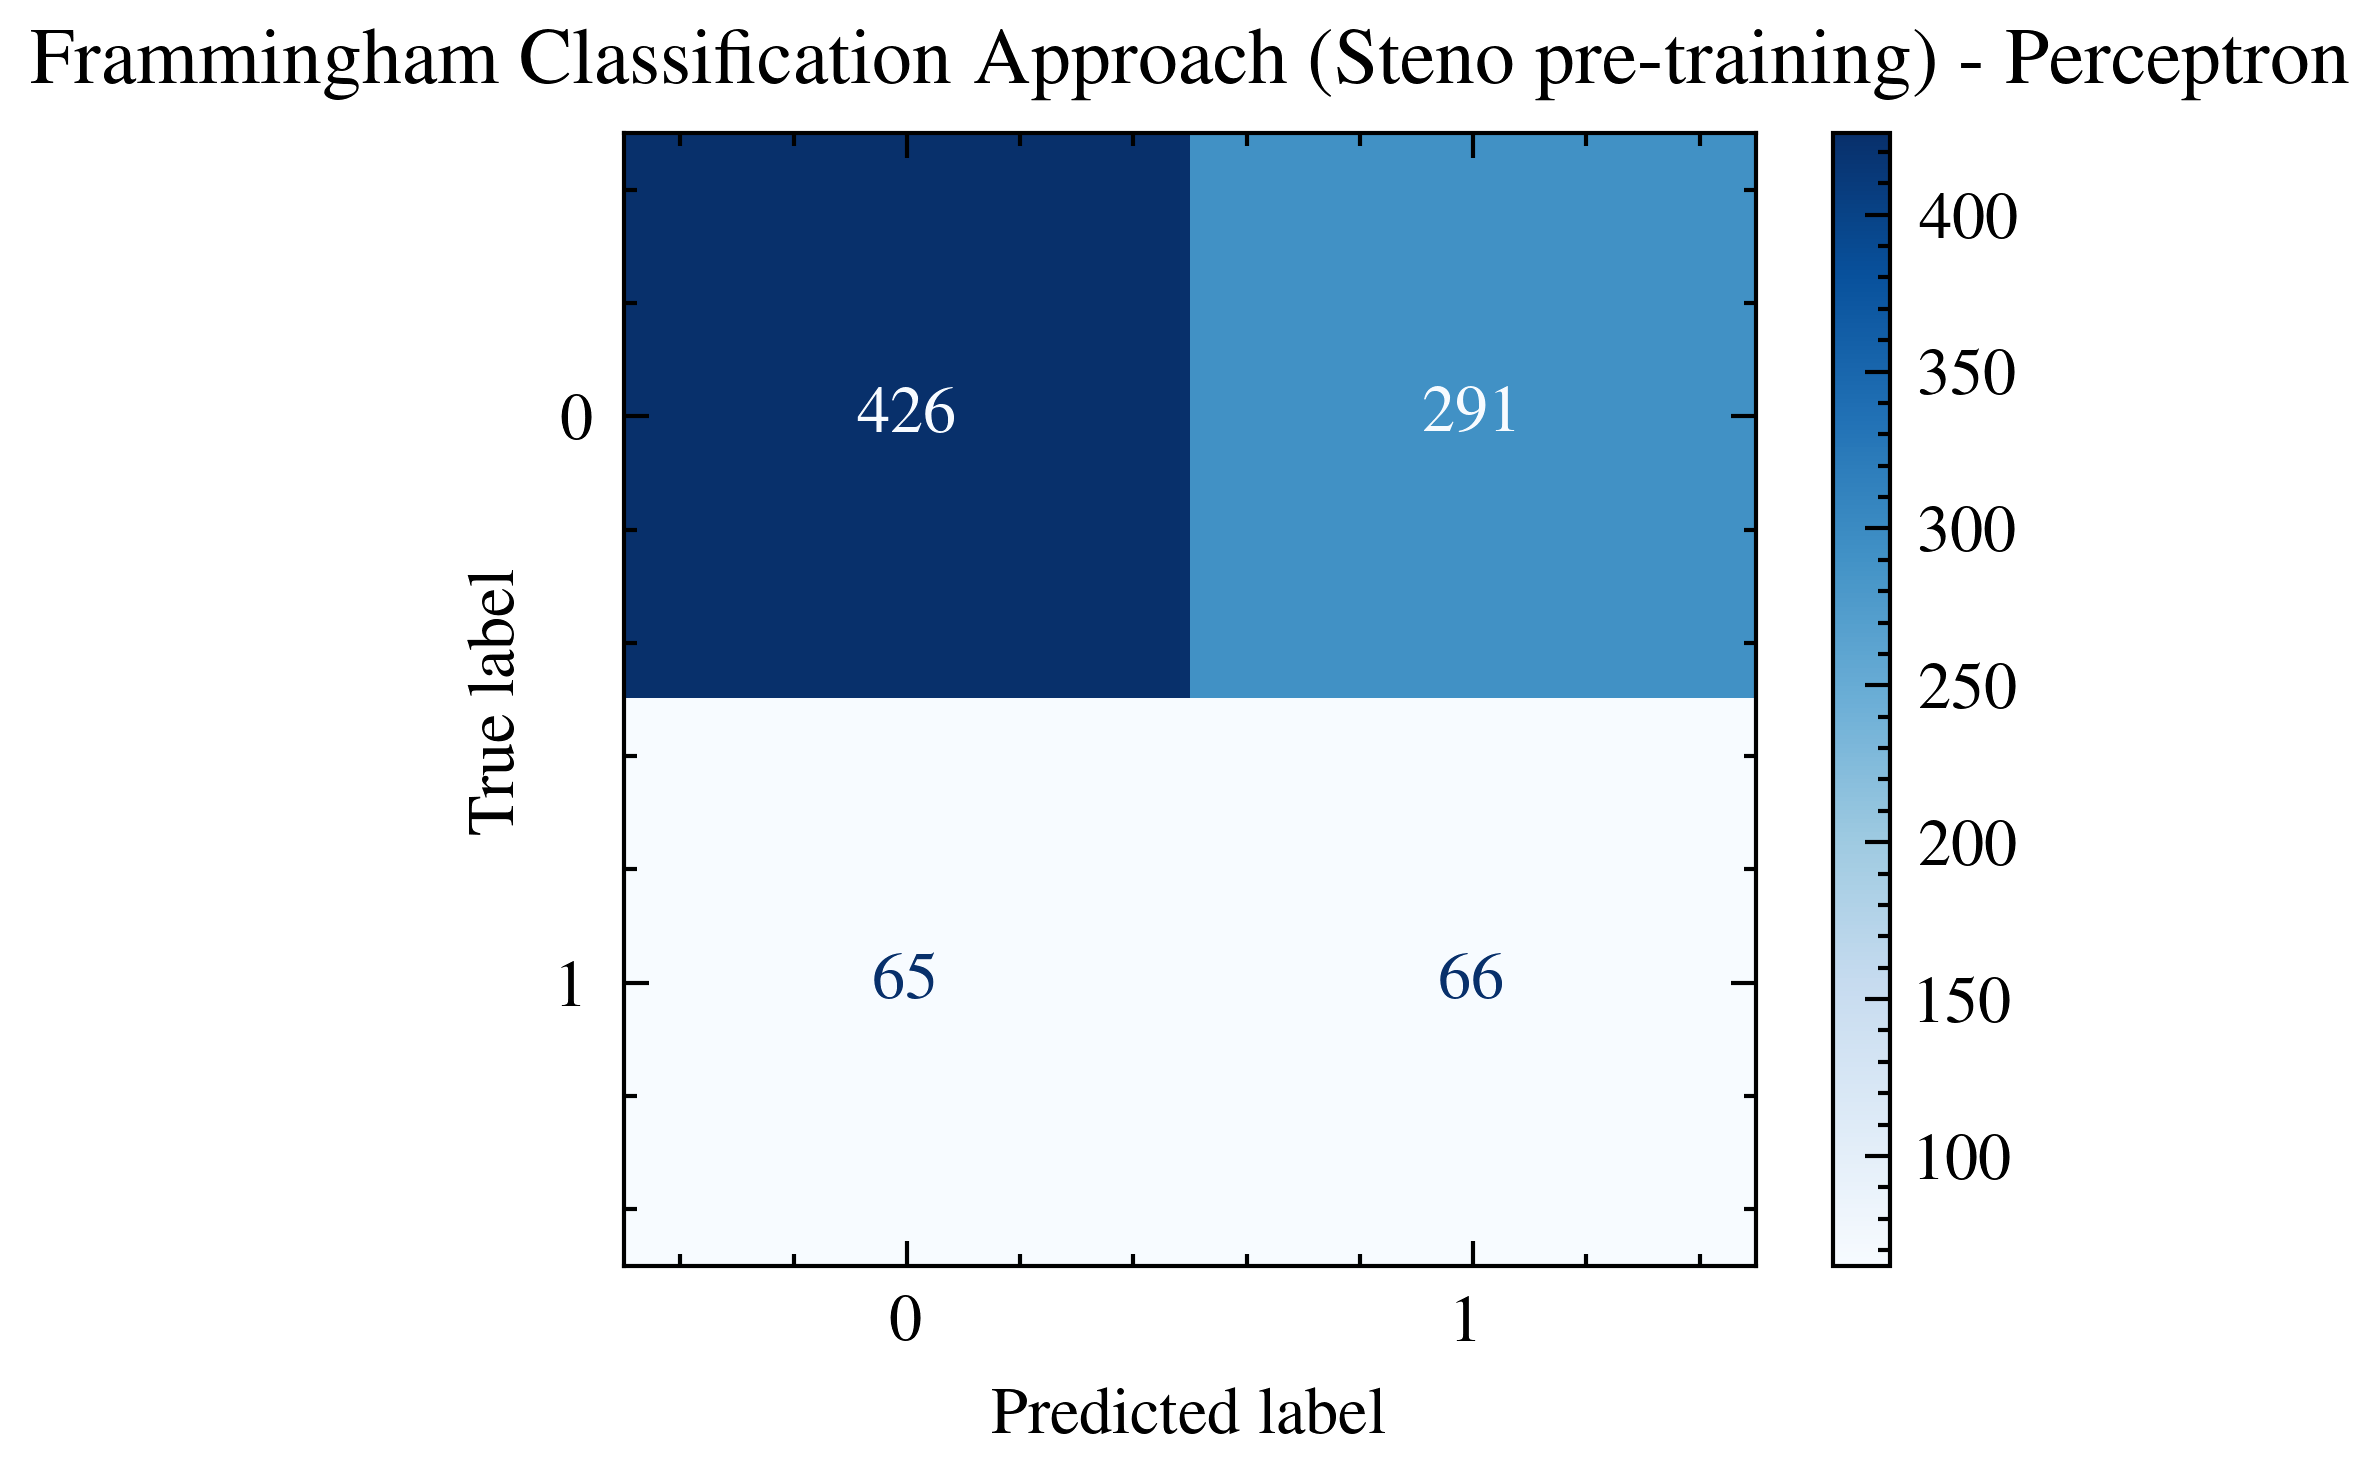

<Figure size 1980x1500 with 0 Axes>

In [30]:
# Confusion matrix in the pre-training
title = "Steno Classification Approach (Steno pre-training) - SVM "
disp = plot_confusion_matrix(svm_pretrained, steno_2common_X_val, steno_y_val['Class_label_binary'],
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure 
plt.savefig("Steno_SVM_confusion_matrix_pre-training.png", dpi = 300)

title = "Frammingham Classification Approach (Steno pre-training) - SVM"
disp = plot_confusion_matrix(svm_pretrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'], 
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Frammingham_SVM_confusion_matrix_pre-training.png", dpi = 300)

# Confusion matrix for Frammingham 
title = "Steno Classification Approach (Steno pre-training) - Perceptron"
disp = plot_confusion_matrix(perc_pretrained, steno_2common_X_val, steno_y_val['Class_label_binary'],
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Steno_Perceptron_confusion_matrix_pre-training.png", dpi = 300)

title = "Frammingham Classification Approach (Steno pre-training) - Perceptron"
disp = plot_confusion_matrix(perc_pretrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'], 
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Frammingham_Perceptron_confusion_matrix_pre-training.png", dpi = 300)

In [31]:
# Set a lower regularization parameter to allow SVM learn faster with the second dataset
svm_pretrained.alpha = 0.005 # Low C, means need of more support vectors (here we have more data)

Perceptron: Steno Classification (5 common) - Fold 1: 0.79
SVM: Steno Classification (5 common) - Fold 1: 0.86
Perceptron coefficients:  [[-0.05945121  2.46760337  2.68722842  1.15226814 -0.65497537]]
SVM coefficients:  [[-0.14912347  0.63541282 -0.10455827 -0.05000046  0.28994727]]
Perceptron: Steno Classification (5 common) - Fold 2: 0.83
SVM: Steno Classification (5 common) - Fold 2: 0.79
Perceptron coefficients:  [[-0.99675426  1.82564685  2.60359955  0.20549483  0.81606773]]
SVM coefficients:  [[-0.21645714  0.75299024 -0.12312585 -0.0797611   0.31955477]]
Perceptron: Steno Classification (5 common) - Fold 3: 0.79
SVM: Steno Classification (5 common) - Fold 3: 0.85
Perceptron coefficients:  [[-1.87276515  2.72667054  1.54550198  0.21685999  3.06062435]]
SVM coefficients:  [[-0.25659362  0.80968261 -0.12666848 -0.09843318  0.33613393]]
Perceptron: Steno Classification (5 common) - Fold 4: 0.84
SVM: Steno Classification (5 common) - Fold 4: 0.83
Perceptron coefficients:  [[-1.755835

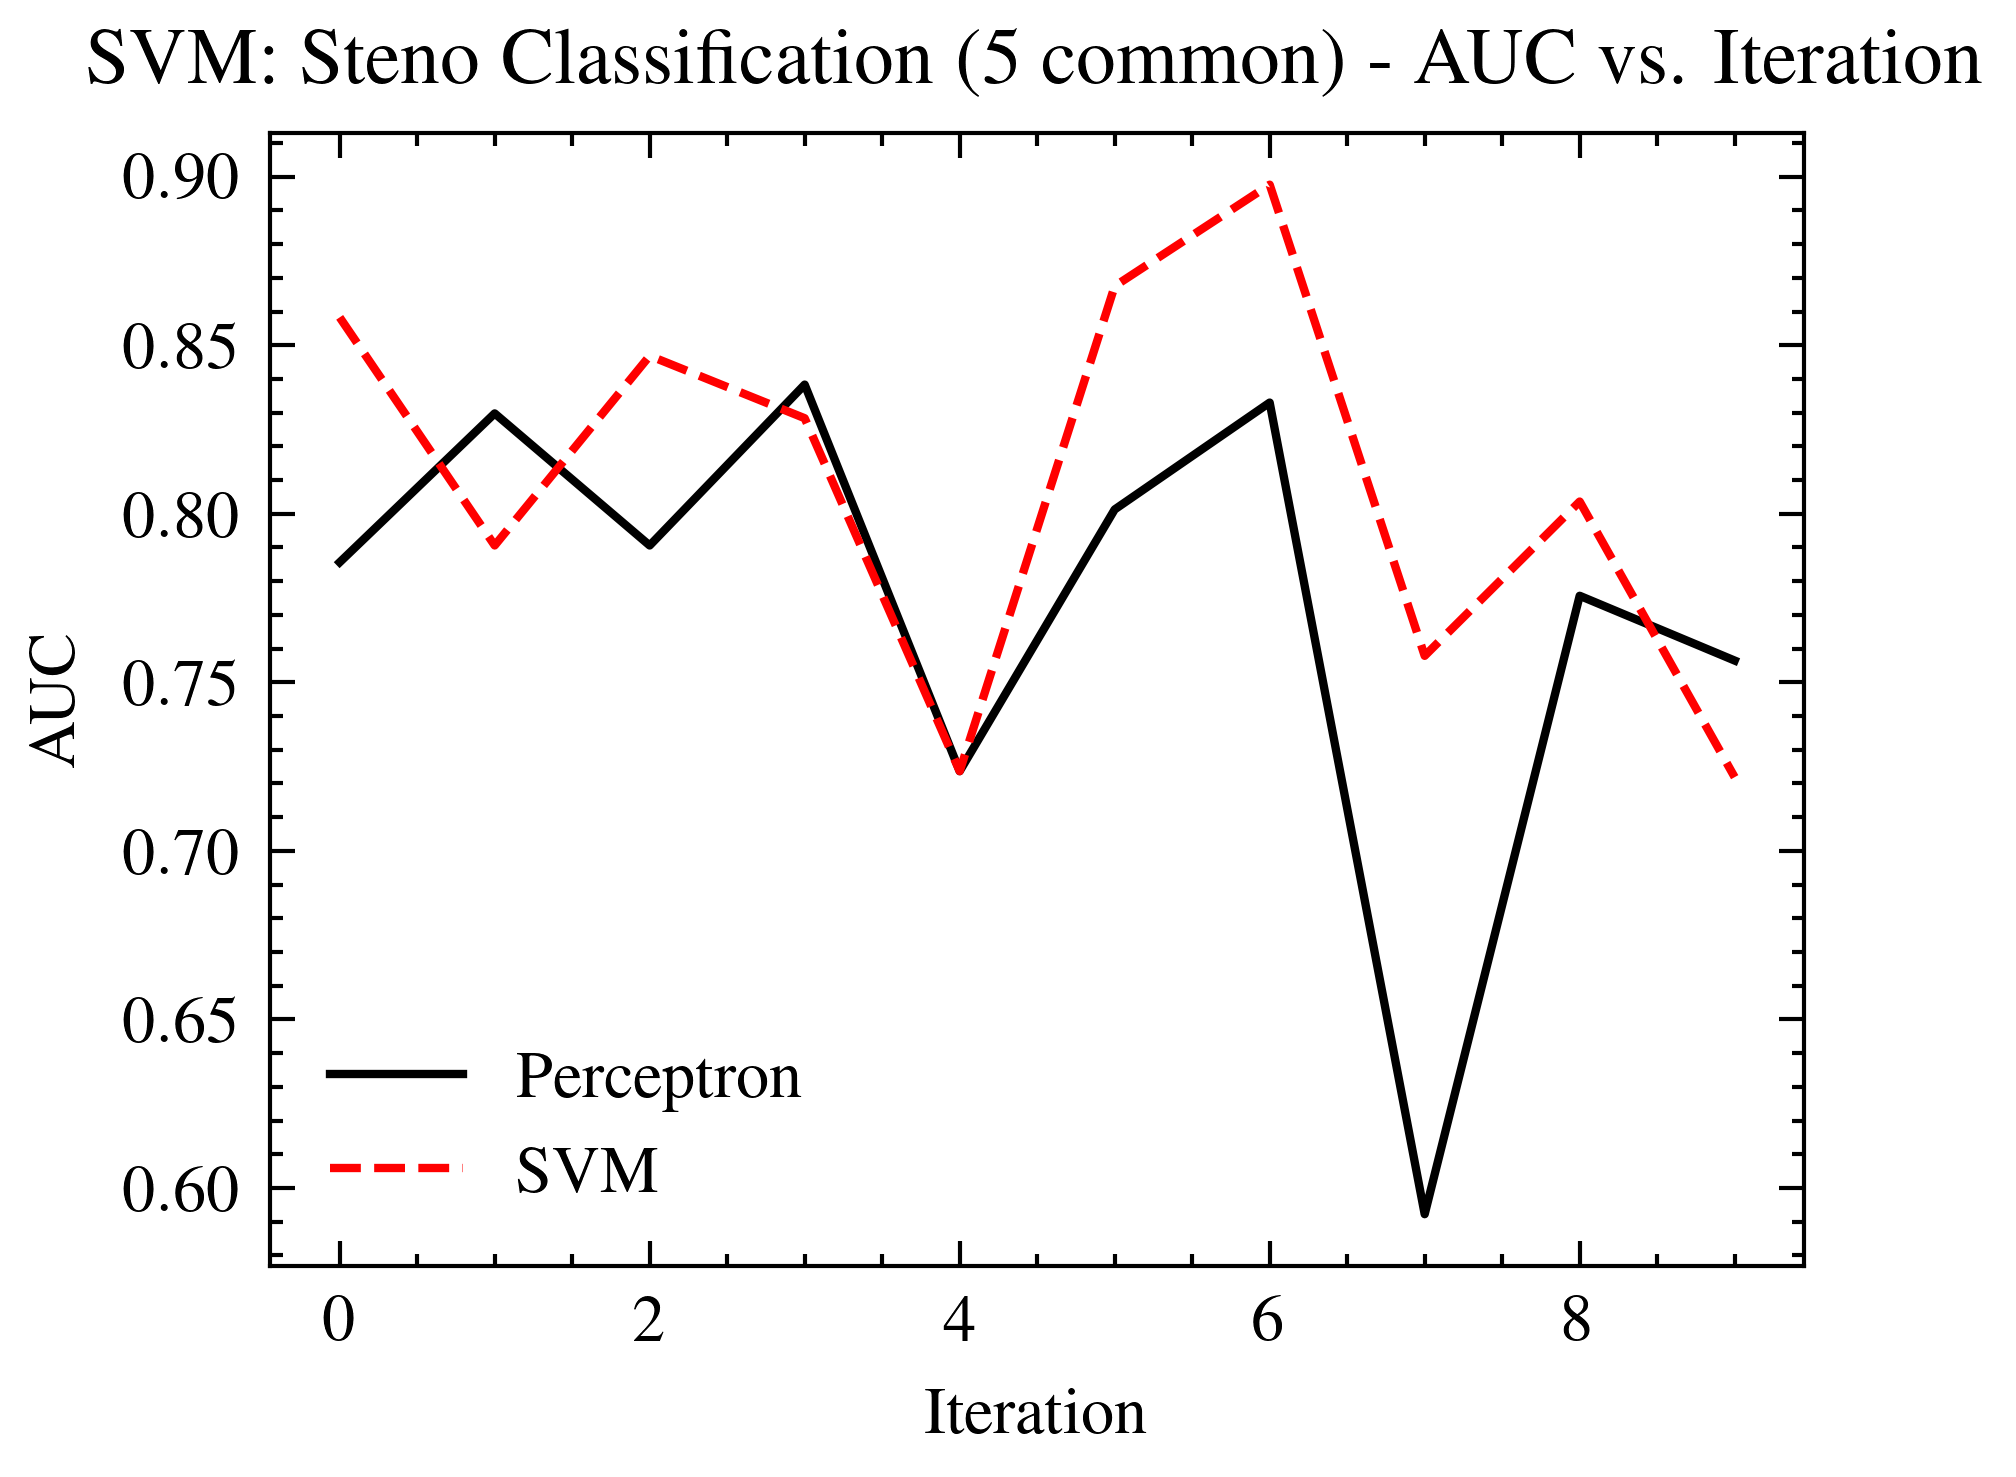

In [32]:
# Partial fit just iterate once through the training set, so 10 times with Cross Validation are performed

# Steno iterations 
steno_folds = 10

# Steno repetitions 
steno_repetitions = 1 

# Declare a StratifiedKFold object with 10 folds
skf = StratifiedKFold(n_splits = steno_folds, shuffle = True, random_state = 12345)

# For simplicity of code
X = steno_2common_X_train.to_numpy()
y = np.ravel(steno_y_train['Class_label_binary'])

# Dummy counter
i = 0

# Empty list to store the results of the 10 iterations
steno_perc_train_results = []
steno_svm_train_results = []

# Current model 
curr_perc_model = perc_pretrained
curr_svm_model = svm_pretrained

for train_index, test_index in skf.split(X, y):
    
    i = i + 1

    # Extract the training and test set for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model for this fold
    perc_posttrained = curr_perc_model.partial_fit(X_train, y_train, classes=np.unique(steno_y_train['Class_label_binary']))
    svm_posttrained = curr_svm_model.partial_fit(X_train, y_train, classes=np.unique(steno_y_train['Class_label_binary']))

    # Predict the test set
    y_perc_pred = perc_posttrained.predict(X_test)
    y_svm_pred = svm_posttrained.predict(X_test)

    # Test the model for this fold 
    perc_auc = roc_auc_score(y_test, y_perc_pred)
    svm_auc = roc_auc_score(y_test, y_svm_pred)


    # Print the results for this fold
    print("Perceptron: Steno Classification (5 common) - Fold %i: %.2f" % (i, perc_auc))
    print("SVM: Steno Classification (5 common) - Fold %i: %.2f" % (i, svm_auc))

    print("Perceptron coefficients: ", perc_posttrained.coef_)
    print("SVM coefficients: ", svm_posttrained.coef_) 

    # Append the results to the list
    steno_perc_train_results.append(perc_auc)
    steno_svm_train_results.append(svm_auc)

    # Update current model 
    curr_perc_model = perc_posttrained

# Plot auc vs iteration with perceptron
plt.figure()
plt.plot(range(steno_folds*steno_repetitions), steno_perc_train_results)

# Set title and labels
plt.title("Perceptron: Steno Classification (5 common) - AUC vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("AUC")

# Plot auc vs iteration with SVM
plt.plot(range(steno_folds*steno_repetitions), steno_svm_train_results)

# Set legend 
plt.legend(["Perceptron", "SVM"])

# Set title and labels 
plt.title("SVM: Steno Classification (5 common) - AUC vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("AUC")

# Save figure 
plt.savefig("Steno Classification (5 common) - AUC vs. Iteration.png", dpi = 300)

SVM - Steno Only 5 common -> ACC: 0.870000 || AUC: 0.917022 || F1-score: 0.803030 || Recall: 0.746479 || Precision: 0.868852
SVM - Frammingham Only 5 common -> ACC: 0.687500 || AUC: 0.658405 || F1-score: 0.315245 || Recall: 0.465649 || Precision: 0.238281
Perceptron After Incr. training - Steno Only 5 common -> ACC: 0.695000 || AUC: 0.884267 || F1-score: 0.677249 || Recall: 0.901408 || Precision: 0.542373
Perceptron After Incr. training - Frammingham Only 5 common -> ACC: 0.567217 || AUC: 0.621547 || F1-score: 0.300952 || Recall: 0.603053 || Precision: 0.200508


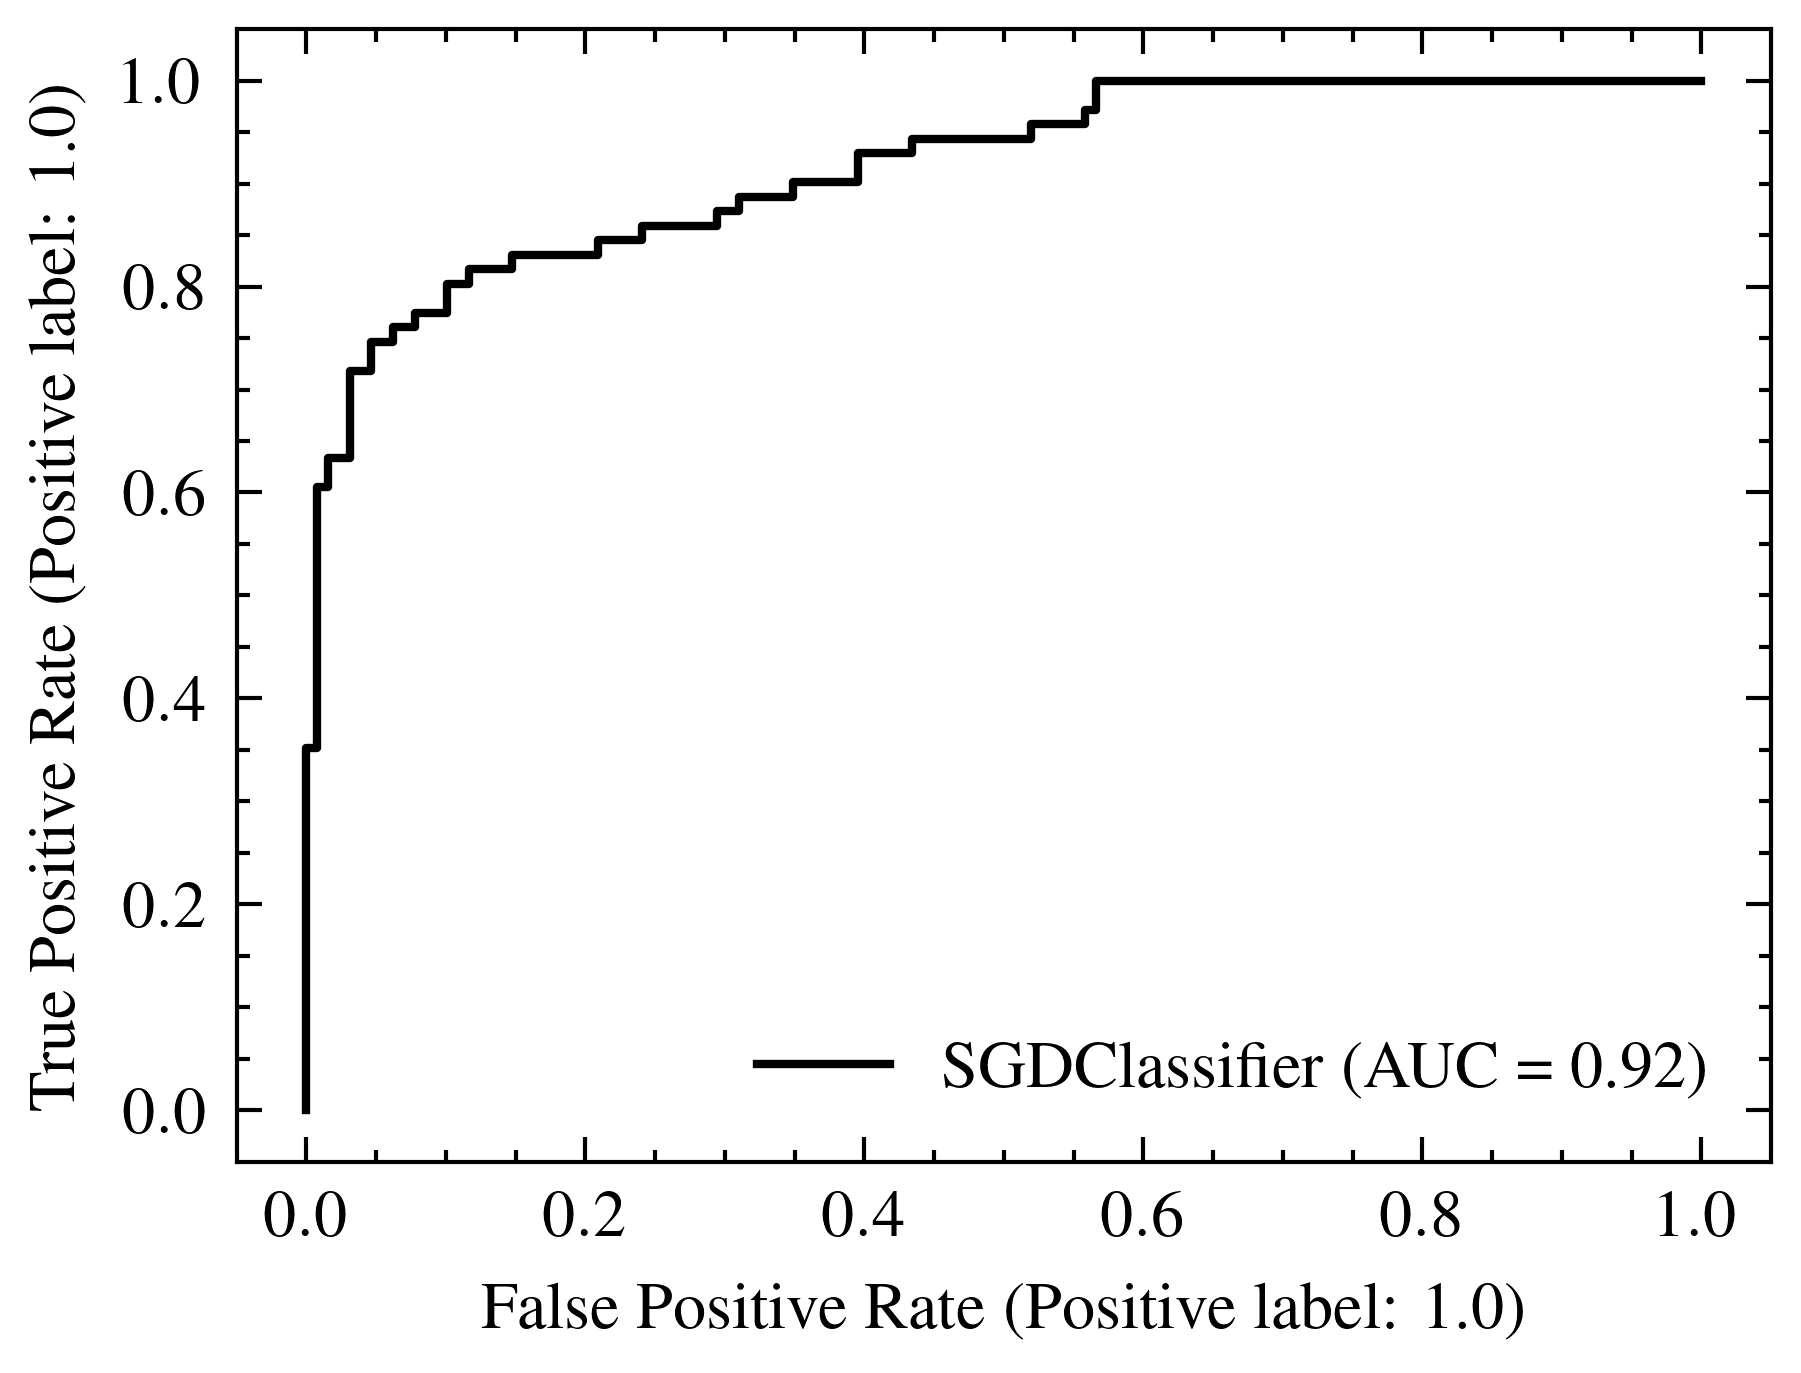

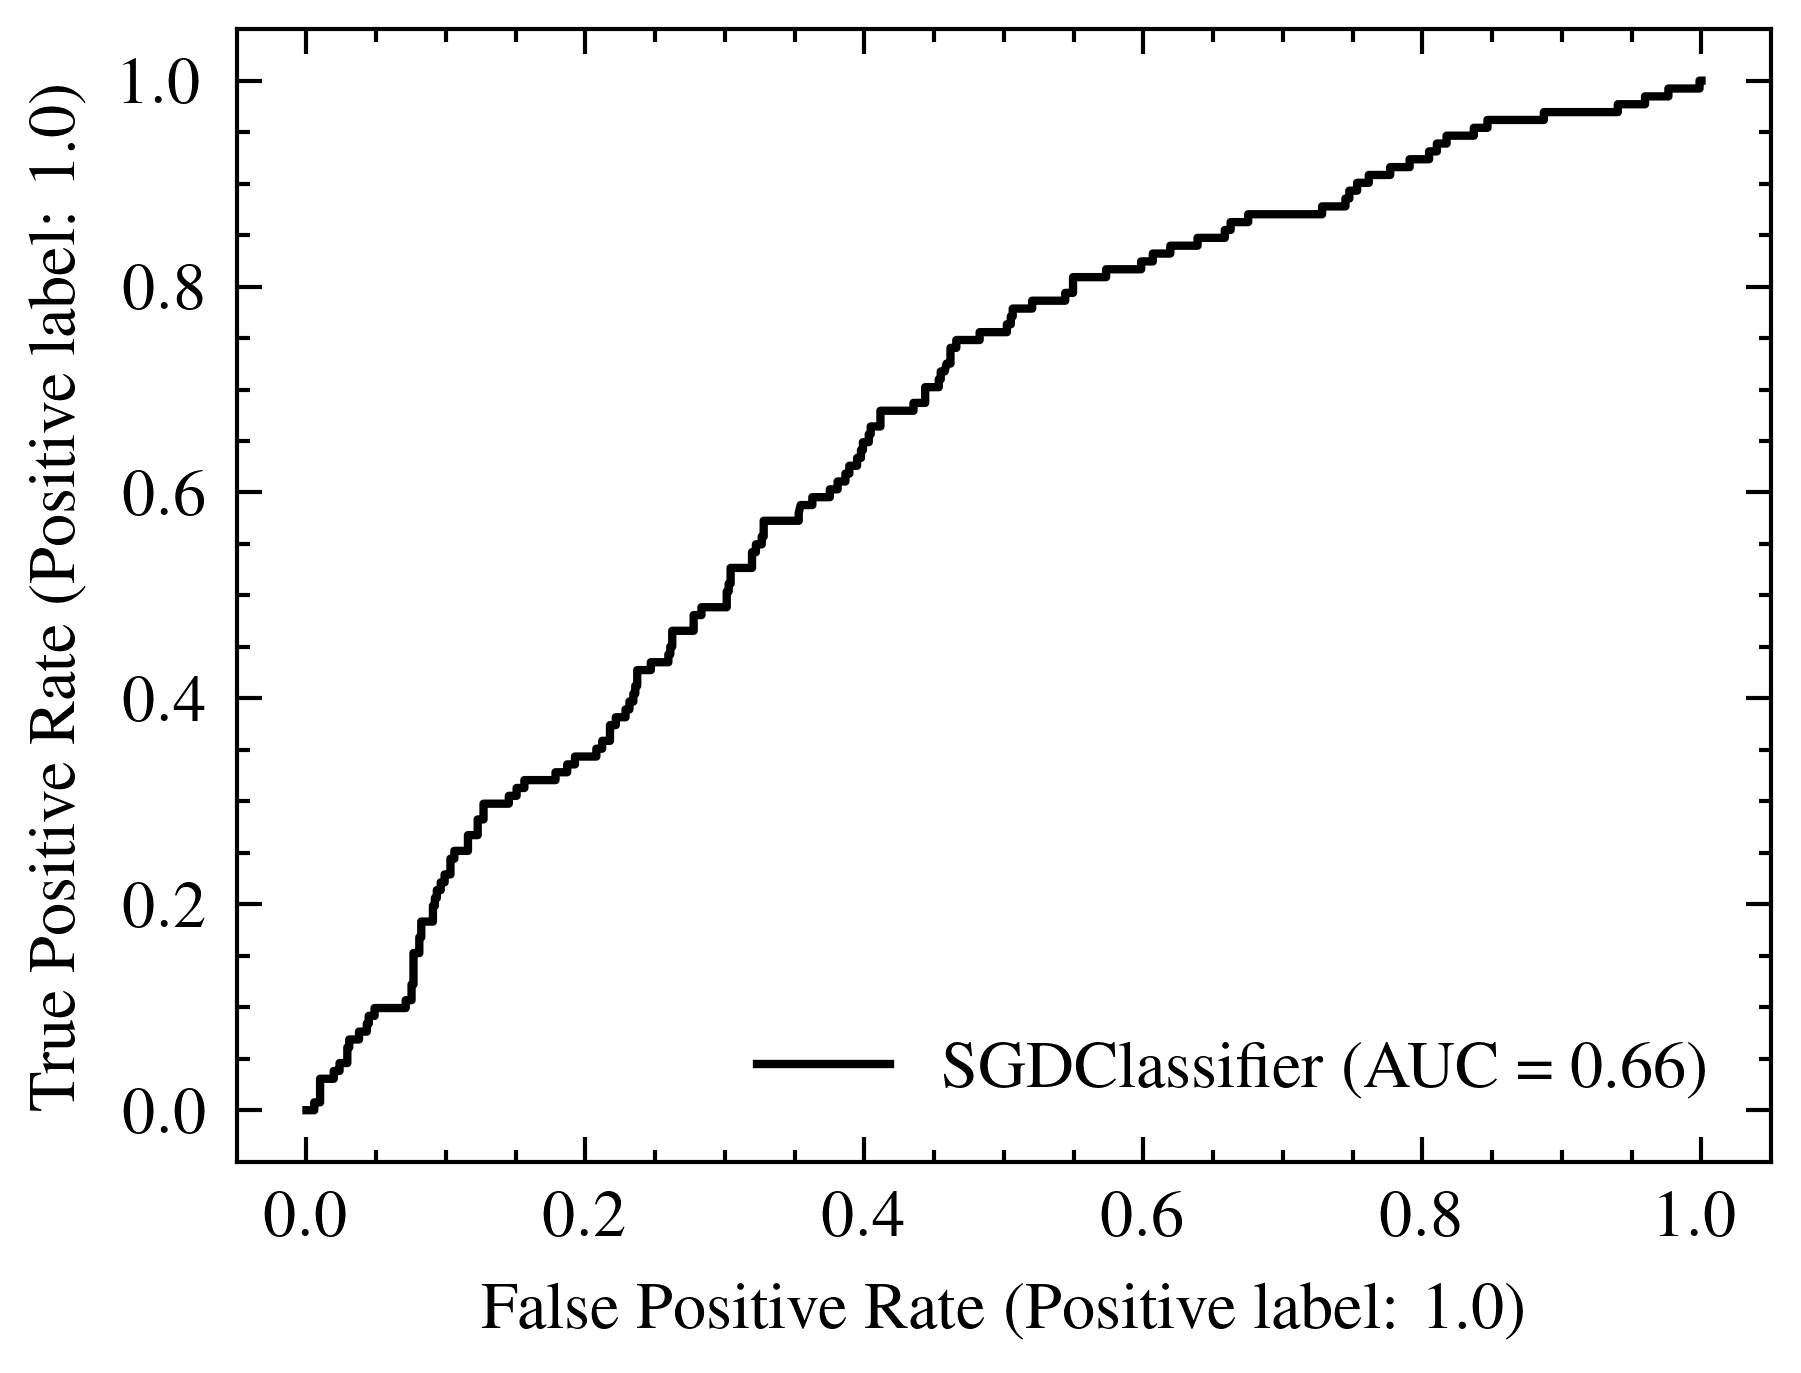

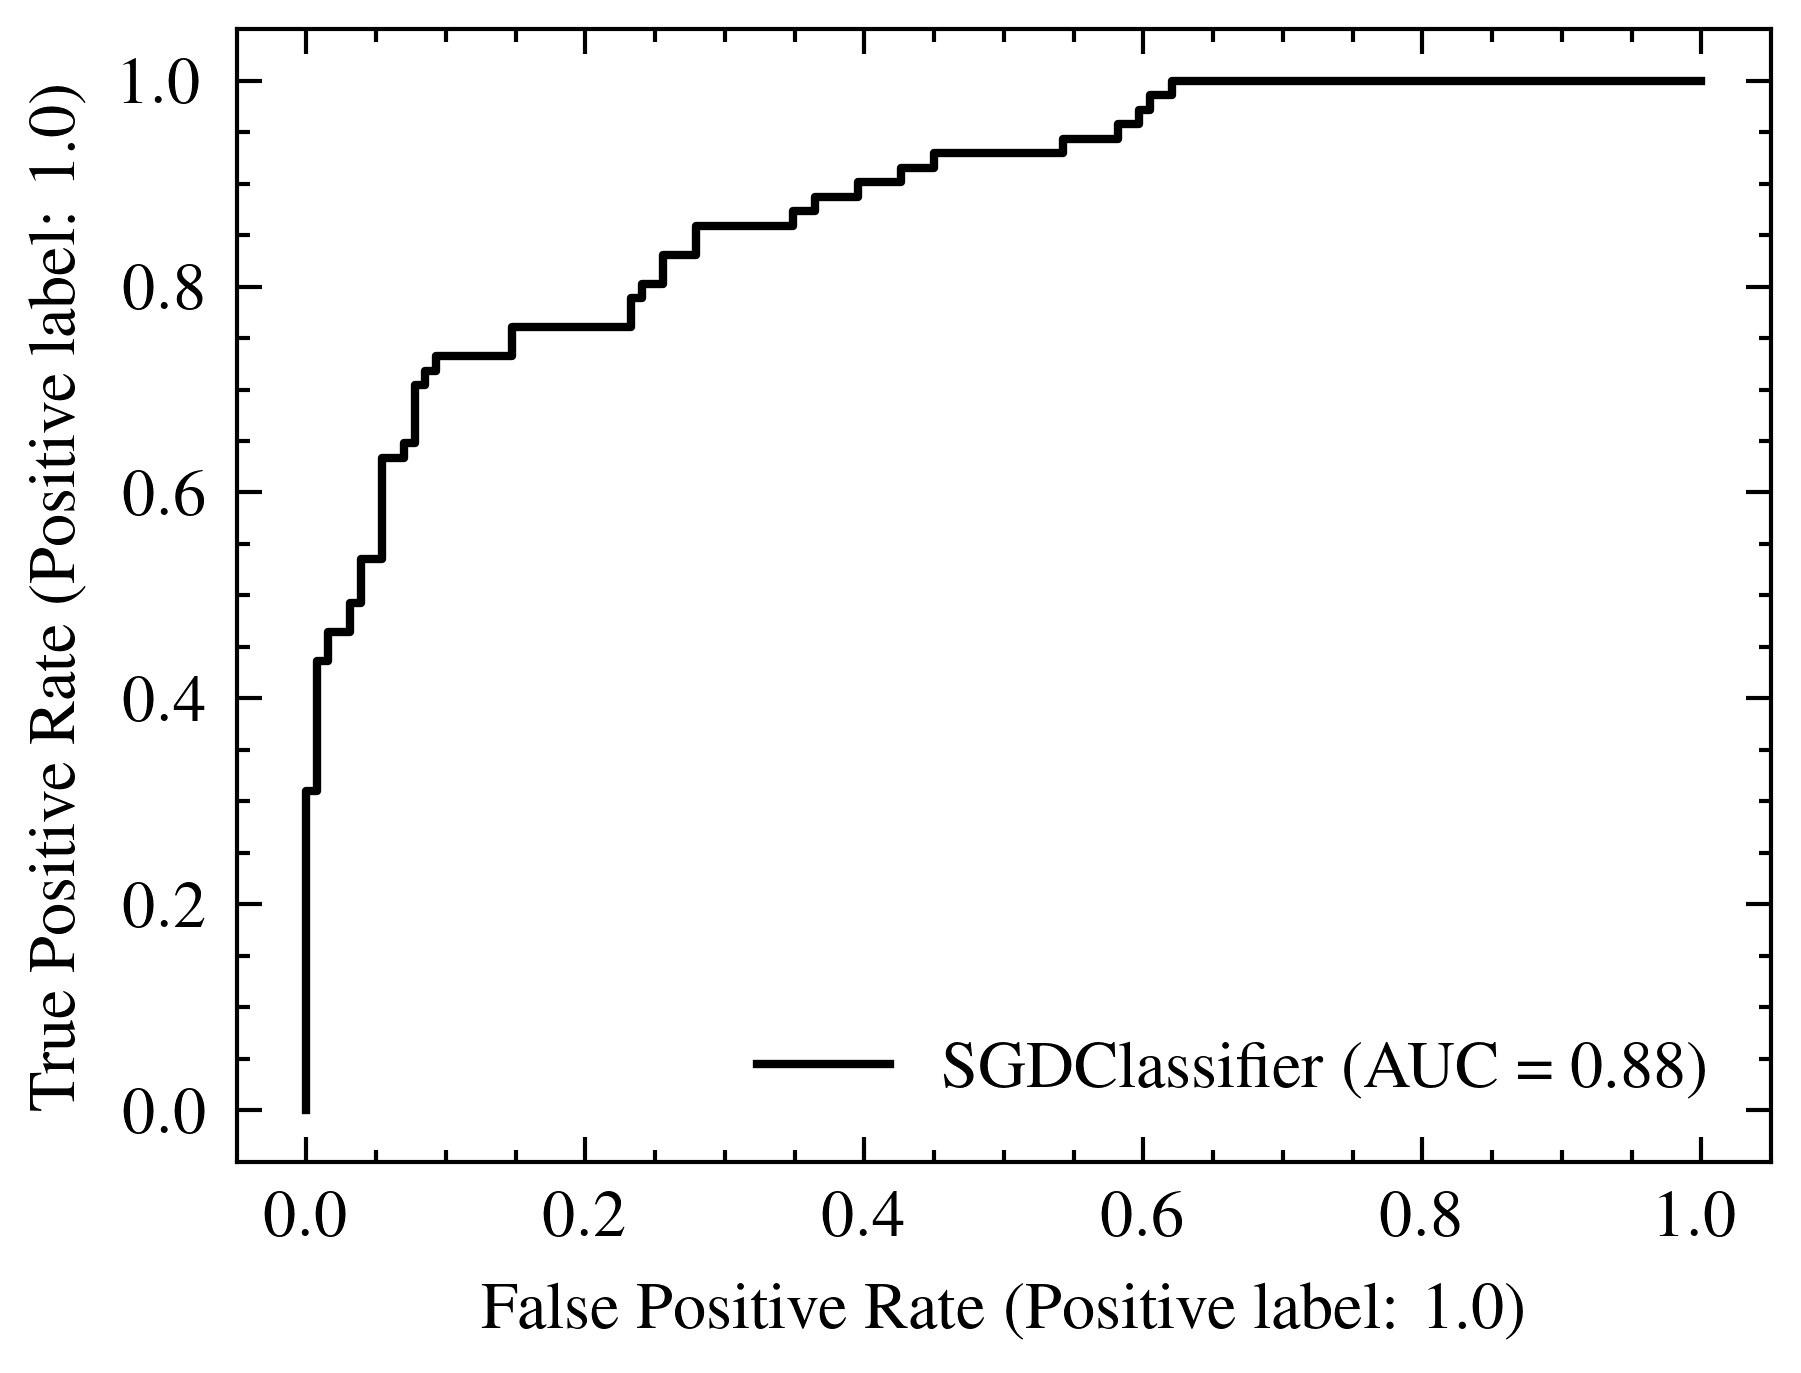

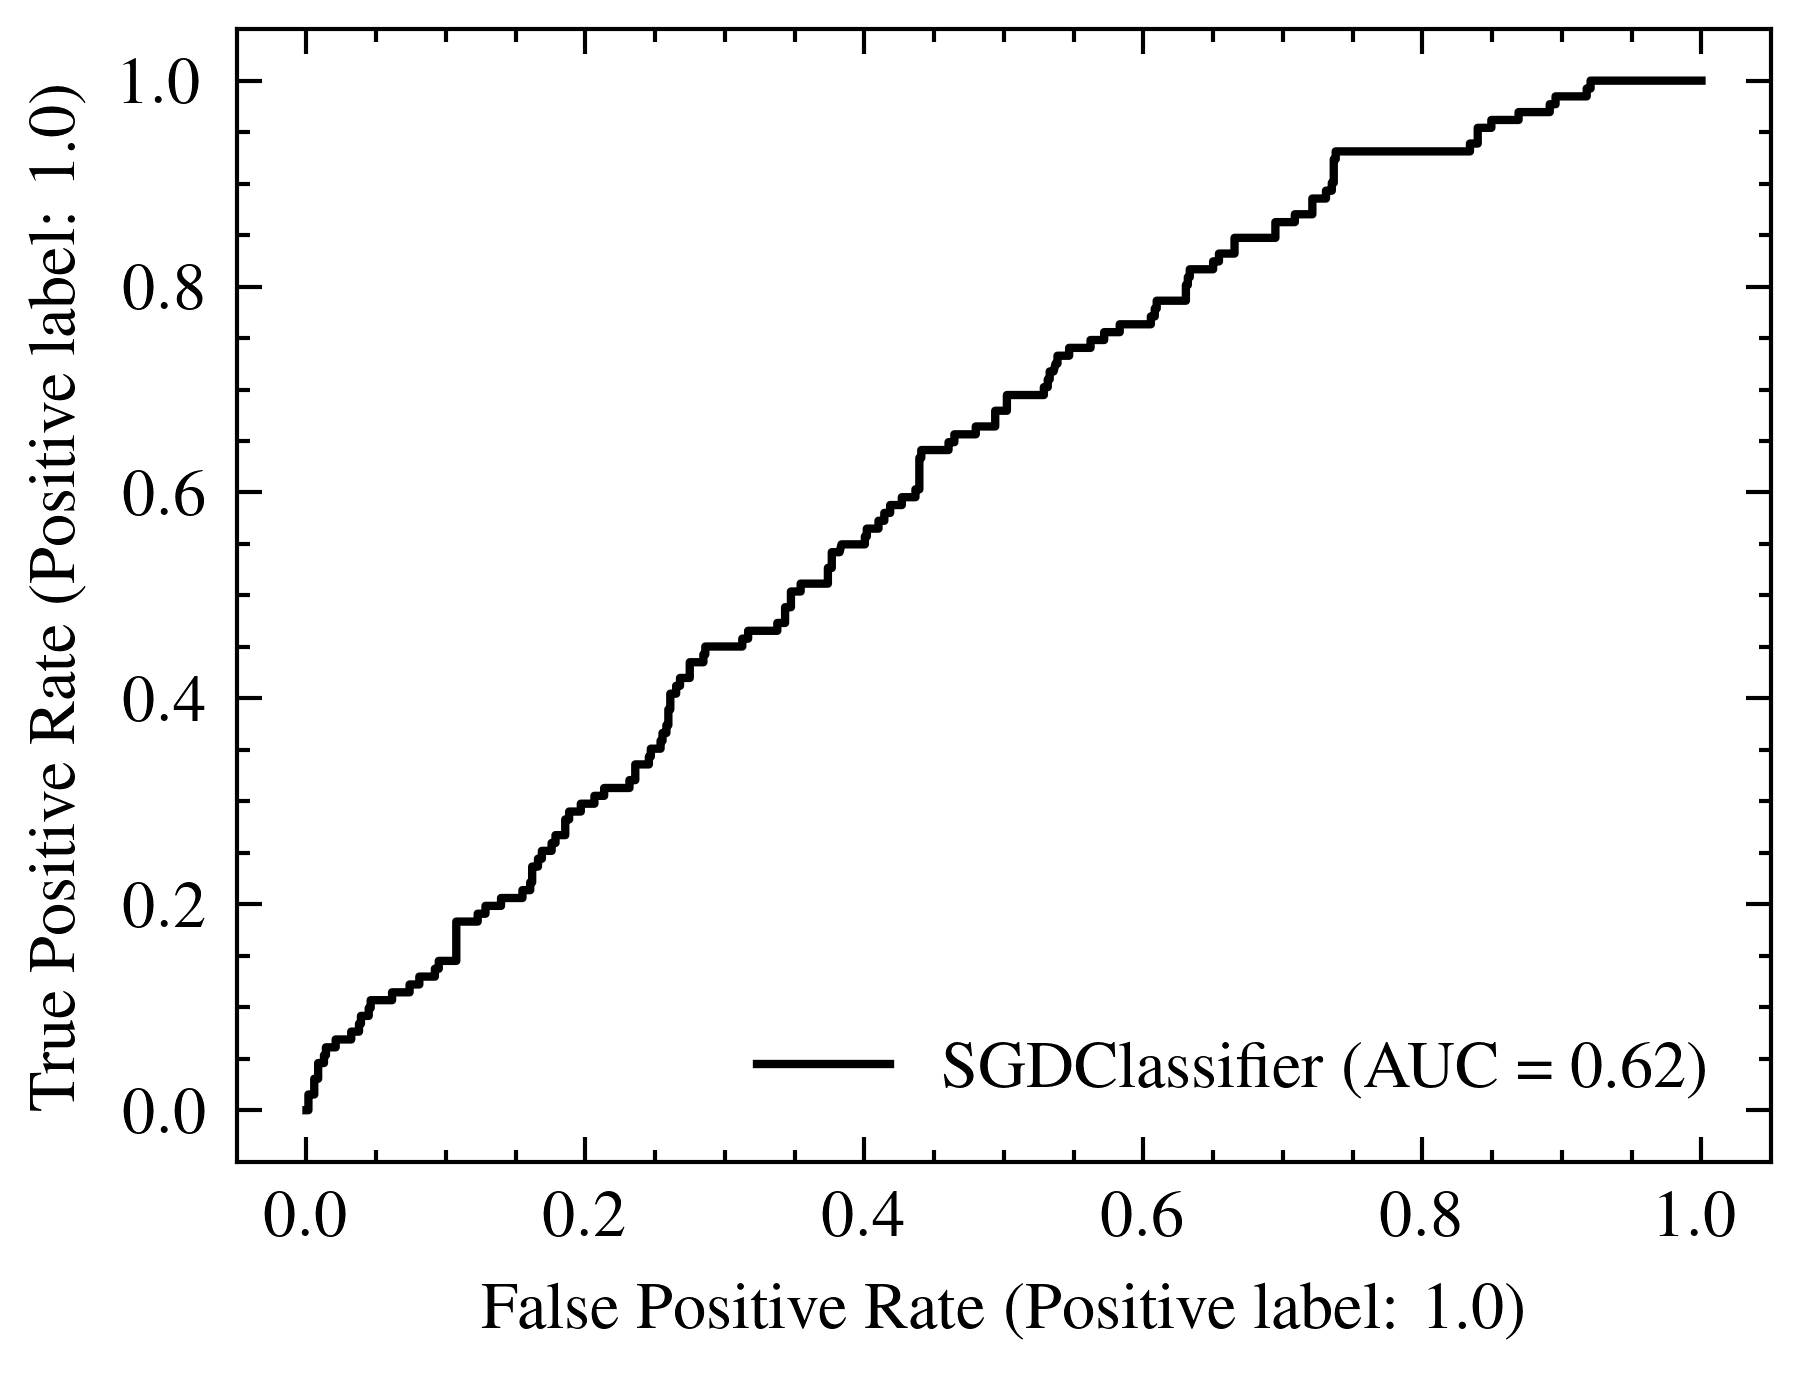

In [33]:
# Model validation after incremental training (SVM)
steno_acc_SVM_post, steno_auc_SVM_post, f1_steno_SVM_post, recall_steno_SVM_post, prec_steno_SVM_post = perc_clas_eval(svm_posttrained, steno_2common_X_val.to_numpy(), steno_y_val['Class_label_binary'])
print("SVM - Steno Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (steno_acc_SVM_post, steno_auc_SVM_post, f1_steno_SVM_post, recall_steno_SVM_post, prec_steno_SVM_post))
fram_acc_SVM_post, fram_auc_SVM_post, f1_fram_SVM_post, recall_fram_SVM_post, prec_fram_SVM_post = perc_clas_eval(svm_posttrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'])
print("SVM - Frammingham Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (fram_acc_SVM_post, fram_auc_SVM_post, f1_fram_SVM_post, recall_fram_SVM_post, prec_fram_SVM_post))

# Save results in an Excel file 
results = pd.DataFrame({'ACC': [steno_acc_SVM_post, fram_acc_SVM_post], 'AUC': [steno_auc_SVM_post, fram_auc_SVM_post], 'F1': [f1_steno_SVM_post, f1_fram_SVM_post], 'Recall': [recall_steno_SVM_post, recall_fram_SVM_post], 'Precision': [prec_steno_SVM_post, prec_fram_SVM_post]}, index=['Steno Only 5 common', 'Frammingham Only 5 common'])
results.to_excel('SVM_post_training_Steno_Frammingham_5common.xlsx')


# Model validation after incremental training (Perceptron)
steno_acc_perc_post, steno_auc_perc_post, f1_steno_perc_post, recall_steno_perc_post, prec_steno_perc_post = perc_clas_eval(perc_posttrained, steno_2common_X_val.to_numpy(), steno_y_val['Class_label_binary'])
print("Perceptron After Incr. training - Steno Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (steno_acc_perc_post, steno_auc_perc_post, f1_steno_perc_post,  recall_steno_perc_post, prec_steno_perc_post))
fram_acc_perc_post, fram_auc_perc_post, f1_fram_perc_post, recall_fram_perc_post, prec_fram_perc_post = perc_clas_eval(perc_posttrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'])
print("Perceptron After Incr. training - Frammingham Only 5 common -> ACC: %f || AUC: %f || F1-score: %f || Recall: %f || Precision: %f" % (fram_acc_perc_post, fram_auc_perc_post, f1_fram_perc_post, recall_fram_perc_post, prec_fram_perc_post))

# Save results in an Excel file
results = pd.DataFrame({'ACC': [steno_acc_perc_post, fram_acc_perc_post], 'AUC': [steno_auc_perc_post, fram_auc_perc_post], 'F1': [f1_steno_perc_post, f1_fram_perc_post], 'Recall': [recall_steno_perc_post, recall_fram_perc_post], 'Precision': [prec_steno_perc_post, prec_fram_perc_post]}, index=['Steno Only 5 common', 'Frammingham Only 5 common'])
results.to_excel('Perceptron_post_training_Steno_Frammingham_5common.xlsx')

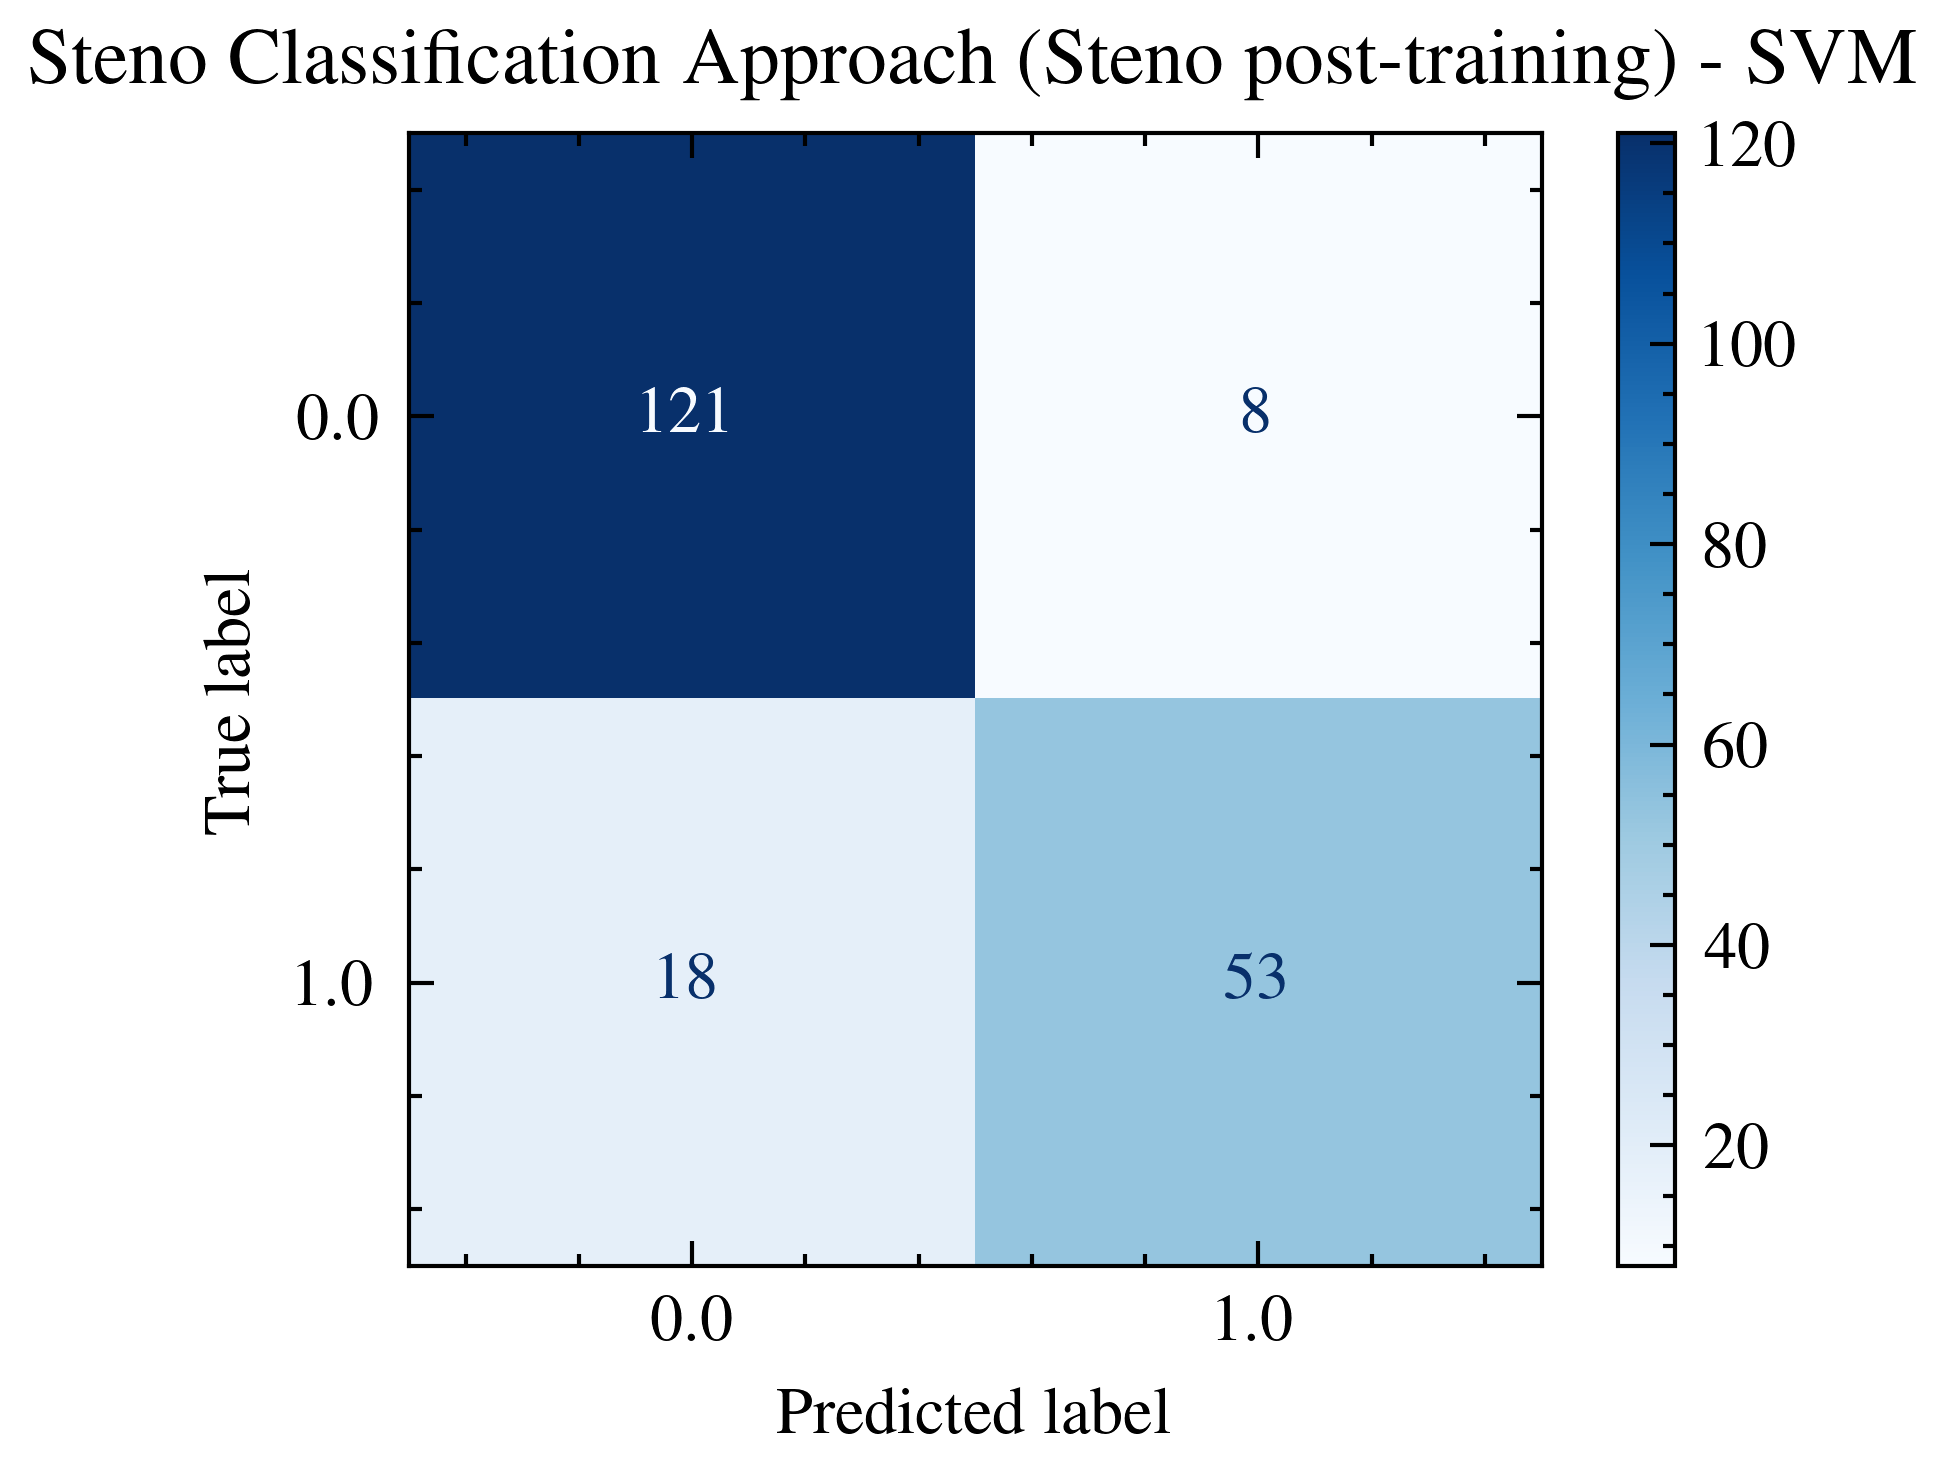

<Figure size 1980x1500 with 0 Axes>

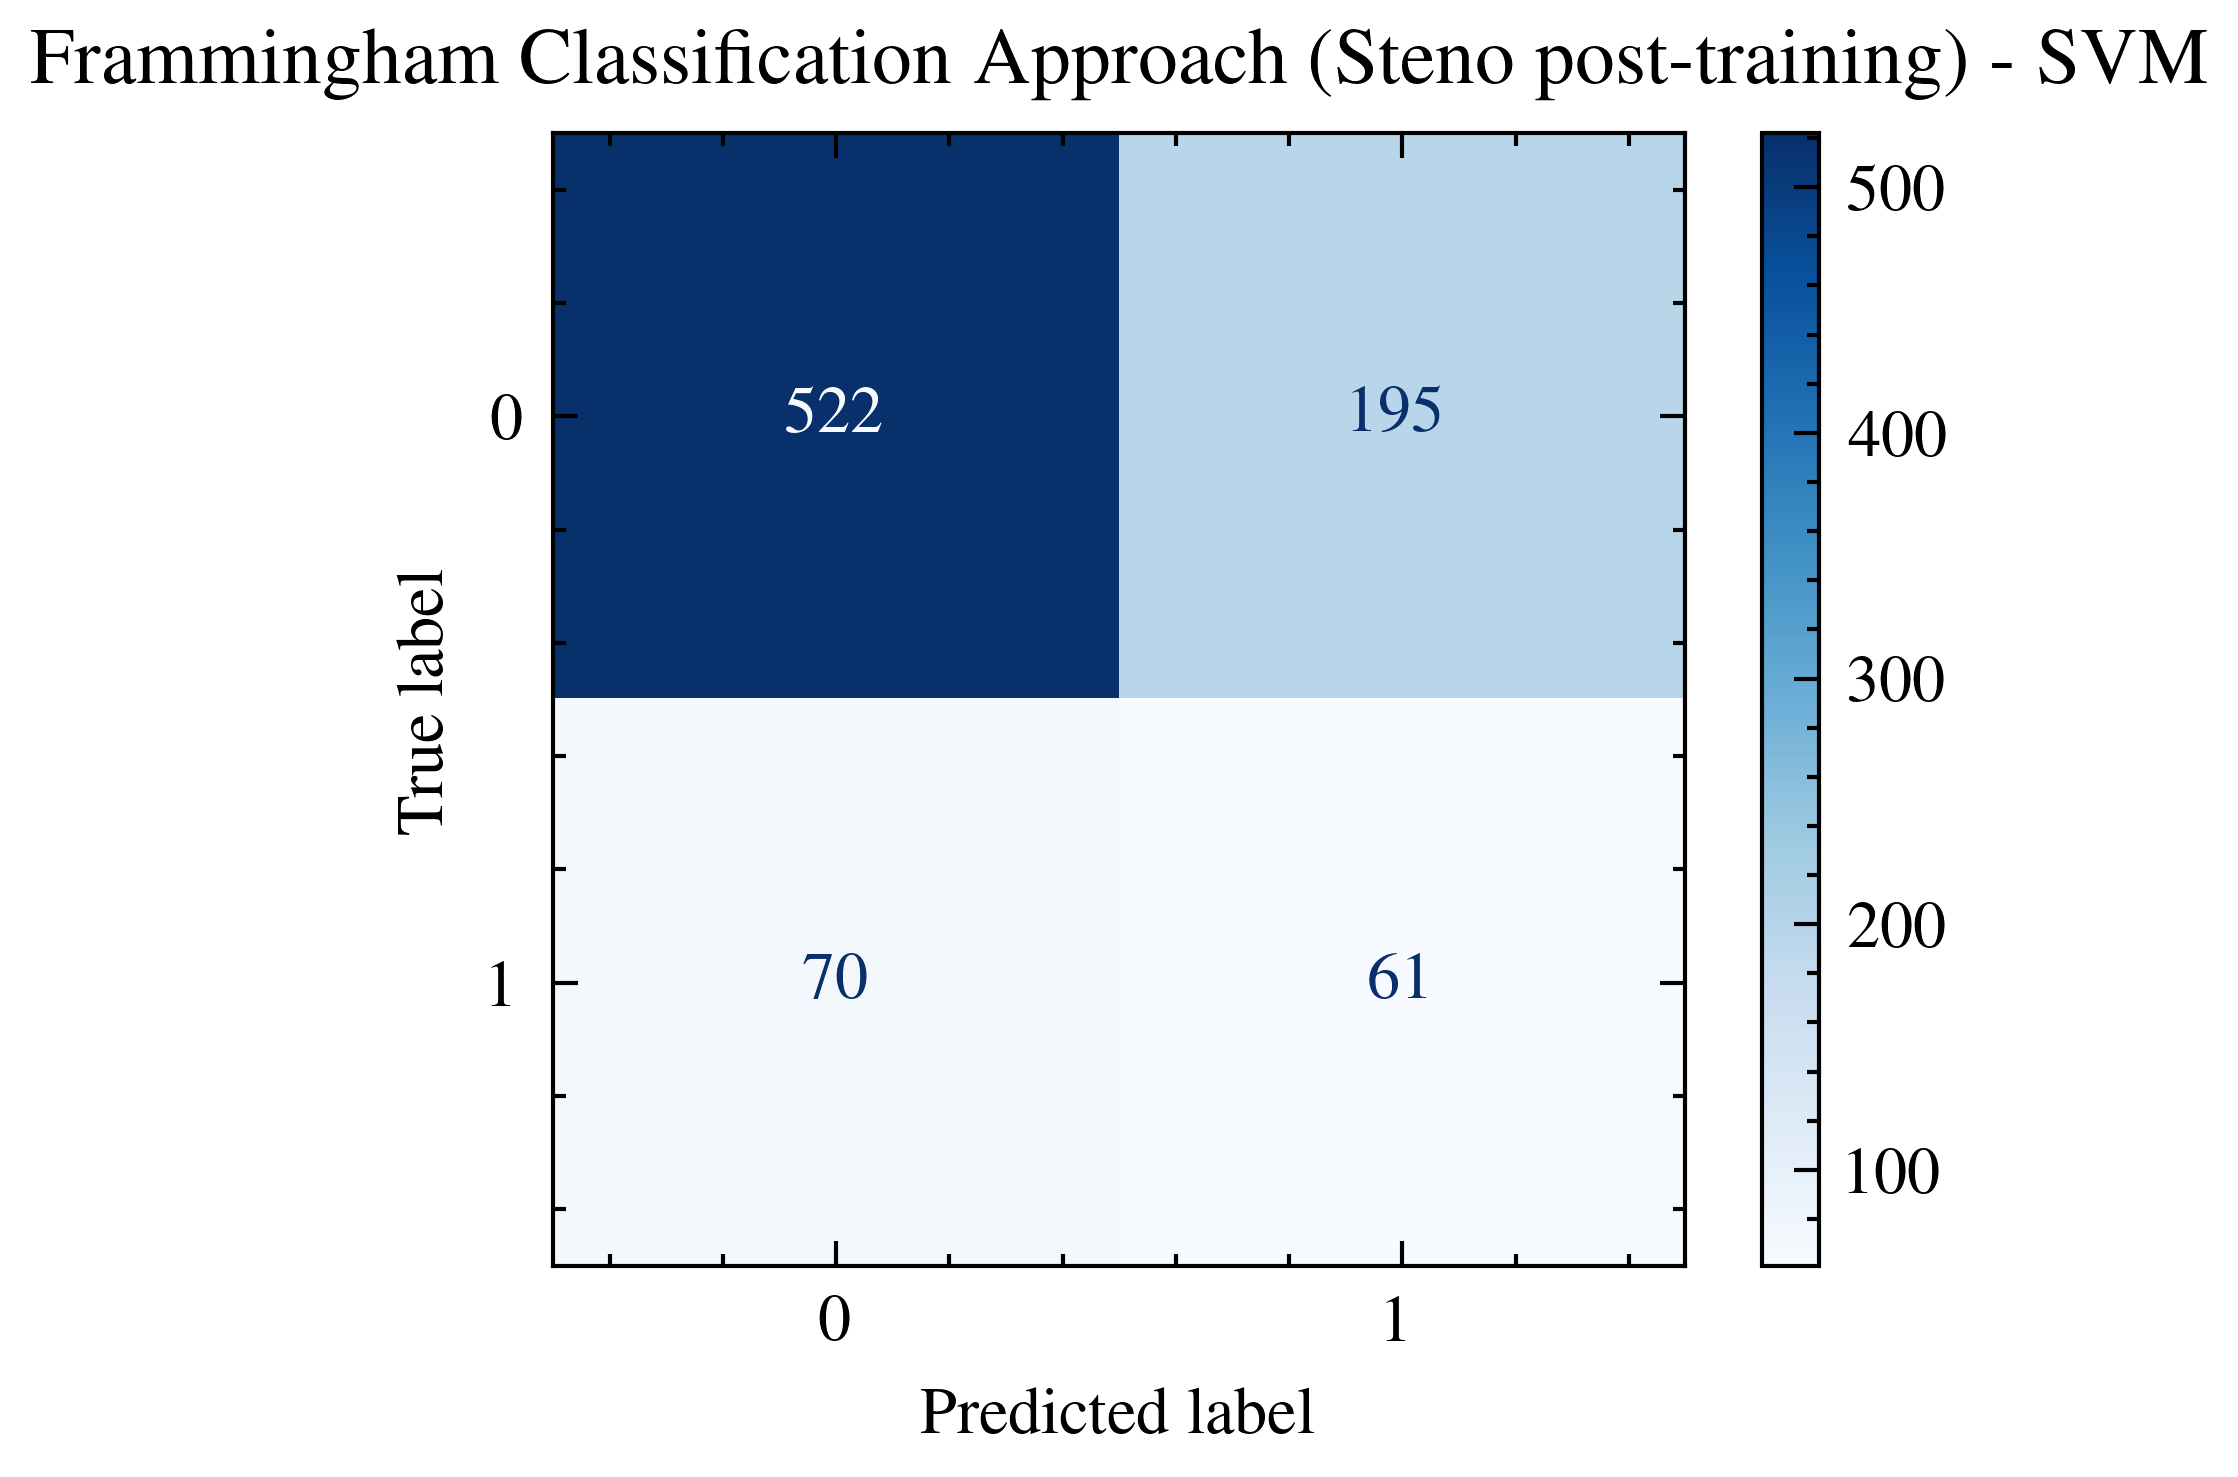

<Figure size 1980x1500 with 0 Axes>

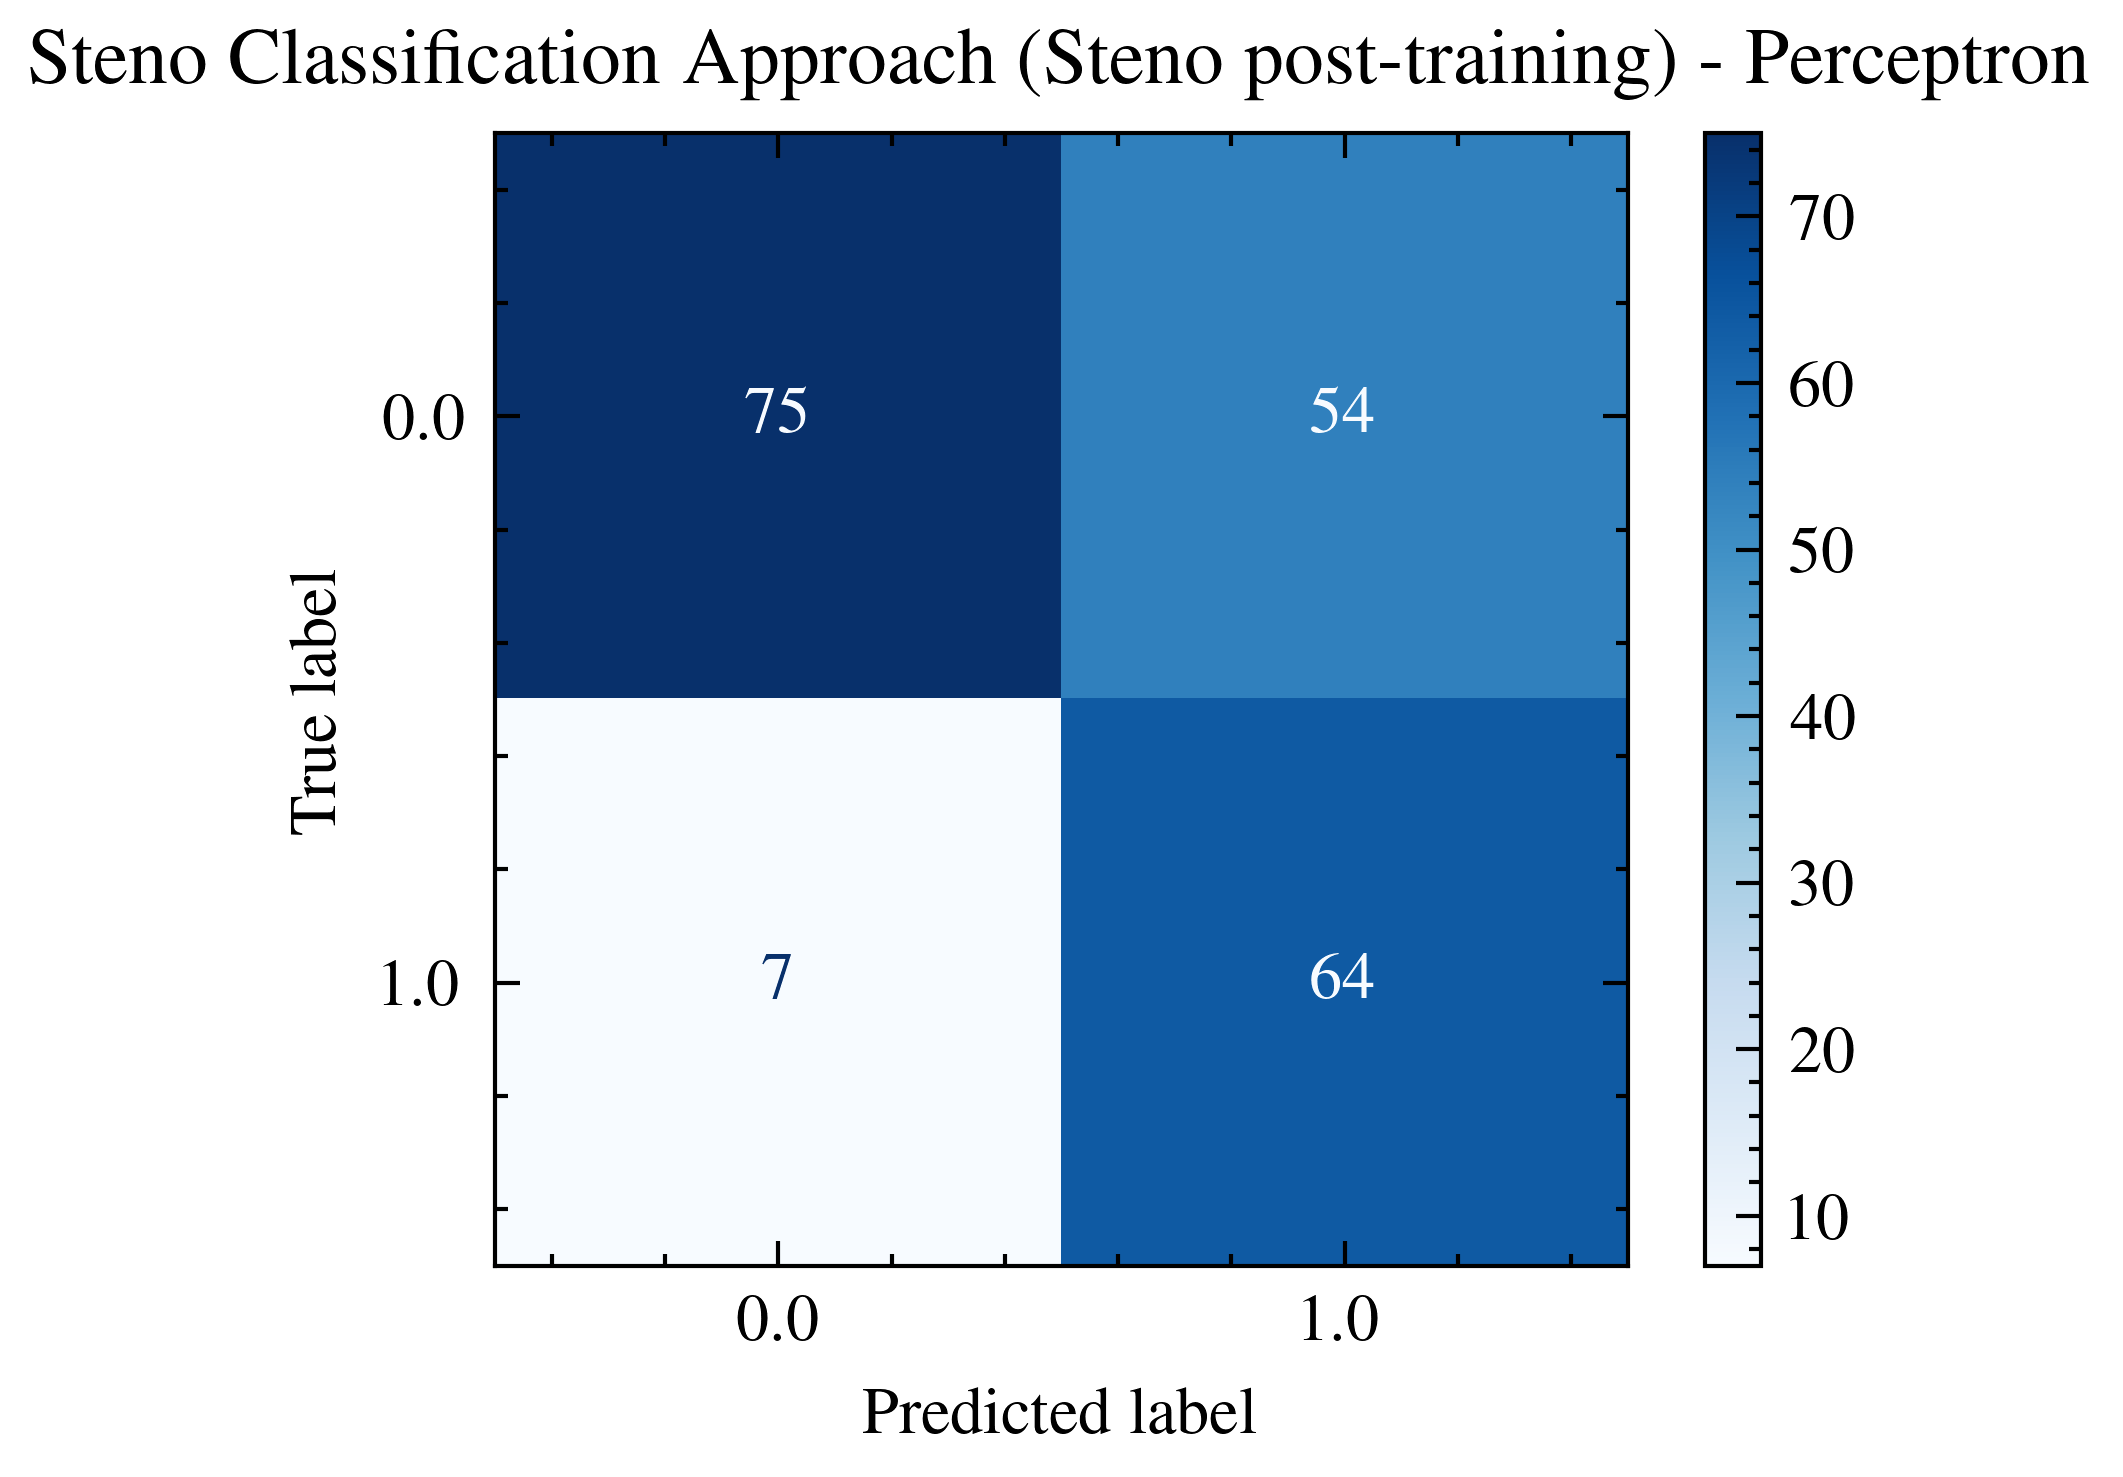

<Figure size 1980x1500 with 0 Axes>

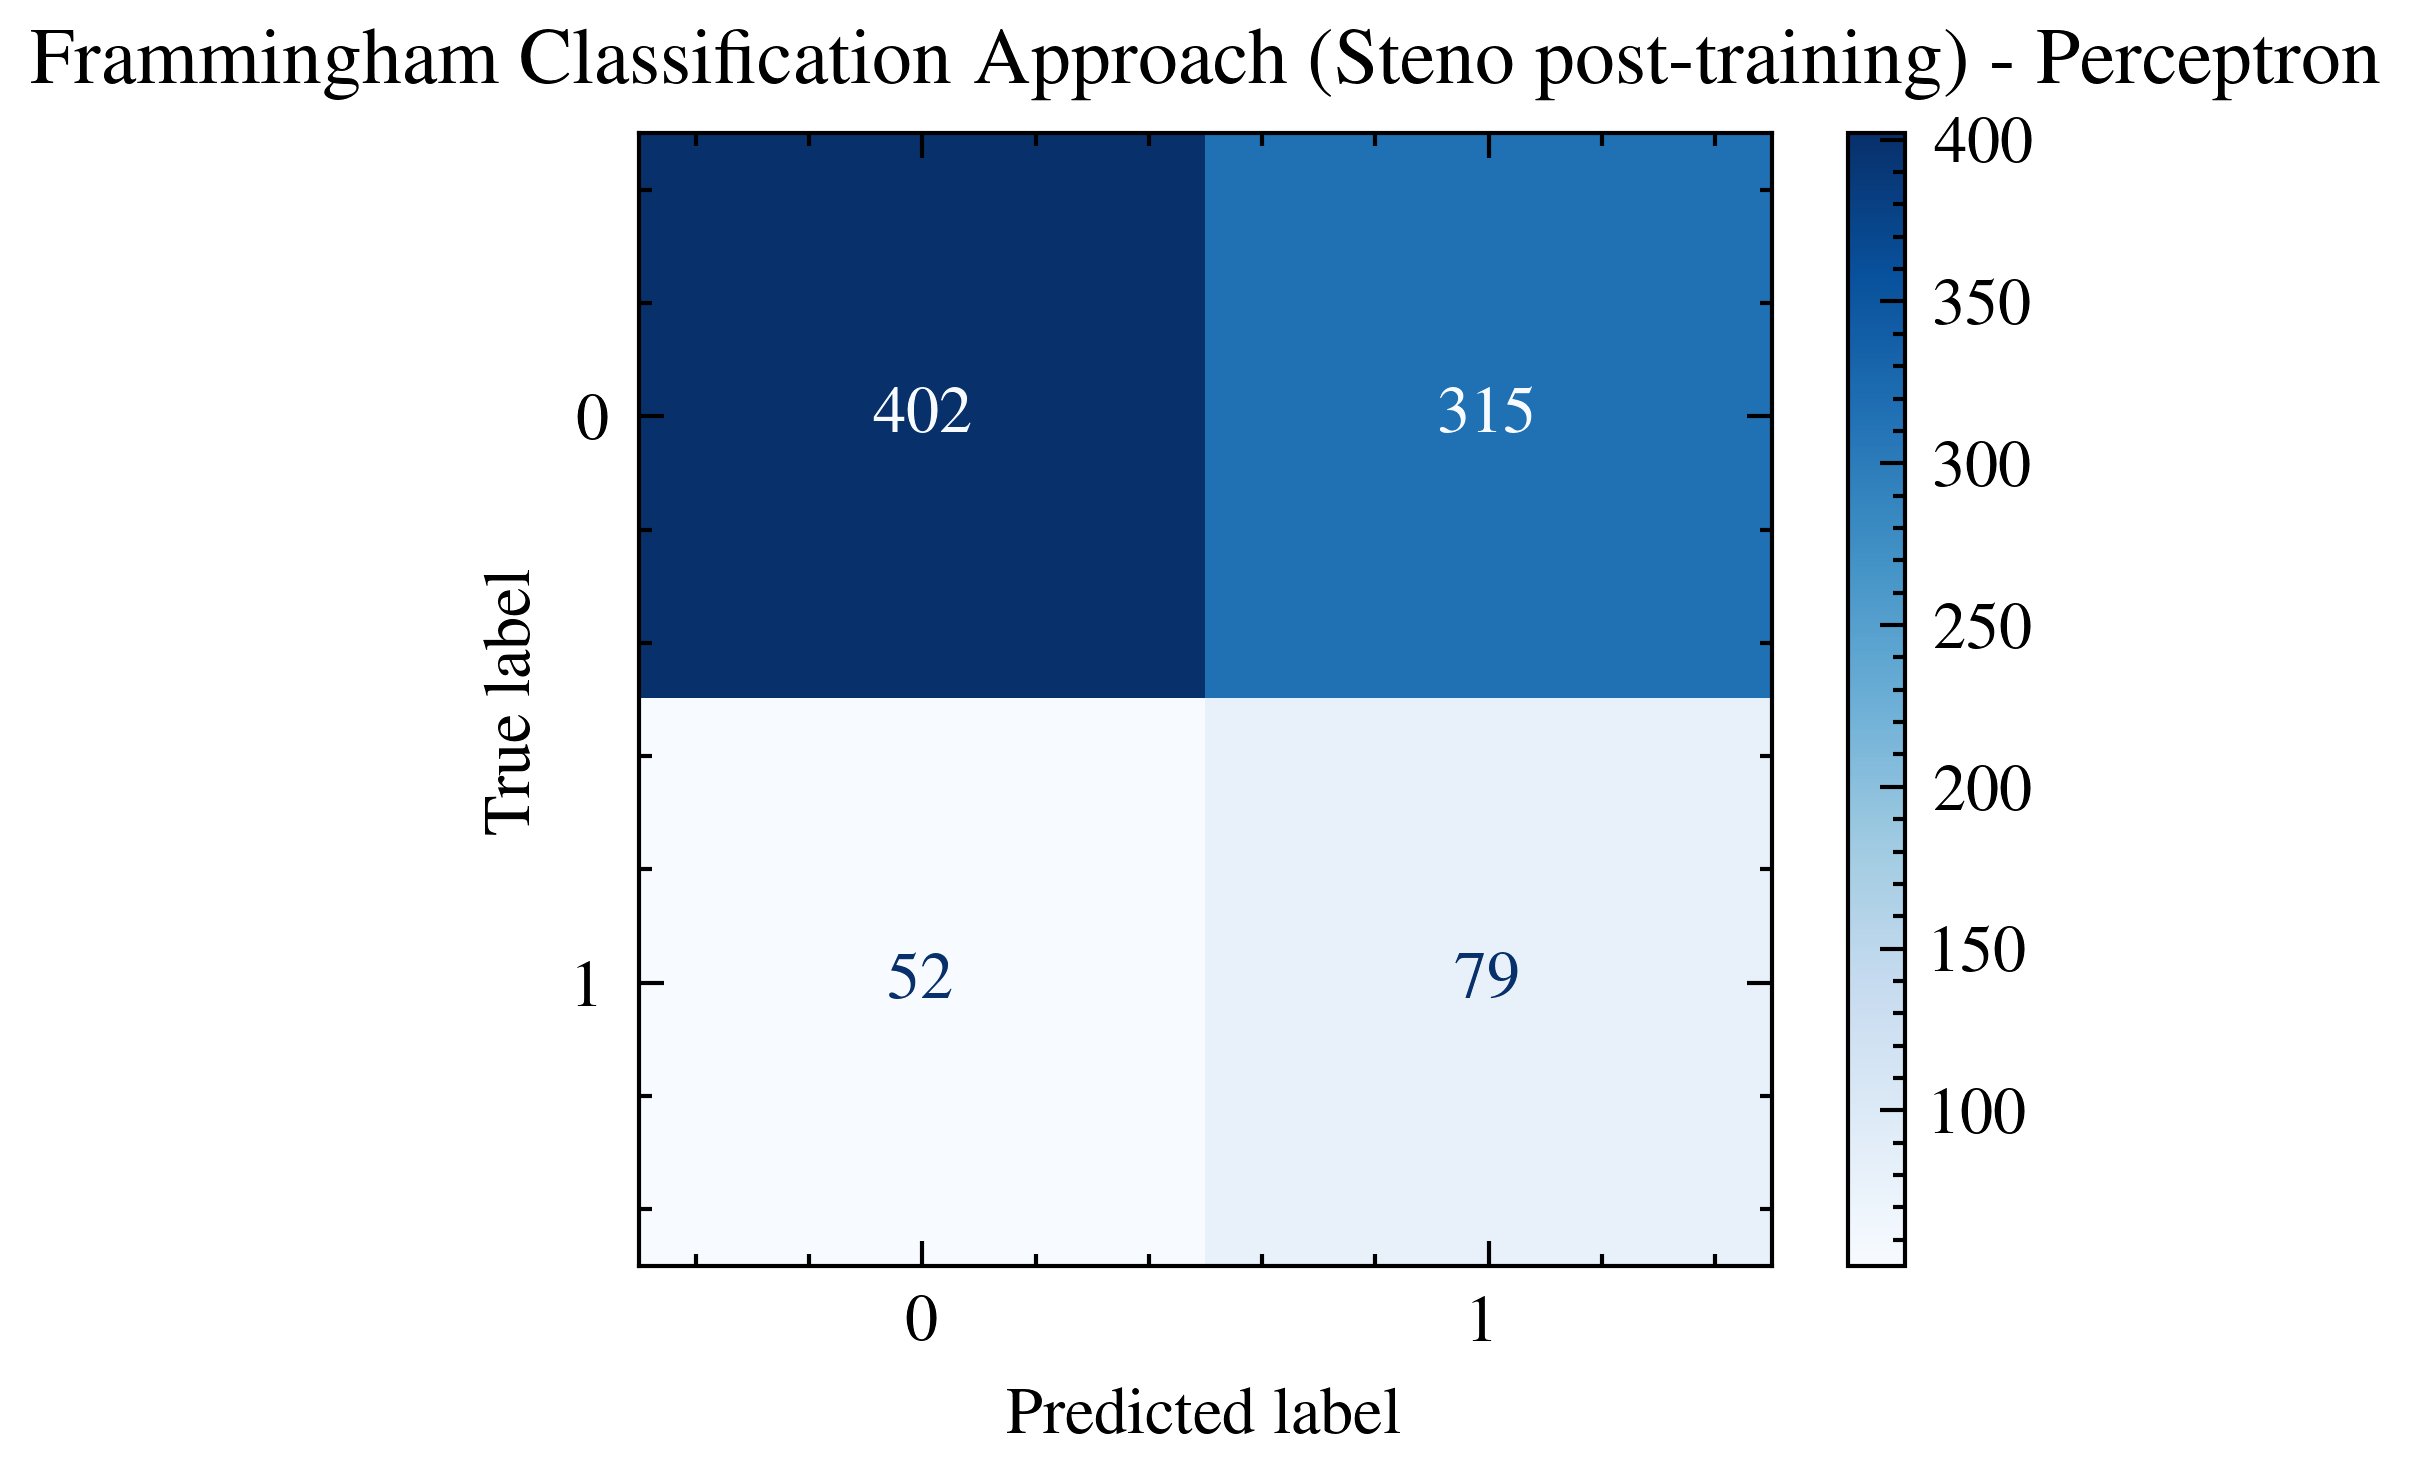

<Figure size 1980x1500 with 0 Axes>

In [34]:
# Confusion matrix in the pre-training
title = "Steno Classification Approach (Steno post-training) - SVM "
disp = plot_confusion_matrix(svm_posttrained, steno_2common_X_val, steno_y_val['Class_label_binary'],
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Steno_SVM_post_training.png", dpi = 300)

title = "Frammingham Classification Approach (Steno post-training) - SVM"
disp = plot_confusion_matrix(svm_posttrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'], 
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Frammingham_SVM_post_training.png", dpi = 300)

# Confusion matrix for Frammingham 
title = "Steno Classification Approach (Steno post-training) - Perceptron"
disp = plot_confusion_matrix(perc_posttrained, steno_2common_X_val, steno_y_val['Class_label_binary'],
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure
plt.savefig("Steno_Perceptron_post_training.png", dpi = 300)

title = "Frammingham Classification Approach (Steno post-training) - Perceptron"
disp = plot_confusion_matrix(perc_posttrained, fram_2common_X_val.to_numpy(), fram_y_val['TenYearCHD'], 
                        cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()
# Save figure 
plt.savefig("Frammingham_Perceptron_post_training.png", dpi = 300)

In [35]:
# Create a Dataframe with SVM pre and post 
results = pd.DataFrame({'ACC - Prev': [steno_acc_SVM_prev, fram_acc_SVM_prev],
                        'ACC - Post': [steno_acc_SVM_post, fram_acc_SVM_post],
                        'AUC - Prev': [steno_auc_SVM_prev, fram_auc_SVM_prev], 
                        'AUC - Post': [steno_auc_SVM_post, fram_auc_SVM_post],
                        'F1 - Prev': [f1_steno_SVM_prev, f1_fram_SVM_prev],
                        'F1 - Post': [f1_steno_SVM_post, f1_fram_SVM_post],
                        'Recall - Prev': [recall_steno_SVM_prev, recall_fram_SVM_prev],
                        'Recall - Post': [recall_steno_SVM_post, recall_fram_SVM_post],
                        'Precision - Prev': [prec_steno_SVM_prev, prec_fram_SVM_prev],
                        'Precision - Post': [prec_steno_SVM_post, prec_fram_SVM_post]}, index=['Steno Only 5 common - SVM', 'Frammingham Only 5 common - SVM'])
results.to_excel('SVM_Steno_Frammingham_5common.xlsx')

# Create a Dataframe with Perceptron pre and post
results = pd.DataFrame({'ACC - Prev': [steno_acc_perc_prev, fram_acc_perc_prev],
                        'ACC - Post': [steno_acc_perc_post, fram_acc_perc_post],
                        'AUC - Prev': [steno_auc_perc_prev, fram_auc_perc_prev],
                        'AUC - Post': [steno_auc_perc_post, fram_auc_perc_post],
                        'F1 - Prev': [f1_steno_perc_prev, f1_fram_perc_prev],
                        'F1 - Post': [f1_steno_perc_post, f1_fram_perc_post],
                        'Recall - Prev': [recall_steno_perc_prev, recall_fram_perc_prev],
                        'Recall - Post': [recall_steno_perc_post, recall_fram_perc_post],
                        'Precision - Prev': [prec_steno_perc_prev, prec_fram_perc_prev],
                        'Precision - Post': [prec_steno_perc_post, prec_fram_perc_post]}, index=['Steno Only 5 common - Perceptron', 'Frammingham Only 5 common - Perceptron'])
results.to_excel('Perceptron_Steno_Frammingham_5common.xlsx')
                        

In [36]:
# Concatenated steno and framingham validation set 
X_val = pd.concat([steno_2common_X_val, fram_2common_X_val])

In [37]:
# Execution time 
n_instances = X_test.shape[0]
SVM_runtimes = np.zeros(n_instances, dtype=float)
for i in range(n_instances):
    instance = X_test[[i], :]
    start = time.time()
    svm_posttrained.predict(instance)
    SVM_runtimes[i] = time.time() - start

MLP_runtimes = np.zeros(n_instances, dtype=float)
for i in range(n_instances):
    instance = X_test[[i], :]
    start = time.time()
    perc_posttrained.predict(instance)
    MLP_runtimes[i] = time.time() - start

print(SVM_runtimes.mean())
print(SVM_runtimes.std())
print(MLP_runtimes.mean())
print(MLP_runtimes.std())

7.50124454498291e-05
0.0002634351425102396
6.251335144042968e-05
0.00024211321423961218


In [38]:
# Export SVM and Perceptron using pickle
pickle.dump(svm_posttrained, open('svm_posttrained.sav', 'wb'))
pickle.dump(perc_posttrained, open('perc_posttrained.sav', 'wb'))
